# Tutorial 6. Classification and Regression Trees. Random Forests

by Nadzeya Laurentsyeva @ nadzeya.laurentsyeva@econ.lmu.de


In [1]:
# Packages to import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree


## 1. Overview and data
First, replicate and try to understand the code from the lecture. This tutorial will be based on it. 

**Overview of the tutorial** 
* Practice estimating CART, Random forests, (OLS and Lasso for review)
* Fitting a simple CART with different stopping rules
* Pruning with CV and using a Minimal Cost-Complexity
* Fitting a random forest; adding extra randomization 
* Investigating importance of features in explaining the data 
* Comparing the performance of CART/RF models with that of OLS and LASSO
* !!!Competition: you task is to obtain the highest **out-of-sample** performance. 

In [2]:
# California housing data
# 
df = pd.read_csv("data/CAhousing.csv")
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


This is the data on house prices in California. The dataset contains median home values (medval) for about 20K census tracks in California. 

Features/independent variables:
* Latitude and longitude of tract centers
* Total population and number of households
* Median income
* Average age of houses, total rooms, total bedrooms

Task
* Predict median home values given covariates
* It is likely that home values and covariate effects change with spatial location, non-linear in longitude and latitude
* How could have we captured this non-linearity in linear models? 

In [3]:
# Before the analysis, we do some transformations. 
# we add variables AveRooms, AveBedrooms, AveOccupancy (assumption: one household lives in one house)
# I do this transformation to make the analysis similar to that in Matt Taddy's book

df['aveRooms'] = df['totalRooms']/df['households']
df['aveBedrooms'] = df['totalBedrooms']/df['households']
df['aveOccupancy'] = df['population']/df['households']
df_tofit = df[['longitude', 'latitude', 'housingMedianAge', 'aveRooms', 'aveBedrooms', \
               'aveOccupancy', 'medianIncome', 'medianHouseValue']]

df_tofit.describe()

,longitude,latitude,housingMedianAge,aveRooms,aveBedrooms,aveOccupancy,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,5.429000,1.096675,3.070655,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2.474173,0.473911,10.386050,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,0.846154,0.333333,0.692308,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,4.440716,1.006079,2.429741,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,5.229129,1.048780,2.818116,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,6.052381,1.099526,3.282261,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,141.909091,34.066667,1243.333333,15.000100,500001.000000


<div class="alert alert-block alert-info">
<b>Question 1:</b> Shall we transform the variables before fitting CART?  
       
</div>

Answer: 
    
It is not necessary to transform the inputs (a monotonic transformation of our inputs, e.g. a log transformation, will not affect which split is chosen by the algorithm, as we evaluate splits within dimensions). MSE can be affected by the units of the dependent variable $y$ (e.g. when we log-transform $y$, by construction, larger values of $y$ become more homogenous). 

<AxesSubplot:>

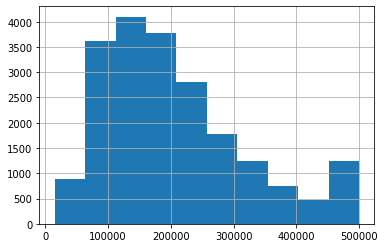

In [4]:
df_tofit['medianHouseValue'].hist()
# as we can see there are some large outliers of medianHouseValue. Therefore, a log transformation seems reasonable. 

<AxesSubplot:>

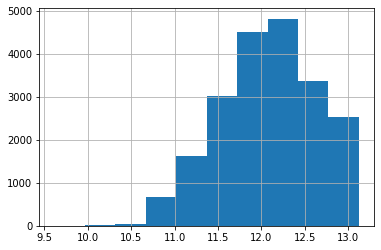

In [5]:
# We generate two datasets: one where only medianHouseValue is transformed and 
# another where we also transform some inputs

df_ylog = df_tofit.copy()
df_alllog = df_tofit.copy()

for x in ['medianHouseValue']:
    df_ylog[x] = np.log(df_ylog[x])
    
for x in ['medianHouseValue', 'aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
    df_alllog[x] = np.log(df_alllog[x]) # I do it mainly to show how log transformation of inputs affects the estimations

df_ylog['medianHouseValue'].hist()

## 2. Fitting a simple CART 

* Set y and x
* Split the data into training and test samples 
* Fit a simple CART model on the training sample.

<div class="alert alert-block alert-info">
<b>Question 2:</b> Fitting a simple CART  
    
* Which stopping rule do you use to regularize your model?
    
* What is your out-of-sample Rsq and MSE? 
    
* What is the depth of your tree?        
</div>
 


Tree depth: 20
Tree leaf nodes: 1278
Out-of-sample Rsq: 0.765
Out-of-sample MSE: 0.077


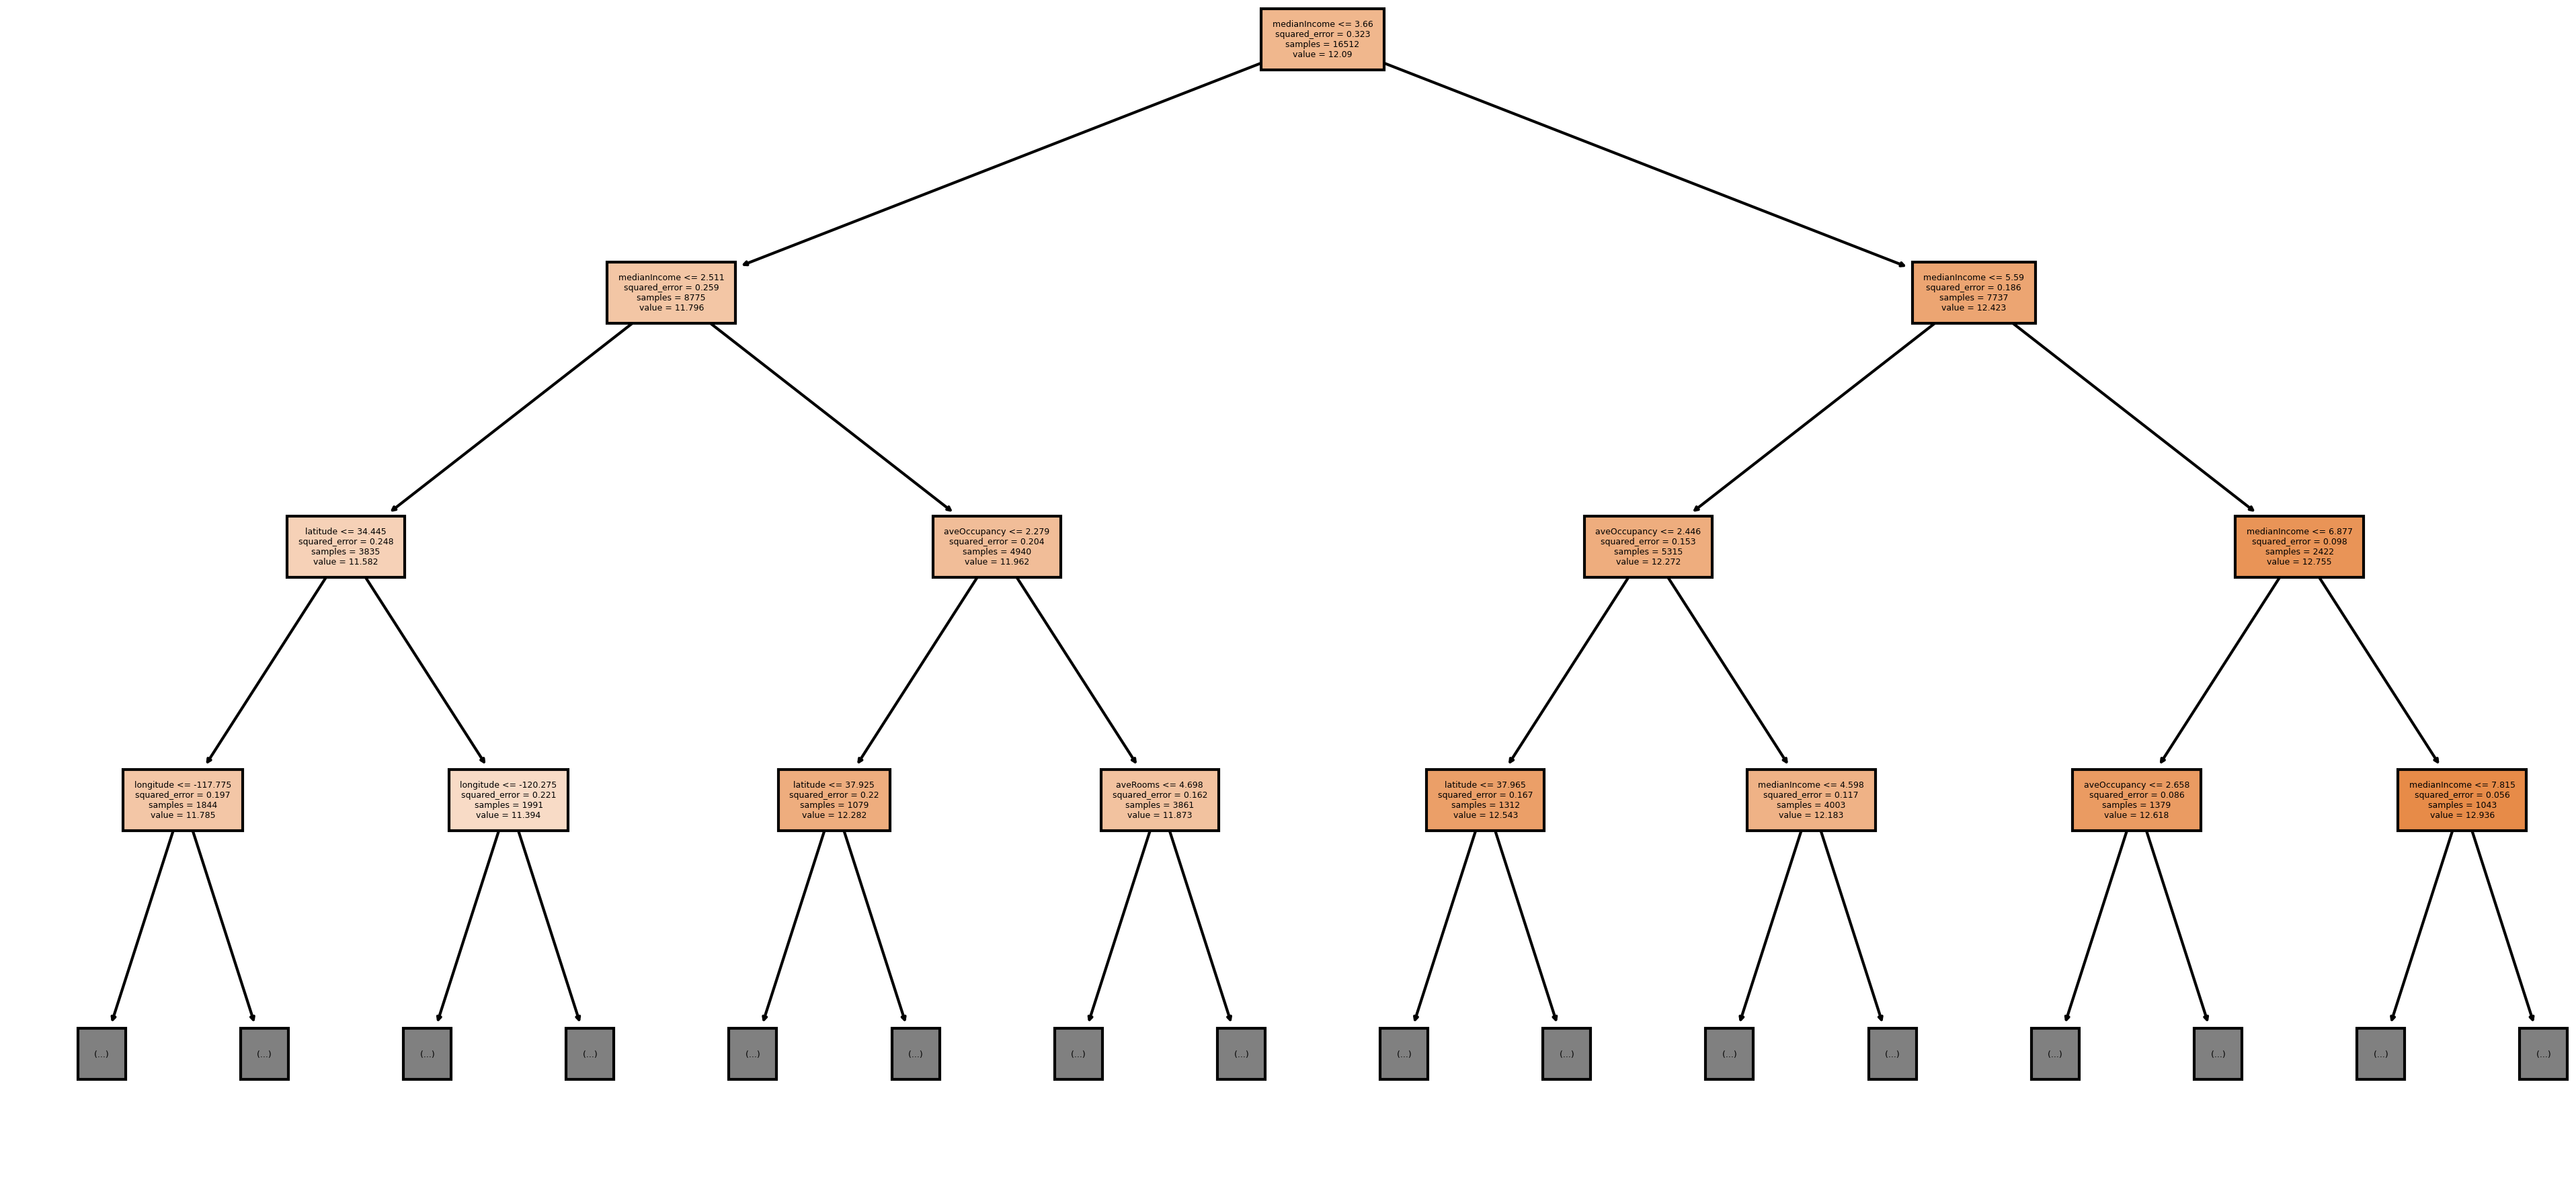

In [11]:
data = df_ylog.copy() # you can check what changes if you use instead df_alllog or df_tofit 

y = data['medianHouseValue'] 
X = data.iloc[:, :7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html 

# set your own parameters to stabilize the tree
# there is no strong opinion on what stopping rule you should use; may differ across datasets you have. 
# Matt Taddy suggests to use mix_sample_leaf, as it seems to set a simple and a transparent rule.

cart = tree.DecisionTreeRegressor(min_samples_leaf = 10, min_impurity_decrease = 0, \
                                  min_samples_split=2, max_depth = None, random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Tree leaf nodes: %.0f' % cart.get_n_leaves())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))


#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300}) # set's parameters of the figure
tree.plot_tree(cart, max_depth = 3, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

## 3. Pruning with CV

<div class="alert alert-block alert-info">
<b>Question 3:</b> Pruning with CV  
    
* How many nodes do you have in your pruned tree? Do you still keep some stopping rules? Which ones?
* What is the out-of-sample Rsq and MSE?      
</div>
 




In [7]:
def cv_iter(max_leaf_nodes, min_samples_leaf, folds, X, y):
    #define settings for cross validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    #define settings for the regression tree
    cart = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, random_state = 1)
    #you can use define different scoring parameters 
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    cv_result = cross_val_score(cart, X, y, cv=kf, scoring = 'neg_mean_squared_error') # would give you Rsq by default
    #note: alternatively you could use cross_validate function, which allows specifying multiple metrics for evaluation.
    #it returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.
    #if you use cross_validate your code would look a bit differently:     
        # cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
        # avg_score = np.mean(cv_result['test_score'])
    avg_score = cv_result.mean()
    return float(avg_score)

562

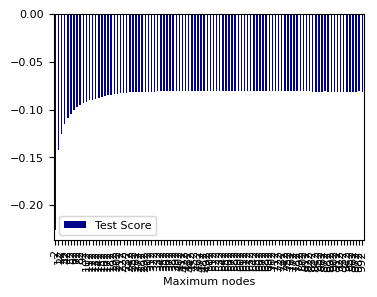

In [9]:
result = {}
for i in range(2, 1000, 10):
    result[i] = cv_iter(i, 10, 10, X_train, y_train) #max_leaf_nodes, min_samples_leaf, folds, X, y

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot.bar(color = 'DarkBlue', xlabel = 'Maximum nodes')

results['Test Score'].idxmax()

Tree depth: 16
Out-of-sample Rsq: 0.768
Out-of-sample MSE: 0.076


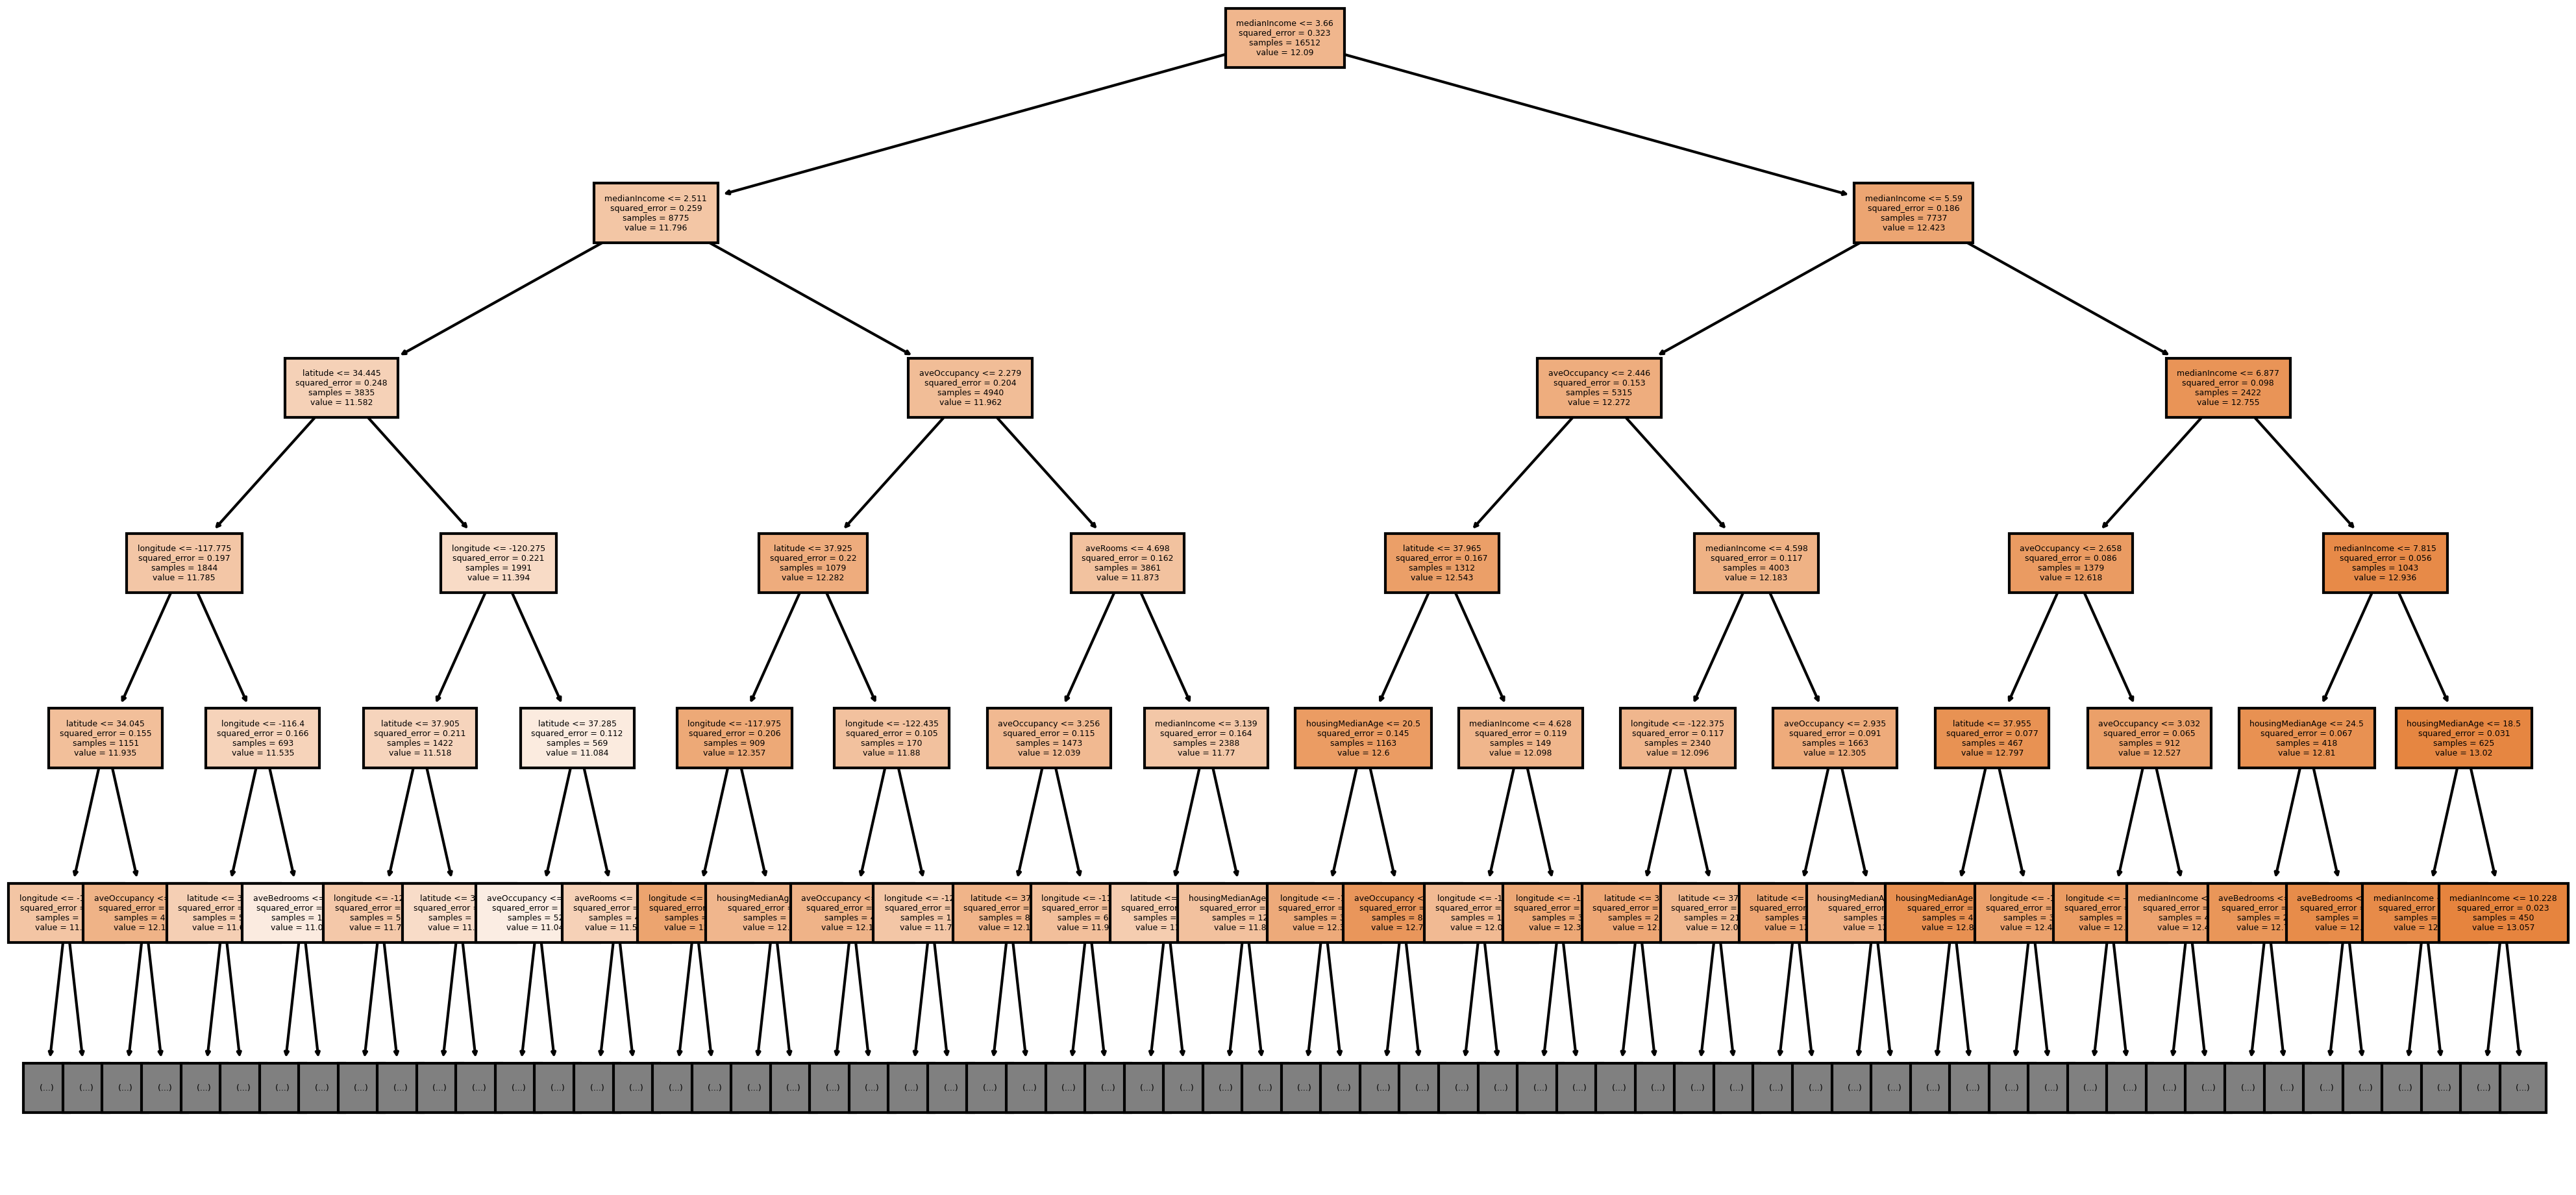

In [10]:
cart = tree.DecisionTreeRegressor( min_samples_leaf = 10, max_depth = None, max_leaf_nodes = results['Test Score'].idxmax(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))


#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

# note the improvement after the pruning proceduredata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA94AAAIBCAYAAAC/cmdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzddXgUVxfH8e/GDQKE4O7u7u7ubkWLuxd3KVCKUyjFtbgVdyvuToITICFu+/4R3oU0CVBgCZTf53n2ITv3zJ0zGzazZ+6dWYPRaEREREREREREzMMiuhMQERERERER+S9T4S0iIiIiIiJiRiq8RURERERERMxIhbeIiIiIiIiIGanwFhERERERETEjFd4iIiIiIiIiZqTCW0RERERERMSMVHiLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEVERERERETMSIW3iIiIiIiIiBmp8BYRERERERExIxXeIiIiIiIiImakwltERERERETEjFR4i4iIiIiIiJiRCm8RERERERERM1LhLSIiIiIiImJGKrxFREREREREzEiFt4iIiIiIiIgZqfAWERERERERMSMV3iIiIiIiIiJmpMJbRERERERExIxUeIuIiIiIiIiYkQpvERERERERETNS4S0iIiIiIiJiRiq8RURERERERMxIhbeIiIiIiIiIGanwFhERERERETEjFd4iIiIiIiIiZqTCW0RERERERMSMVHiLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEVERERERETMSIW3iIiIiIiIiBmp8BYRERERERExI6voTkBERL5dBoPBAnCJ7jxEvhAPo9EYGt1JiIjIt0eFt4iIfAoX4El0JyHyhcQDnkZ3EiIi8u3RVHMRERERERERM1LhLSIiIiIiImJGKrxFREREREREzEjXeIuIyGd1YukEXJxjRHcaIp/Ew/MVeRv1ju40RETkP0KFt4iIfFYuzjFwjR0zutMQERER+WpoqrmIiIiIiIiIGanwFhERERERETEjFd4iIiIiIiIiZqTCW0RERERERMSMVHiLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEVERERERETMSIW3iIiIiIiIiBmp8BYRERERERExIxXeIiIiIiIiImakwltERERERETEjFR4i4iIiIiIiJiRCm8REflu/LpiKxU7jjA9T1C6JRdv3ovGjEREROR7YBXdCYiIiESXR7sWfLa+KnYcQZVieehYv+Jn6/O/auKi9fy+YTceL72xt7OhTIHsjOvalFgxHKNcZ/OBU4yat5qbbo+I6WRPv5a1+KFmGVP7wg17mLp0Ew+ePCdurBiM69aMKsXyfIndEREReS8V3iIiIvJBXvn4YWFhwNHe7pP6qVEyH21qlcXZyQEvH1+6jf+NgdOX8Gv/tpHG7zx6lh4TFzBvyI8Uyp4BLx9fnjz3NLX/9ucufl2xlYXDOpMtXXKevvDCx8//k3IUERH5nFR4i4jIVyNzrS60rFGajXtPcOXOfQrnyMC8oR0ZMXslq3YeJm6sGMwa3IECWdMBEBQczLgF61i5/RAvvX0pkC0dU3v/QELX2ABcvuXOj2PmcOW2OzkzpCJXxlThthejUCMOLRxNtnQpOHv1Dr1+XsjV2/exsLSgZJ4sTOzZAhfnGEDYiHa+LGk5e/U2xy5cJ3WSBMwe3J7MqZNF2I8Df1+iYb/JjOzUmLG/rcHXP5BmVUswsmMjU8zu4+cZMWcl1+89xM7WhvZ1y9OrWXUAlm87yITf/+Sxx0sypkrChO7NyZE+pSmP3JlSc+bKbU5cvEGm1ElZMrobC9fvZs7andhaWzOhR3OqFc8LgNFoZNaq7cxdu5Mnzz3JmjY5P/duRYYUiT/odxISEsqu4+dYvu0gWw/9zZ65w8mQMsm/+bVGkCZpwnDPLQwGbro9ijJ+5JxV9G1Zk6K5MgEQO6YTsWM6mfIbNW81cwZ3IHv6FADEi+MMOH9SjiIiIp+TrvEWEZGvytpdR1kypjvXNvyK+2MPSrX5iRJ5s3B36xzqlitMt/HzTbHDZq/k6Llr7Jg1hBsbZ5AmaUJa/PQLAMHBIdTvM5ESuTNzd+schrSrx6INe6LcroWFgWEdGnBz80yOLx7Pg6cvGDJjebiY5dsOMqJjI9y2zSVnhpT0mvx7lP298vXjym13zqyYzI5ZQ5i7ZicH/r4EwNmrd2jQdxLdGlfl9pZZnFo2kWKvi8qDpy/TfeJvTO3zA7e3zKJGyfzU7D4OT29fU9+rdx5mQvfm3Ns2hxgOdlT8cQSxYzpxY8MMBrSuTeexcwkKDgZg3tq/WLRpLysn9OLOltlUK56X+r0nEhgU/M7fw9mrd+g39Q/SVe/IsFkryJE+JaeXTzIV3W6PnpGkXOsoH3V6TXhn/yt3HCJRmR9IXLY1G/efpGvjKpHG+fj5c/rqbR4+e0GO+j1IXaUDTQdO4dGzFwBcv/eAJ889OXP1DplrdSF99U50GjMXLx/fSPsTERGJDiq8RUTkq9K6ZhmSxHfB2cmBcoVyECemE9VL5MPS0oLapQtw6ZY7gUHBGI1G5q3dyZguTUgQNzY21lb81LYuR89fxf2xB8cuXMfD8xUDWtfGxtqK/FnTUatMgSi3mzVtcgplz4C1lRXx4jjTqUFFDp6+FC6mfvnCZE2bHCsrSxpVKsaZq7ej7M9ohJ/a1cPO1oYMKRKTP2taTl8Ji1+wYRe1yxSkesl8WFtZ4ezkQL4saYGw4r5++cIUyZkRaysrOtavSKyYjmw/fPqtPIqQMVUSbG2sqVosLz7+AXSoVwErK0vqli3Ec09v7j16BsCctTsY2LoOaZImxMrKkg71KuAXEMiJizcizXvd7qPka9yHRv0nY2drzeZfBnLo9zF0aVSZBHFjm+KSJoiL+455UT5WT+z9zt9zvXKFefDXfC6tnUaXRpVJmShepHEvX/lgNBrZtP8kG6b05+zKn7G1tqb1sBkAPPfyBmDvyfPs+20kh34fzd2HT+g3dfE7ty8iIvIlaaq5iIh8VVxjxzT97GBr83racBh7O1uMRiO+/gEEBYfg4xdAhR+HYzAYTDE2Vla4P/Hg0bMXJIgbG2urN4e6pPFduXrnQaTbven+iAHTlvD3lZv4+AYQagzF2soyXEx8l1imnx3tbPH2jfo64piO9jjY2b7ZFztbvH39gLDR4oLZM0S63oOnzymSM2O4ZSkSunL/yXPT8/CvSfjX6P/b9Hmd272Hz2gzfAaWFm/OtQcGBfPgrf7edv/Jc9weP6NorkxkTZOc5FEUxJ9L0gRxqVAoJ/X7TOLsqp8jtP//evL2dcuTLKErAANa1yFH/R74+Pnj9Lq9Z7PqxI0V0/Rzy5+mmzVvERGRf0OFt4iIfJNcnJ1wsLNl99zhpI/keuVDIVd49OwFQcHBpuLb/fGzKPvrNn4+aZImZPbgCcSK4cjGfSfoMGq2WXJPmiAut9wfR9qWyDUO9x49Dbfs7sOnJI4X56O2lTheHMZ1a0bZAtk/KL5Tg0q0rF6KDXtPsGjjXrqOn0+lIrmoW64wJfNkwer1yQi3R8/I2zjqUe1C2TOwdnLfD9pmUEgIdx89Dfe7+r9YMRxJGj9upOsZjZA2eSLsbKw/aDsiIiLRRVPNRUTkm2RhYUGrGqUZ8MsS3B97AODh+Yo1fx0BIF+WNMSO6cS4BesIDArmxMUbrNl1NMr+Xvn44eRgT0xHe9wfezB16Waz5d6iWilW7zzMhn0nCA4OwdPbl+MXrgPQoEIRVm4/zJFzVwkODmHWqu089/KmXMEcH7WttrXLMWruKq7dDRvp9/LxZdP+k7zy8YtyHUd7OxpWLMr6qf05uXQCWdIkZ8jM5aSr3pHb98NOGCRNEJdHuxZE+XhX0T1/3V88fX1X8tv3HzNkxnKK58ocoej+v5bVSzF79Q4ePH2OX0AgYxespUSezDg52GFva0P98kX4+Y+NvPDy5uUrH37+YyOVi+b+qNdLRETEHDTiLSIi36xhHRowZfFGqnQeyePnnsSJ6UTxPFmoXaYg1lZWrBjfk05j5jJ9+RZyZUxN0yrF+fvyrUj7Gt2lCV3Hz2fu2h2kSZqQ+uULc+W2u1nyzpE+JYtHd2Pk3FW0HzELRwdbOtStQL4saSmSMyMTejSn4+g5r+9qnpS1k/q+8zuu36VdnXJYWljQeMDP3H/8HCcHOwpmT0/x3Jk/aP0EcWPTpVFlujSqzKWbbjh/ZB5v23vyAiPnrsbXP4DYMR0pVzAHg9vWM7V3fX0Dval9fgCgR9NqPPfypmCzfgAUy5WJuT/9aIof160pPSYtJGudbthYW1GpSG7GdGnyyXmKiIh8Lgaj0RjdOYiIyDfKYDC4Ak/eXnZr86xw12mLfIuevvAiVeX2/1wcz2g0Po0sXkRE5F001VxERERERETEjFR4i4iIiIiIiJiRCm8RERERERERM1LhLSIiIiIiImJGKrxFREREREREzEhfJyYiIvIfERQcTL+pf7ByxyEMGKhXvjBjuzTFysoy0vhekxeyaf9JvLz9cHKwo2ap/Izo2AgbayuePvek37Q/OHj6Cq98/EiZOB4DWtcxfT92QGAQNbqP5crt+wQEBpEgbiw6NahEqxqlv+Qui4iIfBM04i0iIvIfMX7hnxw5d40TSyZwfMl4Dp+9ysRF66OMb12rLKeWTeTBX/M5vGgM52/cY8rijQB4+/mTLV0Kds8dhvuOuQxsU4dWQ6abvtvcytKSiT2ac33Drzz4az5Lx3Rn5NxVHDpz5Yvsq4iIyLdEhbeIiEgkMtfqwsRF6yneahDxS7WkVo9xPPfypvuE30hSrjU56nXn6PlrpvgV2w+So153EpZpRbpqHRm3YK2p7czV21TqNJJk5duQvW53FqzfbZac/9i0lz7Na5AgbmwSxI1N7+bVWbRxb5TxGVIkxtHeDgCjESwMBm64PwIgZeL4dG1UhcTxXLCwsKBSkdykTZaQ4xdvAGBpaUHm1MnejKYbDBgMBm69Xl9ERETe0FRzERGRKKzddZSV43sRw9Gesu2GUqrNTwzr0ICJPVowdsFauo2fz9E/xuHj50/7kbPZOG0ARXJm5OUrH266hRWgjz1eUq3rGKb0bkX1Evm4euc+1buPIWXieJTIkyXCNg+fvUK93hOjzKlu2UL83LtVhOUvvLy5/+Q5WdMlNy3LmjY5bo+f4enti7OTQ6T9TVq0gQm/r8PHL4A4zk4M/7FhpHFPn3ty9c59sqROFm55nV4T2HvyAgGBQWRJk4yqxfNGmbuIiMj3SoW3iIhIFFrXLEOS+C4AlCuUg8NnrlC9RD4AapcuwLgF6wgMCgbA2sqSa3cfkC1dcmLFcCR3ptQALNt2gMI5MlCrdAEAMqVOSpNKxVm543CkhXeh7Blw3zHvX+fq4xcAEK7AdnZyBMDb1y/Kwrtns2r0bFaNK3fus3L7IeK7OEeICQwKpsVPv1CzdAFyZUwVrm31xN6EhIRy5NxVDp6+jL2tzb/OXURE5L9OU81FRESi4Bo7pulnB1sb4sV5U5Ta29liNBrx9Q/A0d6OlRN6sfnASTLW6EzZ9kPZf+oiAPcePmPHkTMkKdfa9Ji1ejuPPV581lwd7W0B8PL2My3z8vEFwMnB/r3rZ0iRmKxpk9F+5KxwywODgmkycAr2drZM79cm0nUtLS0okjMjT557MnXJpo/dBRERkf8sjXiLiIh8BiXyZKFEniwEBQczd81OGvabjNv2uSSO50LVYnlYOKLLB/Vz6MwVavccF2V7/fJFmNrnhwjLY8d0InG8OJy/fpdUSeIDcP7aXZLEd4lytPufgoJDuOn22PQ8MCiYpgOnEhQUzPJxPbGxfvfHhqDgYNM14iIiIvKGCm8REZFP9OS5J0fPX6Nkniw4OdgRw9EeS8uwm441rFiE6cu3sH7PcSoVzQXA5VvuBAWHmKajv61wjgw82rXgo/JoUrk4E37/kwLZ0gEwcdF6mlctGWmst68/63YfpWrxvDg7OXDplhvjF/5J6fxZgbAiutmgqfj6+7NqQm9sbazDrX/u2h2evXxFwezpsba05K9j51i54zC/9Gv9UbmLiIj8l6nwFhER+UShoaHMXLmNH0fNJjTUSJpkCVg8qisWFhYkco3Dnz/346cZy+gyfh7GUCPpUiRmUJs6nz2Pvi1r8tzTmzyNegFho+O9mlU3tXcdPx+AqX1+wGCAVTsPM3D6UgKDgnCNHZNqJfIxsHVYXsfOX2fzgVPY2ViTolI7Ux89m1Wnd/MaBIeEMmzWCq7fe4jBAMkSujKmSxPqlSv82fdLRETkW2cwGo3RnYOIiHyjDAaDK/Dk7WW3Ns8Kd220yLfo6QsvUlVu/8/F8YxG49PoyEdERL5turmaiIiIiIiIiBmp8BYRERERERExIxXeIiIiIiIiImakwltERERERETEjFR4i4iImFm7kbPoO2VRdKchIiIi0URfJyYiIvKdCQwKptWQ6Zy+cot7j56xdEx3qhbPGy7m5SsfBk5fwqb9JwkKCiFNsgRsm/ETDna2HPj7EpU6jcTR3tYU37hSMSb1bAnApZtuDPhlMaev3ua5pzdu2+cSK4ajKXbq0k0s23qAew+fEcPRntplCjK0fX1srPWxRERE/pt0hBMREfkOFcyeng71KvDD0OkR2kJDQ6nbewKZUyfl9IrJxHJy4Pz1e1hbWZpinJ0ccN8xL9K+rawsqVm6AO3qlqde74kR2kNCQvm1f1uypUvOk+eeNOw3mdHzVzO0fYPPt4MiIiJfERXeIiLyn/XLss3MWLmNl698iBPTid4tatKiWkncHj2j45g5nLt+l5CQEPJlScfkXi1JntAVCJsabmlhgZe3L38dO0vSBHH5fXgXjp6/xrgF6wgICmLgD3VoU7ssAKPnrebvK7eJF8eZP3cfI16cmAzv2Ihq/xhF/r9b7o/pO3URJy7ewMHWlhbVStKreXUsLCy48+AJncfO5e/Lt7C0sCBdisRsmNofBzvbSPv6GDbWVnSsXxEAS4uIV53tOHIW98cebJ0+GKvXxXb29Ck+uP90yRORLnki7j6M/CuvezStZvo5cTwXGlYoyp97jv+LPRAREfm2qPAWEZH/pOv3HjJizioOLBhF+hSJefLckyfPPQEINRrp1KASxXJlIjA4mI6j59B57Fw2TB1gWv/P3cdYM7kPC4d3puPYuTToO4lqJfNxfvUUDp+9Qu2e46leMh/x4jgD8Nexs0zu2ZJpfX5gx9EzNBs0jeOLx5MqSfxwefn6B1C1yyh+rF+RJaO789jjJbV7jid+3Fg0r1qS4bNXkipJAtZO7gvAqcu3sLK0JDLdJ/zGqp2Ho3wNVk7oRaHsGf71a3fwzGVSJY5Pm+Ez2HX8PPFdnOnWuCqNKxUzxXj7+ZO22o9YGCwokjMDIzo2IpFrnH+9rf9vL0uapB+1roiIyLdAhbeIiPwnWVpYYDQauXL7PskSuhIvjrOpSE6e0NU0um1na0Pv5jUo1XYIoaGhWLweAS5fKAcFs6UHoFap/CzfdoCBretgY21FiTxZiOnowMWb94gXJysAaZImpFWN0gBUKpKbYrkysXrnYfq0rBkur+2HTxMrhqNpxDlpgrh0qFeBVTsO07xqSaysLHn07CV3Hz4lTdKEFMiaLsp9/Ll3K37u3eozvmphXnh5s//vS0zs0ZzZgztw6vJNavUYR/KErhTJmZF0yRNxeOEY0qdIzLOXXvSftph6vSey/7eRptfvQy1Yv5uj565xaOHoz74fIiIiXwsV3iIi8p+UKkl8Zg/uwOw1O+gwajZ5M6dhRMeGZEuXgqcvvOg7ZRGHz17By9sPgIDAIF75+uPs5ABgKtIBHOxsieFgj72tzVvLbPD29Tc9T5YgbrjtJ00QlwfPnkfI6+7Dp1y65U6Scq1Ny0JDjSSOHzZaPKpjI0bPX0O1LmMwGMJuWtavVa1/XdB+Cid7OxLHi0O7OuUBKJgtPVWK5mHb4dMUyZmR+C6xiO8SC4D4LrGY1rc1icv9wPV7D0mfIvEHb2fF9oOMmLOSDVMHkCBubHPsioiIyFdBhbeIiPxn1SpdgFqlC+AXEMjIuatoM3wmxxaPY+is5fj6B3BgwWhcY8fk3LU7FG4xAKPR+NHbuvfoWbjn7o+fkT9LxNHqJPFcyJEhJXvmDo+0H9c4zqZR7Is371Gt6xgyp05G9ZL5IsR2HT+fFdsPRpnTmkl9KZzj3081z5ImGev3fvg11wbDv94EK7YfpO/UP1j/c3+ypEn27zsQERH5huh7vEVE5D/p2t0H7D5+Hr+AQGysrHCyt8PKMuyw98rHDwc7W2LFcMDD8xVjflv7ydu74faQBet3ExwcwrZDp9l36hK1yhSIEFehcC6ePvdk7pqd+AcEEhISyrW7Dzjw9yUA1u46itujZxiNRpydHLG0sMDSMvLD9dQ+P/Bo14IoH+8qugMCg/APCMRohOCQEFMuAFWL58U/MIj56/4iJCSUExdvsPnAKSoVyQXA/lMXufPgCUajEQ/PV3Sf8BsZUyYhTdKEABiNRvwDAgkIDALCvr4sbFthJzZW7ThM758XsXZS33910zYREZFvlUa8RUTkPykoOJgRc1dx9fZ9LCwMZEmTjFmD2gMwoHUd2o+YSdLybUjkGodODSqxaf/JT9pemfzZOXHxBgN/WYJr7JjM++lHUyH6NicHOzZMHcDgGUsZu2AtAYFBpEwcj66NqgBw+spt+k9bzMtXPsSK4UizqiWoXDT3J+UWmVwNeppG6ZsNmgbAzIHtaFK5OLFiOLJ6Ym96TlzIgF+WkCheHCb1bGG6UdvZa3doO2ImL7x8iOFoT7FcmVg1obfpBMG9R8/IUruraVupq3QA4MKaqSRP6Mqw2St45eNHpU4jTDFJE8TlxJIJn30/RUREvgaGT5lWJyIi3zeDweAKPHl72a3Ns3CNHTOaMooeo+et5tz1uywf1zO6U5HP5OkLL1JVbv/PxfGMRmPk35EmIiLyDppqLiIiIiIiImJGKrxFREREREREzEjXeIuIiHyiAa3rRHcKIiIi8hXTiLeIiIiIiIiIGanwFhER+UQVO47g1xVbozsNERER+Uqp8BYREfmPGjFnJfmb9CVW0Sb0nbIoXNv1ew9p2G8yqat0IEm51pRpN5Qj566+s78rd+5Tpt1Q4pVsQY76Pdh84FS49lU7DpO7YS8SlG5J8VaDOHXp5mffJxERkW+RCm8REZH/qFRJEjCiY0MqFYn4PeCe3j6ULZCdo3+M4+7WOTSuVIw6Pcfz7KVXpH0FBQdTv/dESuTJzL1tcxjTpQk/DJ3OTfdHABw5d5VuE+Yza1B77u+YT/NqJandazye3r5m3UcREZFvgQpvERH57k1fvoXKnUaGW7bmryPkahD2vdxnr96hbPuhJCvfhhSV2tHyp1/w8HwVaV+LN++jUPP+4ZYVat6fxZv3mZ7vOXGeEj8MIkm51uRt3DvCyPHn0rhSMcoVzEEMR/sIbXkypaFVjdK4xo6JpaUFLauXwtLCgos33CLt69CZKzz3ekXfljWxs7WhYuFcFM6RkeXbDgKw+cApKhfNTd7MabC0tKBVjdI42duxcd8Js+ybiIjIt0R3NRcRke9evXKF+WnGMtwfe5AkvgsAy7YdpGGFogBYWBgY1qEBeTOn4YWXD00HTmXIjOVM79/mX2/rwo17NBs0lcWjulM0V0aOnr9G3V4T2DNvBOmSJ4oQv3LHIXpMXBBlf92bVKNns2r/Oo9/unjzHq98/cmQMnGUeWdImQRrqzcfHbKlTc6FG/cACA01YjSGX8doNJraRUREvmcqvEVE5LsXL44zJfNmYcX2Q/RsVo2nzz3Zc+I8P/dqCUDWtMnDxXZqUJHBvy79qG399ucuGlcqTvE8mQEolD0DFQrnZN3uo/RtWStCfL1yhalXrvBHbetDvXzlQ4uffqFX8+rEd4kVaYyPnz/OTo7hljnHcMDb1w+A8gVzUL/vRI6cu0qeTKlZsH43bo89ePW6XURE5HumwltERARoWKEo4xauo2ezaqzaeZj8WdORNEFcAG66P2LAtCX8feUmPr4BhBpDsbay/Kjt3H34lP2nLoabeh4cEhLpdPAvwdPbl5rdx1IwW3oG/FA7yjhHezu8fMJfr+3l7YeTQ1jexfNkZmzXZnQeO48nzz2pWCQXJfNkIU7MGGbNX0RE5FugwltERASoXCwPXcfP5/SVWyzffpDWtcqa2rqNn0+apAmZPXgCsWI4snHfCTqMmh1pP072dvj6B4Rb9tjjpennJPFd6FCvAsN/bPhBea3YfpCu4+dH2d6zWXV6N6/xQX39k6e3LzW6jyVDyiRM7fMDBoMhytgsaZIxfsE6goKDTdPNz12/S470KUwxLaqVpEW1kkDYzdiy1O7Gj/UrfFRuIiIi/yUqvEVERAB7Wxuql8zP8NkruXL7PjVL5je1vfIJG9mN6WiP+2MPpi7dHGU/WdMl586DJxw6c4X8WdLyy/ItPPf0NrW3ql6amj3GUiZ/NgrnyEhwSAhnrt7GOYYjGVJEvL66fvki1C9f5KP2KSg4mJCQUEJDQgkJDcU/IBBLSwusrazw8gkb6U6bNAG/9m/zzqIboHCODMSO6cSEhX/Ss1l19p68wMHTlxjXralpW5dvuZMlTTJevPJh2KwVJE/kStkC2T8qdxERkf8SFd4iIiKvNapYlIodR1C3bKFwU79Hd2lC1/Hzmbt2B2mSJqR++cJcue0eaR+pkyRgxI8NaTpwCqFGIx3qlidjqiSm9uzpU7BgWGeGz1nFtTv3MVgYyJY2OaM6Nf7s+9Np7DyWbtlvej579Q4aVSrG7EHt2bjvJCcu3uDiTTc2vHXn8al9fjAV+glKt2TNpL4UzpEBaysrVozvSaex8/h58UYSx4vDvCEdSZ0kAQBBwSF0GDWbm+6PsLG2pkqxPKwc3wsLC32BioiIiMH4z1uQioiIfCCDweAKPHl72a3Ns3CNHTOaMhL5PJ6+8CJV5fb/XBzPaDQ+jY58RETk26bT0CIiIiIiIiJmpMJbRERERERExIxUeIuIiIiIiIiYkQpvERERERERETNS4S0iIiIiIiJiRiq8RURERERERMxIhbeIiIiIiIiIGanwFhERERERETEjFd4iIiIiIiIiZqTCW0RERERERMSMVHiLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEVERERERETMSIW3iIiIiIiIiBlZRXcCIiLyTUv7zwUenq+iIw+Rz0r/j0VE5HMyGI3G6M5BRES+MQaDITswEKgDGKI5HZEvZQMw2Gg0novuRERE5NuiwltERD6YwWDICwwCqkV3LiLRaD0w0mg0nozuRERE5NugwltERN7LYDAUBgYD5aM7F5GvyDZghNFoPBzdiYiIyNdNhbeIiETKYDAYgJKEjXCXjOZ0RL5me4ARwF6jPliJiEgkVHiLiEg4rwvu8oSNcBd6R+hzYAqwFPAyf2Yi0SYm0BpoC8R5R9whYCSwXQW4iIi8TYW3iIgApoK7GmEj3HneEfoEmATMNBqNuvWzfDcMBkMMoAPQE4j3jtAThBXgG1WAi4gIqPAWEfnuGQwGC6A2YQV3tneEPgDGA3ONRqPvl8hN5GtkMBgcCBv97gMkfEfoOcIK8DVGozH0S+QmIiJfJxXeIiLfKYPBYAU0AAYAGd8RehcYCyw0Go3+XyI3kW+BwWCwA1oC/YBk7wi9DIwCVhiNxuAvkZuIiHxdVHiLiHxnDAaDDdCEsII79TtCbwKjgT+MRmPQl8hN5Fv0L95TN4Ax6D0lIvLdUeEtIvKd0OiciHm9NYtkIJDhHaH/n0WywGg0BnyJ3EREJHqp8BYR+Y9763rU3kCid4SeJex61LW6HlXk4xkMBkugFrpvgoiIvKbCW0TkP8BgMBQEUgJbjUbji9fLPvQOzCcJ+w5i3YFZ5DN6fePCquibAkREvnsqvEVEvnEGg6E3YaNmALeAIoR953A33v+dwyOAHSq4Rczn9Vf1lQcGA4XeEfoc+Bn4xWg0er61vhMQC7iv96qIyLdJhbeIyDfMYDCUA7YBhrcW+wCO71htD2EF9159iBf5cl4X4CUIK8BLviPUE/gFmELYzdo2EjZrZRPQwGg0+pg1URER+exUeIuIfKMMBkNS4DTg8oGrbANGGo3GQ+bLSkQ+hMFgKEzYFPQK7wjzAdwIf6O2P4DmOmkmIvJtUeEtIvINev31RYeB3B8Qvh4YZTQaT5g3KxH5twwGQ17CCvBq/2K1dkajcY6ZUhIRETNQ4S0i8g0yGAzbCLtm9F1WEVZwn/0CKYnIJzAYDNkJ+xqyOoS/dCQygUAho9F4yuyJiYjIZ6HCW0TkG2MwGFIAtz8gtInRaFxi5nRE5DMyGAyZgAFAQ8DiHaFeQBqj0fj0iyQmIiKf5F1/0EVE5OsU4wPjYpkzCRH5/IxG4yWj0dgE2P2e0JiEXUYiIiLfABXeIiLfGKPReB7Y/56ws8CiL5COiJhHug+ISWX2LERE5LOwiu4ERETk3zMajcUNBkNiwka/DYDl64cF4Atc012PRb5pS4F+74mZ/yUSERGRT6drvOWrYjAYLPjwr0YS+a/zMBqNodGdhIh8eQaDwRIoDuQAQoGQ1//aA4mB7Uajcdt7+tAxVb4nOmbKV02Ft3xVDAaDK/AkuvMQ+UrE042TRORj6Zgq3xkdM+Wrpmu8RURERERERMxIhbeIiIiIiIiIGanwFhERERERETEj3dVcvnpndqzEJXas6E5DxKw8XrwkR7l60Z2GiPzHHfm5HS4x7KM7DZFP4vHKj4LdZ0d3GiL/igpv+eq5xI6Fq0vs6E5DRETkm+cSw564zo7RnYaIyHdHU81FREREREREzEiFt4iIiIiIiIgZqfAWERERERERMSMV3iIiIiIiIiJmpMJbRERERERExIxUeIuIiIiIiIiYkQpvERERERERETNS4S0iIiIiIiJiRiq8RURERERERMxIhbeIiIiIiIiIGanwFhERERERETEjFd4iIiIiIiIiZqTCW0RERERERMSMVHiLfKJffltK2YbtTM9dshTjwpUb0ZiRiIjIt2fm5uNUHfKH6XnSJuO5dPdJNGYkIvL5WEV3AiL/NR4X9n+2vso2bEe1ssXp3KrRZ+vzv6r/mKls+ms/D588wyV2LH5oUIM+P7aMMr5176Gs2LAdG2tr07LNi6ZTIFc2AGYuWskfqzdx4doNyhcvxKrZE8OtP3TyTDbu2MeVm3fo0LQuE3/qaZ4dExH5Trkt7vPZ+qo65A8q5UtPh8r5Pluf/1VjV+5n0pqD2Fm/KROmdqhCrcKZPir+qacP/X7bwf7zdwBoUCIrQxuXwtJS43/yfVHhLSLR6pW3DxYWFjg62H9SP7a2NqyYOZ70qVNw444bVVt0IU5sZ1o3rBXlOu0a14myYE4YLy79OrVi96Hj3H8UccQldfKkjO7Xmd+W//lJeYuIiHwOr/wCsDAYcLSz+eS+yudOy+I+dT9LfPtfNhA/liNnZ3bC08efBmNWMHX9EXrUKvzJeYp8S3SqSf7z0hWtxvgZCyhcvRlxMhelWssuPH/pSZfBY4mfvSSZS9biyKmzpvigoGCG/TyLjCVqkChXGWq36cGDx09N7Zeu3aRYrZbEzVqcco3a8/DJs3Dbs0uVl7OXrgJw5uJVStZtTcKcpUmSpyxNuwzE48VLU2zZhu0YNH46VZp3Jm7W4hSo2iTKaer7jp4ifvaS/LbiT1IXrkyiXGUYMHZauJi/DhyjaM0WxM9ekhT5KzB+xgJT29I/t5C9bF3iZy9JybqtOX3hSrg8BoydRoXGHYiTuSjFarXk/qMnjJgyhyR5ypK6UGXWb99jijcajfy6cDnZytQhfvaSlG3Yjis3bn/w7yQkJITtew/RrOsgUhasxL37Dz943agM7dGBTOlSY2lpSfrUKahRviSHT559/4pRqFGhFNXKlcAldqxI25vWrkL5EoWJEcPxo7chIvItyf7jdH5ed4jS/X4jSZPx1B21jBev/Og1dyspmk8kT+cZHLvqbooPCg5h9PJ95Or0K6lbTqbR2JU8fP7K1H7Z7SllBywgWdMJVBu6mEdvtQHEqTuK87cfAXDu9iMqDvqdVC0mkbbVz7Seso7nr3xNsVWH/MHwJXuoPXIZyZpOoESfeVFOUz948S4pmk9k0a7TZGk/jdQtJzPkj13hYvacvUWZ/gtI0XwiGdtM4ed1h0xtK/efJ3+3WaRoPpGKg37n7K03x7CqQ/5gyB+7qDFsCUmajKfsgAU88PBi7Mr9pG31M5nbTWPTsTfHX6PRyOwtJ8jfNay/qkP+4Kp7+M8V7xISEsrO0zdoM+VPMredhttTzw9e90vw8Q9k77lb9KlbFAdbaxLGiUH7yvn4/a/T0Z2ayBenwlu+C6s372T5zPHcPrIV94ePKVarFaUK5+PB339Rv1p5Og8aa4odMmkGR06eZffKedw5upW0KZPRtMtAAIKDg6ndticlCuXlwam/GN7rRxasWB/ldi0sDIzs04l7x7dzautyHjx+yqDx08PFLPtzK6P7debR6V3kypqR7sMmRNnfKx9frly/zcXda9m9ci6z/ljFvqOngLAiv267nvRo2wz3kzs5u3M1xQvmAeDA8b/pMngc00f1x/3kTmpVLEW1ll3w9PI29b1i43YmD+nFw7934eToQNmG7YgTKyZ3jm5lUNe2/DhgFEFBwQDMWbyahSs3sHbuZO6f2kmN8iWp1aYHgYFB7/w9nLl4ld4jJpOqYCV+mjiDXFkzcH7XGjKmTQXAvfuPiJ+9ZJSPmj90f2f//2c0Gjl4/DRZM6R5Z9ySdVtImLM0OcvXY8q8xYSGhn5Q/yIi36t1hy7xe686XJrdhfseryg3cCHFs6Xk5m89qF0kMz3nbDXFjly2l+NX3dkyohmX53QldaI4tJ6yDoDgkFAaj1tJ8SwpuPFbDwY1LMEfu85EuV0Lg4EhjUtxdV43Dk1uw8Pnrxi2ZE+4mBX7zzOsSSluLexJjlQJ6fvb9ij78/YL5KrbM05O+5EtI5oxf/spDl68C4QV+U3Gr6JL9YJcn9+dY1PaUyRzCgAOX7pHr7nb+LltJa7P7061ghmpO2o5Xj7+pr7XHLrImFbluLmgB052tlQdspjYTvZcntuVfvWK0W32FoKCQwD4bccpFu8+w9J+9bjxWw+q5M9Ao7ErCQwKeefv4dztRwxYuJPM7aYxculesqdOwPFp7cmQ1BUA96eepGg+McpHgzEr3tn//gt3SN1yMnm7zGTk0j34BwZ/VLzR+Obxf6FGI25PPfHyDXhnnyL/NZpqLt+FNo3rkDRRAgAqlCjMoRNnqFGhFAB1q5RlzPT5BAYGYW1txezFq9mzah4J48UFYGjPDsTJXAy3B4+46/4Qj+cvGdy1LdbWVhTIlY06lcty5Wbko73ZMqYz/Rzf1YWuPzSi/5jwo9QNq1cwxTWpVYVqLbtEuR9Go5GhPTtgZ2tLhjQpKZArG6cvXKZ4gdzMX7aOulXKUbNi2H45WzuRP2dWAJau20LD6hUpmi8XAJ1bNWLOkjVs3XOQBtUrvM6jIpnSpQagerkSjJk+n44tGgBQv1p5OvQfyb37D0mdIimzFq9ieK+OpEmZDICOLRowafYijp+5QJF8OSPkvWbLX4yaNhdvHz/qVyvPtiUzTcX225IlTsDjs3siLP+3hkyaia+/P20b14kypmPzBozp15U4sWJy8twlGnfqj4XBgi4/6Hp6EZGotCqfmyRxYwJQNmdqjlx2o2r+DADULJSJiWsOEhgUgrWVBb9tP8XWkc1JEDsGAAMblCBJk/G4P/PC7elLPLz86FuvGNZWluRLn4SahTJx7X7ko71ZUsQ3/RwvlhM/VskfYZS6XtEsprgGJbJRb9TyKPfDiJGBDUtgZ2NF+iRxyZsuCWduPaRI5uT8vvM0NQtnolqBsP2ytrIkb7rEQFhxX7doFgplCjv+daicjwXbT7Hj7xvUKZrldR5Zyfi6AK6SPx0TVx+kXaW8ANQukpmuszbj9tSTVAnjMG/bKQY3KkHqhHEAaFcpL9P+PMypG/cpmDFZhLz/PHKZ8asO4OMfSJ0imflzSGNTsf22JK7O3Pm9V5T7/y7VC2akaekcJIwdgyvuT2k/bT3e/kGMbVXuX8c72dtQKGOysOvA21TkpbcfszcfB8Kmxsd0sP2oHEW+RSq85bsQP24c08/2dnbEe/u5vR1GoxFff3+CXgXj4+tHmfptMRgMphgba2vcHz7m4ZOnJIzvivVbNxBJljhBlIX3zTtu9B09hVPnLuHt60doaCjWVuHfdvFdXUw/OzrY4e3j+89uTGI6OeJgb/dWvD2vvMPi791/SOG8OSJd7/6jJxTLnzvcshRJE4W7djn+P16Tt1+j/2/T2zdsW3fdH9Kyx09YWryZNBMYFBTptdAA9x8+4d79RxQvkJtsGdOSImmiKPfxU02YuZBVm3awc9nsd143njNLBtPP+XNmpXf75ixZt0WFt4jIO7g6v7m8xt7Wmnix3jx3sLXGaAS/wCC8fEPwCQii8k9/8NbhFBsrS+57ePHwuTcJ4jhhbWVpakvq6hxl4X3r4XMGL/qL0zcf4u0fiDHUiNVb6wLEi+1k+tnR1hpv/8Ao9yOGvS0Otm9uruloZ423X1i82zNPCmZMGul6Dzy8KJI5ebhlyeLF4sFb0+Rd33pN7G2sw71m/9+mz+vc3J560n7aBiws3rxIQcEhPPAIP+3+7e27P/WkSObkZE4en+TxYkW5jx8r41uFfKZk8RjcqCSdZ2yKsvB+X/zsrtXpv2AHeTrPIIaDLU1L5+Divd3EcrSLtD+R/yoV3iJvcYntjIO9HQfWLSR96hQR2g8eP83Dx08JCgo2Fd9uDx5F2V+nQWNImzIZ83asJFbMGGzYsZc2vYeZJfdkiRNy8657pG2JE8Tjrnv466jvuj8kcYJ4H7WtJAnjM3FwD8oVL/RB8V1+aMQPDWvy5/Y9LFy5gU4Dx1C5TDEaVCtPqcL5sHp9MuLe/UfkLF8vyn4K583BhgXTomyfMHMhc5euZefy2SRJGD/KuMhYWOjKGxGRzyVODAccbK3ZOaYF6RLHjdB+JPQej557ExQcYiq+3Z9FfX1yz7lbSZ0wDjM6VcPZ0Y7Nx6/S8deNZsk9aVxnbj18EWlbIpeY3HsSPk+3p54kihPjo7aV2CUmo1qUpUzO1B8U/2OV/DQvk5NNx66yePcZeszZQsU86ahdJDMlsqXE6vWdwt2felKw++wo+ymQMSmrBjb8oG2+PRDxMfGJXWKyqNebGWi/bT9FzlQJP8tN4ES+JfqkKfIWCwsL2jSqRd9RU0wFtceLl6zatAMIGxmNHcuZ0dPnERgYxPEzF1i9+a8o+3vl7UMMR0diOjni9uARk+f+EWXsp2rVoAYrN25n/fY9BAcH4+nlzbHT5wFoWKMiyzds4/DJswQHBzPj9xU8f+lJhZIfd0fR9k3rMvzn2Vy7dQcAr1febNy5j1fePlGu4+hgT+Oaldi8aDpndq4iW8a0DBo/nVQFK3PrXtgJg2SJE+BxYX+Uj3cV3ZNmL2L24tVsXzqT5IkTvncfVm/eidcrb4xGI6fOXWLCrN9Nlx9A2PX8/gEBBIeEEBoain9AQLhr2IOCwtpDQkIJed3+/2vgRUS+dxYWBlqUzcXg3//C/ZkXAM9f+bL20CUA8qRNTGwnOyasDpuafvL6fdYdvhxlf698A3CytyWGvS3uz7z4ZcNRs+XerEwO1h66yKZjVwgOCcXLx58T1+4DYdPZVx28wNErbgSHhDJn6wmev/KjbK5331MkKj9UyM3YFfu4ft8DAC/fALacuMorv6ivf3a0s6F+8aysHdyIo1PakTlFPIYv2U3mdtO48zjshEESV2fcFveJ8vGuonvTsSumG9ddv+/ByGV7qFogw0fHX7v/DE8ff0JCQjl48S6T1hykX/3iH/4iifxHaMRb5B9G9O7EpDmLqND4Rx4/8yBOLGdKFspL3SrlsLa2Ys2cSXToP5Jp85eSO1smmtetyslzlyLta9zA7nQaNJpZi1eRNmUyGlavyOVrt8ySd84sGVg+YxzDJs+mde9hODnY07FFA/LnzEqx/LmZPKQX7fuN4NGTZ2RKn5r1v00lVsyPO0PfoVk9LC0sqN+hD+4PnxDD0YFCebJT4vXN3N4nYby4dGvdhG6tm3Dx6o2PzuNtA8f9grW1FXkqvvkw8fYIeaeBYwCYPqo/ADMXraLjgNEEh4SQKL4r7ZrUoVvrxqZ1x0z/jVHT5pqex8pYhKL5c7FzWdgIQocBI1m8ZrOpfeailTSpXZl5E4Z+8r6IiPwX/NSoJNM2HKHGsMU8eelD7Bj2FMuSglqFM2FtZcnSvvXoMmszMzcdI2eaRDQumZ3TNx9E2tfI5mXpPmcL87edJHWiONQtmpUrbk8jjf1U2VMlZGGv2oxZvo8ff92Ik50N7SrlJW+6xBTOnJxxrcrTdeZmHr3wJmMyV1YOrI/zR06bblMhD5YWBppNXM19Dy9i2NmQP0NSimZJ8UHrJ4gdg05VC9CpagEu3XuCs8OnT99ef+QK3WZvwT8wGFdnR2oWykTvOkVM7ZPXHuLI5Xum4v198Qcv3GXcqgN4+wWQKmEcJrSp8MEj/CL/JQbj27cZFIlmBoPBFQh3obDbiR24usSOpoxEvoynHi9ImjfC9XPxjEajeT5Zish/XmTH1GvzuhHXWV+DKN+2Z54+pGs95Z+LdcyUr5qmmouIiIiIiIiYkQpvERERERERETNS4S0iIiIiIiJiRiq8RURERERERMxIhbeIiIiIiIiIGenrxETkgwUFBdN75GSWr9+GwWCgQfUKTBjUHSuriH9KAgIC6TZ0PLsPncDjxUsSxXelR9tmtKhXzRRTtmE7jp0+j/Vb65/ftYZE8V0B+Pv8ZXoOn8SFqzdwie3MoK5taVKrsvl3VERE5DMLCg5h4MKdrDp4EQNQt2gWRrUoi5Vl5ONgc7eeYNnec1y695QyOVOzuE/dcO1X3J7S77cdnL39CFsrSyrkScvoluVwsLU2xSzadZrp64/y4PkrXGI6MKZlWSrlTW/O3RSRKKjwFpEPNmb6fA6fPMPpHSsBqN6yC+NmLGBglzYRYoNDQkgQLy5b/viVVMkSc/zMBaq37ErihPEoW7SAKW5Un050btUowvovvV5Ro1U3BndrS6sGNTh1/jJVmnUiZdLEFM6bw2z7KCIiYg4T1xzk6BU3jvzcFoB6o5Yzee0h+tQtGml8gjgx6Fm7CPvO3ebB81cR2ttO/ZN86ZOwckADvHz9aTB2JRNXH+SnxiUBWLjzb2ZuPs687jXJmiI+Tz198A0IMt8Oisg7aaq5SDRJV7Qa42csoHD1ZsTJXJRqLbvw/KUnXQaPJX72kmQuWYsjp86a4pf9uZXMJWsRN2txUhWsxOhf5pnaTl+4QrlG7UmYszSZStZk/vJ1Zsn599Ub6NfxBxLGi0vCeHHp27EVC1duiDTW0cGeId3bkzp5EgwGA/lzZqV4gdwcPnnmg7Z19NQ5bGysadO4NpaWluTLkYXq5UuyYOWfn2+HRETkm5T9x+n8vO4Qpfv9RpIm46k7ahkvXvnRa+5WUjSfSJ7OMzh21d0Uv+rABfJ0nkGyphPI3HYqE1YfMLWdvfWQakMXk6rFJHJ3msHvf502S85L9pylZ+0iJIgdgwSxY9CjdhEW7z4TZXzV/BmonC89cWI6RNp+58lL6hbLio21JXGdHamYJy2X7oV9bXtISChjV+xnTMtyZEuZAIPBQLxYTqSIH9scuyYiH0Aj3iLRaPXmnayZO5mYTk6UrPcDxWq1YmSfjvw8tDejps2j86CxnNy6DB9fP9r0GcbWxTMomi8XL71eceP2PQAePX1G5WadmDaiLzUrlOLKjdtUad6ZlEkTU6pwvgjbPHTiDLVad48yp/rVyjNtRL8Iy194enH/4ROyZ0pnWpY9YzrcHjzC08sb55hO79xX/4AATp67RP1qFcItH/vrb4z+ZT7JEiegc6tGpqnkoaGhGDGGiw01Grl49cY7tyMiIt+HdYcusbRffWLa21Bh8CLKDVzIT41LMq5VecavPkDPOVs5OKkNPv6BdPx1I3/+1JhCmZLh6ePPzYfPAXj8wptaI5YxsU0FquXPwNX7z6gzchkp4seieNaUEbZ59LIbDcauiDKnOkUyM7FNxQjLX3r78cDjFVlTxDcty5oiPu7PvPDy8Semo92/3v9OVQuwYt85sqWIj5dvAJuPX6VZmZwAXH/gwRNPH87dekT32VsIDgmlTM7UjGhWhpgOtv96WyLy6VR4i0SjNo3rkDRRAgAqlCjMoRNnqFGhFAB1q5RlzPT5BAaGTQuztrLiyo07ZM+YjlgxY5Ane2YAlq7bSpF8OalTuSwAmdOnoWmdqqzYsD3Swrtw3hw8PrvnX+fq7eMLgHPMGKZl///5lY/POwtvo9FI+34jSZ0iKTUqlDQtH9G7IxnTpMLB3o69R07QuFN/Yjg6UL18SfLnyoqvrz8zF62kdcNanDh7kQ079uLqorP1IiICrcrnJkncmACUzZmaI5fdqJo/AwA1C2Vi4pqDBAaFAGBtacG1+8/IkiI+zo525EqTCIAV+89TKGNSahbKBECmZPFoVCIbqw9cjLTwLpAxKXd+7/Wvc/X2DzuWO79VYDu/LoBf+Qd+VOFdJmdqOs3YRLJmEwgJNVI5bzoal8wOwEtvfwD2nb/N7rGtAGg9ZR0DF+7klx+r/Otticin01RzkWgUP24c08/2dnbEe/u5vR1GoxFff38cHexZM3cym3buI03hKpSs25q9R04CcNf9Adv2HiJ+9pKmx4zfV/DoybPPmquTY9hUN89X3qZlXq9/juHoGOV6RqORLoPHcf3WXVbNmoiFxZs/OwVyZcM5phPW1laULVaQ1o1qsXrzTgBcYsdizdzJrNiwjeT5KzBo/HSa1amCSyznz7pfIiLybXJ1fnPssbe1Jl6sN88dbK0xGsEvMAhHOxuW9qvHlhPXyNr+FyoO+p0DF+4A4PbUk52nb5Ki+UTTY87Wkzx+6f3PzX0SJ7uwG555+QaYlv3/5xh2Nv+6v5feftQcvpRmpXNwf3Ffbi3ogYOdDe2mrQfA8fX2utUshEtMB1xiOtCtZiG2n7r+qbsiIh9JI94i34hShfNRqnA+goKCmb14FfXa9eLRmd0kSRif6uVK8Me00R/Uz8Hjp6neqmuU7Q2rV2T6qP4Rlsd2jknihPE4d+kaqZMnAeDspWskSRg/ytFuo9FI15/GceLsBbYunvHe6egWBkO454XyZGfv6t9Mz5t07k/R/Lne2YeIiMg/Fc+akuJZUxIUHML87adoMn41txf2JLFLTCrnS8/87jU/qJ8jl+9Rb9TyKNvrFsvC5LaVIiyP5WRPIpcYnL/zmJQJwmZunb/zmMQuMT9qtPv24xf4BwbRrlJeDAYDNtb2tCib05RbmkQu2FnrY77I10TvSJFvwOOnHhz9+xylCufDydGBGE6Opq/walSzEtN+W8q6rbupUqYYAJeu3yQoKNg0Hf1tRfLlxOPC/o/Ko1mdqoyb8RsF82QDYPzMBbSsXz3K+G5DxnPk1Dm2LZlBbOeY4dpeer3i6KlzFCuQG1sba/YdPcXcpWuZMWagKebMxatkTJOSUGMoS//cyv6jf3N00+KPyl1ERL5PT156c/yqO8WzpcTJzoYYDramr/CqVywLMzYdY8PRK1TMkxYI+5quoJBQ03T0txXMmAy3xX0+Ko9GJbIzee1B8qcPO3n987pDNC2dI8r44JBQgkNCCQkJJTTUiH9gMBYGAzbWlqRNFBdHOxvmbz9Fi7K58AsMYtFfZ8iaMuzyNXtba+oWy8LUP4+Q/fXN1ab+eYSKedNFuT0RMS8V3iLfgFCjkekLl9O2z3BCjUbSpkjG0l/HYmFhQeIE8di48BcGjvuFToNGExpqJH2aFPzUrd1nz2NAp9Y8f+FJjrL1AGhYoyJ9f2xpau80cAwA00f15+79h8xevBpbGxvSFX3z3d3/H1EPCgpm1LS5NO0aVmgnT5yQcQO7U7tSGVPsrwuXs2HHXoJDQiiQKxvblswwfce3iIjIhwg1Gpm95QSdZmwi1GgkTcI4LOxZCwsLA4lcYrJ6UEOGLt5NjzlbCA01ki5JXPrXL/bZ8+hdpwgvvP0o0H02APWKZqFHrcKm9h5ztgCYRswnrjnI+FVv7r6eqPE4CmdKxsZhTXGyD5s+P2zxbkYu24ulhQX50ydhRqeqpvjRLcrSZ952cnT8FVtrKyrkScvI5m+OsSLyZRmMRuP7o0S+EIPB4Ao8eXuZ24kduqGW/Oc99XhB0rzl/rk4ntFofBod+YjIty+yY+q1ed2I6xz1fTlEvgXPPH1I13rKPxfrmClfNd1cTURERERERMSMVHiLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEX+g1r3Hkqv4ZOiOw0REZFvTsfpG+m/YEd0pyEi/zH6OjER+SI27tzHsMmzuHv/IXFiOdOxeX26/NAIgGV/bqXToDHh4n18/Rg3oBtdWzd+bzuAXaq82NvZYmERdj4xVbIknNiy9AvsmYiIiPmsOnCBHrO3hFvmExDEiGZl6Fg1/3vb73t40WryWm48eE5wSCjJ4znTp25RquTPAMDktYf4ee0h07pGwDcgiN971abq6xgR+XQqvEXE7J48e07jzv2ZPXYwDapX4PyV65Rt0I6MaVNStlhBGtaoSMMaFU3xf5+/TJGaLahVqTTAe9v/b+/q+WTPlP7L7JSIiMgXULdoFuoWzWJ6fubmQ8r0X0D1ghk/qD2Wox2/dqxKqgRxsLAwcOyqO7VHLOVQigQkjx+LHrUKh/s+8Q1Hr9Bl5ibK5Ej9hfZQ5PugwlvkM5o6bwm/LFjGS69XxInlTL9OrWhVvwb37j+ifb8RnLt8jeDgEArkysaU4X1IkSQREDY13NLCEq9X3uzYf4RkiROweNpoDp86x9jp8wkIDGRw17a0a1oXgBFT5vD3+cvEixuHtVt3Ec8lDqP7daZ6+ZKR5nXzrju9R0zi+JkL2NvZ0apBDfr+2BILCwtuu93nx/6jOHXuEpaWlqRPk4Iti37Fwd7us70u9x89wWg0mornbBnTkTtbJi5cvUHZYgUjxC9cuZ4yRfOTNFGCSPt7X7uIiHx7ft14jFmbj+Pp40/sGPb0rF2YZqVz4v7Uk84zN3PhzmOCQ0PJly4xE1pXIFm8WEDY1HALCwNevgHsPnOTJK7OzO9ek+NX3Zmw+iCBQSH0q1+UH8rnAWDsyv2cufkQV2dH1h+9TDxnR4Y2KWUaAf6n249eMGDhDk5ee4C9rRXNyuSkR83CWFgYuPv4Jd1mb+bvGw+xtDCQLklc1g5uhIOttdlep8W7z1Aye0qSxI35Qe2OdjakSeQCgNFoxMJgICQ0lHtPX5I8fqxI169dODP2ZtwHke+RrvEW+Uyu37rL0Mkz2bxoOs/O7+PA2gXkzZYZgFBjKF1/aMSNQ5u4dmADDvZ2/Nh/VLj1127dRedWjXh8Zje5s2WiTrte3L7nzuW9f7Jo6ih6j/qZx089TPE79h8hT/bMPPz7L8YP6kazroO4edc9Ql6+fv5UbPIjJQvl5dbhLexaMZdVm3bw+6qNAAyZOJPUyZNy/9Rf3Du+nTH9umBlaRnpPnYZPJb42UtG+Th04kyk62XPlI6i+XLxx5pNhISEcPrCFc5fuU6ZIgUixPr5+7Niw3Za1qsRaV/vaq/RqhtJ8pSlQuMOHDt9PtL1RUTk63PjgQejl+9lzeCG3PujNztHtyB3mrCT06FGIz9Wzcf5WZ05O6MT9rbWdJ0Vfmr1+qOX6VAlH7d/70Wu1IloMn4Vtx+94PT0jszrXoOBC//iyUtvU/yuMzfJnTYRtxb0ZGTzMrSZ+ie3H72IkJdvQBA1hi+hWNaUXJzdhS3Dm7H20CWW7DkLwMhle0mZIDY3fuvO1XndGNa0NFYWkX+87jV3KymaT4zycfSy23tfJ7+AIFYfvEjT0jn/dXuRnnNJ0HAs5QcuJH/6pBTMmCxCzH0PL3afuUXT0jnem4uI/Dsa8Rb5TCwsLTEa4dK1WyRLnID4ri7Edw07w5wiSSLT6LadrS19O7akWK1WhIaGmq5JrlCiMIXyZAegTqWyLF23lcHd2mJjY02pwvlwjuHEhas3TH2mTZmMNo1qAVC5dDGKF8zNyo3b6d/ph3B5bd1zkNjOMejcKux66mSJE9CxRQNWbNhGy/rVsba24tHTZ9x1f0CalMkomDt7lPs4bUQ/po3o9+9fGwsLmtauQo9hE2nfbyShoaGM7NOJrBnTRohdu3U3NjbWVClTLNK+omrftmQmBXNlIzgkhLlL11CleWdObV1OssQaFRcR+dpZWlhgNMIVt2ckjetMvFhOxIvlBECyeLFMo9t2Nlb0rFWYcgMXEhpqxMLCAEC5XGkokCEpADUKZWTF/vP0q1cMG2tLimdNSUwHWy7de2rqM3VCF1qUzQVAhTzpKJI5OWsOXaRX7SLh8trx9w1iOdrRoXI+AJK4OtOuUl7WHLxI09I5sLay4PELb+499SR1wjjkT58kyn2c2KYiE9tUjLL9Q2w4egUbK0sq5ol4/Hxf+8FJbQgMCmHPuVtcu++B5evX7m1L95wlc/J45Eid8JPyFJGIVHiLfCapkydh3sQhzPxjJW37DidfjiyM7teZ7JnS89TjBT2HT+LQydN4vfIBICAwkFfevjjHDPsQED9uHFNf9vZ2xHB0wN7uzXRvezs7fHz9TM//WVAmS5SQB4+eRsjrrvtDLl67Sfzsb6ahhxqNJEkYD4Ax/bowcuocKjbtiMFgoGntKgzs0tp0QuBz2HP4BJ0Hj2XN3MkUzZeT224PaNChDzEcHWjbpE642IUr19O4ZiWsrSP/8xRVe4mCYVMIbYFurZuwetNOtu89RJvGtT/bfoiIiHmkTBCbXztVZd62k3SasZE8aRMzrEkpsqZMwDNPH/ov2MmRK/fw8g0AICAoBG+/AGI6hh0nXZ0dTX3Z21rjZG8Tbqq0va01Pv6BpudJXcNP007q6sxDj1cR8rr35CWX3Z6SovlE07JQo5HELmHrD2tamnEr91Nz+BIMBgMNS2SjT52iphMCn9vi3WeoXzwr1laRz0x7X7uNtSXlc6flt+2niB/LkXrFsprajEYjS/ec48cq+cySu8j3ToW3yGdUp3JZ6lQui5+/P8N/nk2rHkM4tW05gyf8ip+/P0c3LMbVJTZnL10lf5UmGDF+9Lbu3X8U7rnbg0cUyJ0tQlyShPHJlSUj+9cuiLSfeHHjmEaxL1y5QeVmHcmSPg01K5aKENtp4BiWrd8aZU7rf5tKkXwRp7eduXiFvNkzU7xAbiDsJEXNiqXYuudQuML75h03Dh4/zfSR/SPt/33tb/ucJw5ERMT8ahbKRM1CmfALCGLMiv20/2UDhya3ZfjSPfgFBrF33A/EdXbk/O1HFO8z/xOOoOD21Cvcc/dnXuSLZLQ6cdyYZE+VgJ2jW0baj6uzo2kU+9LdJ9QasZRMyeJRrUDE68V7zNnCqv0Xosxp5cAGkU7//r9bD59z+PI9JrWNfNT8fe1vCwoJ5ebD5+GW7Tt/h8cvvMMV4yLy+eiTqchncu3WHf46cAw/f39srK1xdHDA6vUZ51fePtjb2RErZgw8Xrxk1LR5n7y967fvMX/5OoKDg9m6+yB7j5ykbuWyEeIqlSrC42fPmf3HKvwDAggJCeHarTvsO3oKgNWbd3Lv/iOMRiPOMZ2wtLQ05f1P00f1x+PC/igfkRXdAPlzZuPUuUscPnkWo9HI3fsP+XPbbrJnThcubsHK9eTPlZX0qVNE2k9U7Rev3uDv85cJCgrGPyCAXxcu59L1W5QpFvEachER+fpcv+/BnrO38AsIwsbKEkd7a6wswz6mvvILxN7GGmdHO56/8mX8qgOfvL2bDz34/a/TBIeEsuPUdQ5cuEPNQpkixJXPlZanL32Yv/0k/oHBhISEcv2+Bwcv3gVg3eFLuD/1xGg0EtPRDksLA1aWkY92T25bCbfFfaJ8vKvoBli8+yx50yUhXeK4/6r90MW7HL/qTmBQCIFBISzdc5aDF+9SMluqf6x/hir50+Ps+Plurioib2jEW+QzCQwMZvjPs7h84zYWBgNZM6Zl7oQhAAzu1pbWvYaSIGcpEieIR5cfGrFhx95P2l65YgU5fvoC/UZPxdUlNgsmDydNyogHbSdHB7b88SsDx05j9C/z8A8IJFXyJHRv0xSA0+ev0HfUFF54ehHbOSbN61WL8vrqj1UoT3bGDexOh/4juf/oCTGdHKlatjj9OrYyxYSEhLBk7WaG9uwQaR/van/6/CVdfxqH24NH2Nnakjl9ajYsmEbKpIk/636IiIh5BAWHMHrFPq66P8PCYCBL8vj82rEqAP3qFaPj9A2kajGJRC4x6VAlH5tPXPuk7ZXOkZqT1+4zeNFfuMZ0ZFbn6qROGCdCnJO9Det+asyQxbuYsOog/kHBpIwfm07Vw07snr31iEG//4Wnjz/OjnY0LpWDinnSRejnU4WEhLJ83zkGNizxr9t9A4IY9tsO7j15iaWlBakTxmFet5oUyJjUFPPilR+bj19l5YAGnz13EQljMBo/ZaKOyOdlMBhcgSdvL3M7sQNXl9jRlNHXacSUOZy7fI1Vsye+P1i+CU89XpA0b7l/Lo5nNBojXrgvIvIBIjumXpvXjbhvXQ/9PRq7cj8X7jxmcZ+60Z2KfKRnnj6kaz3ln4t1zJSvmqaai4iIiIiIiJiRCm8RERERERERM9I13iLfoMHd2kZ3CiIiIt+kfvU+731MREQ+hEa8RURERERERMxIhbfIV6hsw3b88tvS6E5DRETkm1N1yB/M3Hw8utMQEQlHhbeIfLChk2eSu0IDHNMWoNfwSRHafxwwiqyla2OfOt97Txws+3MrLlmKhXvYpcrL1HlLTDErNmwne9m6uGQpRuHqzTh59mK4Pl56vaJ9v5Ekzl0G12wlKFStGb5+/p9nZ0VERD6jUcv3UrjHHFzrj6b/gh3h2m488KDp+FVkaD2FFM0nUmHQ7xy94vZB/e4+e4s4dUeF63PHqetU/mkRKVtMIt0PP9N84hrue3iZ2neevkHhHnNI2WISqVpMoubwpVy6+ySy7kXkM1HhLSIfLHXypIzu15kqpYtG2p4tQ1qmDu9L3uyZ39tXwxoV8biw3/TYuWw2FhYW1KpUGoDDJ8/SedAY5k4YwpOze2hRvwY1fuiGp5c3AKGhodT8oTvWVlac37WGx2d2M2PMQKytdOsKERH5+qRKEIehTUtF+j3fnj7+lM6ZmoOT2nDztx40LJGN+qNX4OHl+84+ffwD6f/bDvKlTxJuuZdvAF2rF+T8zM6c/rUjMRxsaDV5rak9a4r4rBnckNsLe3JtfnfK5U5D0wmrP8+OikikVHiLmMG0+Usp37hDuGWrNu0gW5k6AJy5eJWSdVuTMGdpkuQpS9MuA/F48TLSvhat3ki+yo3CLctXuRGLVm80Pd918BhFajQnfvaS5Cxfj01/7fu8O/Ra09pVKF+iMDFiRP4dsO2b1aNU4XzY2tr8674XrlxPmaL5SZooAQCb/tpHlbLFyZcjC5aWlrRpVAtHBwfW79gDwPa9h3F78Iifh/YiTixnLCwsyJE5PdbWKrxFRL5lMzYdo/rQxeGWrT10ifxdZwFw7vYjKg76nVQtJpG21c+0nrKO568iL1CX7jlLsV5zwy0r1msuS/ecNT3fe+42Zfr9RormEynYfTZbT1z7zHsUpmGJbJTNmYYY9rYR2nKnTUyLsrmI6+yIpaUFzcvkxNLCwMX3jEKPXLaX2kUykzpBnHDL6xTNQrncaXGyt8HRzoYOlfNx6voDgkNCAUgQOwYJYscAwGg0Ymlh4N7TlwQFh3ymvRWRf9InVBEzqF+tPAPH/4Lbg0emQnLpuq00qlkJAAsLAyP7dCJfjiw8f+lJo079GTR+OjPHDPrX2zp/+TqNO/Vn2YxxFC+QmyOnzlHzh24c/HMh6VKliBC/fP02uv40Lsr+erVvTu8OLf51Hp/Cz9+fFRu2M2vsYNOy0NBQjEZjuDij0ciFKzcAOHD8b1KnSErLHkPYdfAY8V3j0KNtM5rWrvJFcxcRkc+rTpHMDFu8G/dnXiSJGxOAlfvPU69YFgAsDAaGNC5F7rSJeOHtR8vJaxm2ZA9T21f+19u6ePcxLSev5feetSmSOTnHr7pTf8wK/hrTkrSJXSLErz5wgV7ztkXZX7cahehWs9C/zuOfLt19grd/IOmTxI0y5uT1++w7f4e9436g++wt7+zv0KV7pEsSFyvLN2Nu7k89KdJrLt5+gRgx0qNWYaytLD85dxGJnApvETOI7+pCqUL5WL5+G707tODJs+fsOnSMqcP7ApAtY7pwsV1/aET/MdM+alvzlq2lae0qlCyUF4DCeXNQsVQRVm/+iwGdW0eIb1C9Ag2qV/iobZnL2q27sbGxpkqZN1/xUr5EYeq07cnhk2fJmz0z85etxe3BI7y8fQB4/tKLfUdO8vPQ3syfOJST5y5RrWUXUiRNRNF8uaJrV0RE5BPFi+VE8WwpWX3gAt1qFuKppw97z91mYuuwY1eWFPHDxf5YJT9D/tj1UdtauPM0DUtko1jWFAAUyJiU8rnT8OeRS/SuE/GyqjpFs1CnaJaP2taH8vTx54cp6+hesxDxYztFGhMUHEK3WVuY2LoCNtbvLpbP3X7E6OX7WNCjVrjlSVydufN7L175BbB87zkSvz7JISLmocJbxEwa16rMmOnz6N2hBSs3bqdArmwkSxw2+n3zjht9R0/h1LlLePv6ERoa+tHXJt91f8jeIyfDTT0PDgkhplPkB+uv0cKV62lcs1K4aeIlC+VlwuAe/DhgFE+ePadS6SKUKpwPl1jOADg52JM4YTw6NKsHQKE82alatjhbdx9U4S0i8o2rXzwrE1cfpFvNQqw5eJF86ZOQxDXs7/+th88ZvOgvTt98iLd/IMZQI1YfOVJ778lLDly4G27qeUhIKDHss36W/fi3vHz8qT1yGQUyJH3n941PXX+EXGkSUihTsnf2d+nuE+qNWs74H8pTMnuqSGNi2NvyQ/k8pGk1mT3j4pM8fqxP2QURiYIKbxEzqVq2GJ0Gjubv85dZum4rbZvUMbV1GjSGtCmTMW/HSmLFjMGGHXtp03tYpP04OTjg6xcQbtnjpx6mn5MkjE+nFvUZ2bfzB+W17M+tdBo0Jsr2Ph1a0rdjyw/q63O4eceNg8dPM31k/whtrerXoFX9GgAEBQWToXh1OrdsCEDWjGlZt333F8tTRES+nEp50tFj9lbO3HzIyv3naVU+t6mt59ytpE4YhxmdquHsaMfm41fp+OvGSPtxtLPBLzA43LInL31MPyeOG5N2lfIypEmpD8pr1YEL9HjHtO7utQrTo1bhD+rrn7x8/Kk9ahkZksZlctuKGAyGKGP3nbvNuduP2fL6enQf/0AMGDhx1Z2/xrYCworumiOW8lPjktQr9u4TCUajkYCgYO49fanCW8RMVHiLmIm9nR01K5ZmyKQZXL5xi9qv79YN8MrbhxiOjsR0csTtwSMmz/0jyn6yZ0rHbbf7HDx+mgK5sjJ1/lI8Xnqa2ls3qkW1Fl0oU6wgRfPlJDg4hNMXrxArZgwypEkZob+GNSrSsEbFj9qnoKBgQkJDCAkJJSQ0FP+AACwtLE0j1YGBQYQaQwkNNRIcEoJ/QABWlpZYvWM0f8HK9eTPlZX0qVNE2Nal6zfJmiEtLzy9+GniDJInSUS54gUBqF6+JAPH/cLcJWto1aAGp85fZtNf+/lz/pSP2jcREfl62NtaU61ABkYu28tV92dUL5jR1PbKNwAne1ti2Nvi/syLXzYcjbKfrCnic+fxC45cvkfedEmYsekYz739TO0tyuai7qjllMqRikIZkxEcGsrZW49wdrSL9PrqukWzUPcjp5oHBYcQEmokJDTsOOkfGIylhQFrK0u8fAOoM2o5aRK6MK19lXcW3QALetQi4K0boQ36/S9i2NswsEEJAC67PaXmiKUMaFCcxiWzR1h/zaGL5EyVkBTxY/PKL4BRy/biYGtD9pQJPmrfROT9VHiLmFHjWpUo17A99aqWJ4bTmzuBjxvYnU6DRjNr8SrSpkxGw+oVuXztVqR9pE6RlNF9O9OoYz9CjaH82Lw+mdK+mS6WI3N6fp86kqGTZ3L1xh0sLAxky5iOsQO6fvb96TBgJIvXbDY9n7loJU1qV2behKEAVG7eiQPH/gbg0InT9B8zjYFd2jC4W1sAXLIUY/1vUymSLycAISEhLFm7maE9w98BHiAoOJi2fYZz444btjY2VC1bnLXzJmNhEXZjmFgxY7Bu/hS6/TSOvqOnkDhBPKYM60PhvDk++36LiMiX16B4VqoOXUztwpnD3Ql8ZPOydJ+zhfnbTpI6URzqFs3KFbenkfaRKmEchjYpTYtJawkNNdK2Uh4yvFVQZ0uZgLldazBq+T6uuT/DwsJA1hTxGd60dKT9fYpus7awbN850/O5207SsHg2fu1Ulc3Hr3Ly+n0u3XvCpmNXTDGT21UyFfpJm4xn5cAGFMyYjLjO4b9dxMHGGkc7G9M14dM3HOWZlw+DFu5k0MKdprgjP7cjiaszbk88GbFkD8+8fHGwtSZXmkSsHdyQmI52n32/RSSM4Z93DRaJTgaDwRUI990Zbid24OoSO5oyEvkynnq8IGnecv9cHM9oNEb+aVJE5D0iO6Zem9ctQtEm8q155ulDutZT/rlYx0z5qul7vEVERERERETMSIW3iIiIiIiIiBmp8BYRERERERExIxXeIiIiIiIiImakwltERERERETEjFR4i4iIiIiIiJiRCm8RERERERERM1LhLSIiIiIiImJGKrxFREREREREzEiFt4iIiIiIiIgZqfAWERERERERMSMV3iIiIiIiIiJmpMJbRERERERExIxUeIuIiIiIiIiYkQpvERERERERETNS4S0iIiIiIiJiRlbRnYDI+3i8eBndKYiYnf6fi8iX4PHKL7pTEPlk+n8s3yKD0WiM7hxETAwGgyvwJLrzEPlKxDMajU+jOwkR+TbpmCrfGR0z5aumqeYiIiIiIiIiZqTCW0RERERERMSMVHiLiIiIiIiImJGu8ZavisFgsABcojuPf6kFMD6S5fOAAV82FQFGA60jWd4b+P0L5/KpPIxGY2h0JyEi36Zv5JjaAh1Dvybf8jFUx0z5qqnwFvkEBoOhKzAlkqaJQB+j3mBfnMFgMAATgJ6RNHc1Go3TvnBKIiISCR1Dvz46hoqYj6aai3wgg8HgbDAY6hgMhmyvn/cm8g8Mo9AHhmjz+nXvTdhZ+3+aajAYegEYDIZsr3+fzl80QRGR75COod8GHUNFzEcj3iIfwGAwOAIngIyvF60E6kUSOsRoNA7/YolJlF6ftf8JGBpJ89u/v0tAPqPR6POFUhMR+a7oGPrt0TFU5PNT4S3yAQwGQ0dg+nvC+huNxrFfIh/5cAaDoT+Rn7l/W0ej0TjjS+QjIvK90TH026VjqMjno6nmIh+m4Xvae+gDw9fJaDSOIfJr1d72vt+viIh8PB1Dv1E6hop8PhrxFnkPg8GQDLj7jpCZRqPxxy+Vj3wcg8EwE2j/jpDkRqPx3pfKR0Tke6Bj6H+DjqEin04j3iLv974zue0MBoPrF8lEPorBYIgHtH1PWIMvkYuIyHdGx9BvnI6hIp+HCm+R9+vxnnYLIMUXyEM+XnLe//fufb9nERH593QM/fbpGCryGajwFnkHg8GQBoj3nrA9wKkvkI58vFPA3vfExH/9+xYRkc9Ax9D/DB1DRT4DFd4i7+b9juUrgPpAWaPRGPrlUpJ/6/Xvpwxhv68VvPv3KiIin4eOof8BOoaKfB66uZrIexgMhllAGyAU2AX8AuwyGo3+0ZqYfDSDwWAHlAY6v/7XAphrNBrfdeMYERH5l3QM/e/RMVTk46jwFhERERERETEjTTUXERERERERMSMV3iIiIiIiIiJmpMJbRERERERExIxUeIuIiIiIiIiYkVV0J/C1MBgMFoBLdOch3yWP//JXqei9JWLy1b3X9f4UMdH7U+Tr9tW9R/8tFd5vuABPojsJ+S7FA55GdxJmpPeWSJiv8b2u96dIGL0/Rb5uX+N79F/RVHMRERERERERM1LhLSIiIiIiImJGKrxFREREREREzEjXeL/D+WP7iOsSJ7rTkP+QZx7PyZq/eHSnEe1OrZuFSyzn6E5DxGw8XnqSu2b76E7joxyb3ReXmI7RnYaI2Xh4+ZC/3bjoTuOj7O9XmjhONtGdhohZPfcOpNjYXdGdxmenwvsd4rrEwTVu3OhOQ+Q/xyWWM65xVHiLfI1cYjoSN5ZTdKchIpGI42RDXCfb6E5DRD6CppqLiIiIiIiImJEKbxEREREREREzUuEtIiIiIiIiYkYqvEVERERERETMSIW3iIiIiIiIiBmp8BYRERERERExIxXeIiIiIiIiImakwltERERERETEjFR4i4iIiIiIiJiRCm8RERERERERM1LhLSIiIiIiImJGKrxFREREREREzEiFtxmlzpqX9Zu2fvT6les0Yua8hZ8vIcAlWXr2Hjj8WfsUEREREZmz9wY1fzlgep6qz0YuP/CMxoxEvh5W0Z2AhGnVoSuxnGMyeewI07LNq5eaft574DC1G7fE497V6Ejvi1m4eDnjp0zn0ZMnWFtZUbRQASaPGU6ypEnCxRmNRopXrM7hoyd4ducKsWI5v7NfPz8/chQqxTOP55G+ho+fPCVLvmIkS5KYUwf/Mi1PnTUvj58+w9Iy7ByVlaXVf/538L1btXUfU35fw7XbbtjaWFMifw6GdWlB6mSJoju178bxc1cYOWMxZy7fIDQ0lFyZ0zGud1sypk4Wafy2/ceZvGAVF6/fxcrKkiK5szC+TzsSx48LQJcRv7B88x5TfKjRiJ9/AAeXTyNnxjQEB4cwcuZilm7chZe3DyXy5WDa4M7Ec4n1JXZX/qU1e08zbc0errs9wcbakuI50jGkZSVSJXKN7tS+Gycu32HM4u2cueEe9h5Nl4zRbauTIXmC9667cMsRuv2yitFtq/NjzeIR2ocv3MzkFbtYPLglVQplNS2/cvcRA+as5/jlO1hZWlClUFamd2/wWfdLPr9b46t+tr5q/nKAilkT0rZEms/W53/Z8VsejNh4kYv3PbG3saRZoZT0rZQx0tiHL/3ov/osx255YDAYKJw2LmPqZCeuky0QdgLlbYHBoaSNH4M9fUt9ULuE0Yi3fBYBAQG8fPnpZzRLFivM/u3reX7vGncv/U2qlClo3alHhLiZ8xZia2P7wf0OGT0hQvH+ti69B5AjW5ZI25bMm4Hn/Zt43r+povs/btayjXQf/St9WtfHbf8KTv05mwSucSjVrAf3HjyO7vS+CY+ePf/kPl54vaJp9bKc2ziPW7uXkCdLOmr8OJiQkJBI4z29fejRsi5Xd/zOpS0LiOHoQNPeY0zt0wZ35snRtabH4B+bkjZ5YnJmDPvw9vPvq9l24AR7/5jM7d1LiRnDkR8GTPjk/ZDPb86GA/T8dTU9G5Th1soRHJ/TjwQuMSnbfRr3Hn/6/73vwePnXp/cx0tvPxqXzcff8wdwbekwcqVPRp3BcwgJCX3neg89PJm2Zg+ZUiSMtP38rftsO3aRBHFiRlivWv+Z1CiWnevLhnF1yTBaVy3yyfsh8rXx9g/CJyD4k/u59MCTlr8d48eSabgyujLHB5ejao6oBxD6rz4LwMkh5Tk+uCwBQaEMWnPO1H5rfNVwj7TxY1AjV+IPbpcwKry/kHtu7pSvUZ8EqTMTN3kGqtZrwp27bgD8MmseS1etZeb833FOnJpsBcLOAJeqXIupM+bg8fw5Veo2xtPLC+fEqXFOnJoDh48ybMxEajVqEW47b08lDw0N5aeR40iUNitJM+RgxtwFEfJaseZPchYqhUuy9BQoWYHDx0588D4ZjUYOHD5K+669SJwuO0dPnvrIV+eN5MmSEtfFxdS/hYUFN27eChfj5n6fKb/OZuzwQR/U56kzZ9mxaw+9u3WMtH3D5m08f/GSJvXrfFry8kVMW7SWbFVbE79gbbJUbsWsZW/OstbrOpwxs5aGi+86cjqdh/8CQFBQMCN+/YMslVuRtFh96nYZxsMnHgC88vFlyLSFTOjbnuplCmNna0N8l9hM7NuezGlTMnLmElOfN+7ep26XYSQv0YAkRevRsPvI97btP3GOREXqhsutfrfhjJq5OFz7zKUbSFW6MSlLNWbkjMUYjUYA3B4+oUq7ASQv0YDERepRq9MQ7t5/czKg7eDJdBw2leZ9xhK/YG1yVGvD/hNvDpqBQUGmfY9fsDZ5a3fg9OUbbNpzhMyVWpm2A2EjzkmK1sM/IPCDfif3Hz9j0m+ryFOrA30nzP2gdd6lfJG81K1YnFgxnbCxtqZbizq4P3rKvYdPIo2vX6kkFYrlw8nBHkcHOzo2qcGJ81cJDo68UF/053aa1ihner5x1xE6NKxGovhxsbezZVCHxuw+ejrc6ysfbvraveT6YTRJavUnR8tRzNnwZtppw2HzGbdke7j4Hr+sptu0lQAEBYcwatFWcrQcRcp6g2gwdD4PPcJO6r7y9Wf4wi2M61CTaoWzYWdjTbzYMRjXviaZUyZizOI3/d68/5QGQ+eTuv5gUtQdSJMRC97bduDcDZLVGRAut0bDf2PM4m3h2mevP0D6RkNI12gIo//Y9uY9+uQFNQbMInX9wSSvO5B6P83l7lsnAzpMWkaXqStoNWYRSWr1J0/rMRw4d8PUHhgUbNr3JLX6U6jDeM7ccGfzkQtkbzky3Hv0xOU7pKg7EP/AoA/6ndx/+pIpK3dRsP14BsxZ/0HrvEvZvBmpXSInsZzssbG2okvtkrg/fYnbkxfvXK/Xr2vo3bAssWM4RGgLCQmly5SVjO9QC2sry3BtM9bto1j2NDQrXwB7WxtsbazIkSbqk+kStTzDtjNt5zXKT9pLyj4baTjrMC98Aum76izp+m2i4MidnLjtYYoPCgll3JbL5B+xg4wDNtNs7lEeefqZ2q889KLSz/tI3XcTtaYf5JGXf7jtJej2JxfcXwJw3v0l1abuJ8OAzWQauIX2v5/guc+b40zNXw4wauNFGsw8TOq+myg7cU+U09QPXX9Kun6bWHLkDrmGbifjgM0M33AhXMy+q0+oOHkf6fptIttPW5m285qpbfVJN4qO/ot0/TZRbep+zrm9DJfH8A0XqPPrQVL22Uiln/fx8KUfE7ZeJtPALeQcso0t5x6Y4o1GI/P23aTI6/5q/nKAa49effDvJCTUyK5Lj+mw6CTZh2zH/YXvB68blcnbr9K4QAoqZkuEjZUFjrZWZEoU9ezQux6+VMuZGEdbK5zsrKmeMzGXH0Z+ku7vuy+49vgV9fNFPgvtfe3fMxXeX0hoqJFuHdty5+Ipbp0/gYO9Pe269gKgc/vWNKpbiw4/NMfz/k3OHd0Xbl2XOHHYtGoJzjFjmkZeixYq8N5t/r5kBYuWrWT35rVc/fswp06f5ZW3t6l9y45d9Bk8nPkzpvD0zmX6du9MjQbN8Xj+7lGDazdu8tPIcaTNnp92XXqROFEiju3dRoUyb6aTuCRLH+UjZ6F3Tzs5eOQYLsnSEyNhKqb8Opv+vbqGa+/Ysx8/9euJS+w4730NgoODad+lF9MmjMbG2iZCu6enF70GDmXGz+Oi7KND9z7ET5WJwmWrsGXHrvduU8wrWaJ4bJk7hkeHV/PrkK4M/Hk+R05fBKBhlVIs37zbFBsYFMTaHQdoVDXs/9zQ6b9z5Mwldi6cyM1di0mTPDHN+44F4OiZy/gFBFC7fNEI26xfsQS7jvwNgI+vP1XaDSBTmuRc2rKQW7uX0L5h1fe2fYhXPn6cuXyDC5vms23+WBb9uYMlG8P+z4WGGunctCZXty/i8raFONjZ0nH41HDrr9m+nx/qVuLBwZU0rFKKdj9NNrUNnrKA7QdP8OeMETw6vJolkwbi4hyDCkXz4esfwIGT502xf/y5k7oVi2NnG/E98yZXX/5Yv5NKbfqTt3YHrty6x7jebVgwprcpptuoX0lUpG6Uj8N/X/yg1+XgyfPEiuFE0gTxPjg+fcqkWP3jwzvAsbOXuXHvAU2qlzEtCzWGwltFTWho2M8Xrt/+oO1JeEnjxWbD2A64rRnNtG71+Gn+Ro5eDHstG5TKw8o9f5tiA4OCWXfgDA1K5wVgxO9bOHbpDtsmdebqkqGkSexKq7F/AHD88h38AoKoWTRHhG3WKZmTPX+HzUjy8Q+g+oBZZEqRgHO/D+La0mG0rVbkvW0fwtsvgLM33Tn920A2jfuRJTuOs+yvk0DYJQwdaxbn4h8/cX7hYOxtbeg6dWW49dftO0PLyoW4u2oU9Uvn4cdJy0xtQxdsZufJy6wZ2Ra3NaP5fWAL4sRwoHy+jPgFBHHw/E1T7JKdx6lTIhd2NtZR5vrK158lO49Trd9MCnYYz5V7jxndtjpz+zQ2xfScvppkdQZE+Thy4VaU/b/t0PmbODvZkyRerChj1h84yyvfABqWyRtp+4x1+8icMiFFskWcRnzo/E0c7Wwp33MaKesNomKvXzh55e4H5SYRrT/tzm+t8nF2WAUevPSj8pR9FEvnyuXRlamZOwl9Vp41xY7ZfIkTtz3Y0KUYZ4dXJFU8J9r/HvZ/PjgklObzjlI0nSuXR1ViQOVMLD0a9e/FwmBgYNXMnB9RkX39SvHI059RG8MfB1afdGNwtcxcHV2J7EljMeCtUdd/8g4I5tqjVxweWIb1XYqx4OBtDl1/CoQV+S3mHaNj6TRcHFWJg/3LUDht2OVHR24+o++qs4yvn4OLoypRJXsiGs4+jJffmxNZf/59n5G1snFldCWcbK2oOf0gsR1sODe8Ar0rZqDXijMEvZ7hsfDQbZYeu8uiNgW4NKoSlbMlotm8owQGv3sGyHn3l/y07jw5hmxjzOZLZEvqzOEBZUifIGzGh/sLX9L12xTlo8mcI1H2feTmMwJDQik9fjeZBm6h4azD3Hgc9cmAdiVSs/HMA7z8gvD0DWTd3+6Uyxz5pSPLjt6lVMZ4JHC2/6j275mu8f5CUiRPSorkSQGws7Ojf8+uFC5bhdDQUCwszHP+Y+mqtXRs24oM6dICMHroQH5fusLUPnPeAnp27kCuHNkAqFmtMpN/nc3WHbto0qBuhP727D/EwOGjuXvPjbo1qrF0wWzy5c4Z6bY/ZUp2kYL58bh3lWceHsxftJSM6dOZ2pavXoe/fwBNGtQ1zRh4l4nTZpAjW1aKFS4Y6U3l+g0ZQbNG9UibOhWHj0Yc7V84+xdy58iGpaUlazdspl6z1uzZso68uXJ89P7Jp6lR5s2H5OL5slOmUC4OnDxPwZyZqVQ8P52HT+P4uSvky5aBbftPECumEwVzZsZoNDJ3xWb++n0iCV3DTtoM6dQM1wK1cH/0FI+XXrjEcsbGOuIH2QTx4vDsRdhZ9637j2FtZcXQzs0xGAymPN7X9iFCQ0MZ0a0VDvZ2pE+ZlHYNqrJs026aVCtD8sTxSZ44PgB2tjb0bl2fkk17hPsbUr5IXorlDXs/N61eluG//oHHSy/iOMfgt9VbWTdjOGmSh039SpfizWhR46qlWbzhL4rlzYZ/QCBrduxn0+xRkebo5e1L11HT2X7gBAVzZKJlrQpUKVkAe7uIl35MGdiRKQMjn2nyodwePqHzyF8Y3bN1pIX0P525fJMRM/7gjwn9I21fuHY7FYvmI75LbNOyCkXz8evS9ZQqmJPYzjEYMeMPDAYDXt6fPurwPape5M3/+WLZ01IqdwYOnrtBgcwpqZA/M12nreTE5TvkzZiC7ccvEcvJngKZU2I0Gpm/6RDbJnU2TTUe1LwiiWr2w/3pCzw8fXBxdsTGOuJHl4RxnHnmGXZiefuxS1hbWjC4eSXT+7BY9rTvbfsQoaFGhrWqgoOdDemSxqdN1cKs2H2SRmXzkjx+HJLHD/vbYmdjTc8GZSjbfWq492jZvBkp+rqwbFw2L6MWbeW5lw+xYziwcMsRVo1oQ+rEYdeqp03y5kRTw9J5WLrzBEWzpcE/MIi1+8+wfnSHSHP08vGn5/TVbD9xiYKZU9G8QgFWFPwB+0hOpE3qVIdJnT5ttpfbkxd0/2UVI1tXw8oy8vfoy1e+DJ6/kXWj2kXafuehB3M2HmT/9IiXlgG8eOXLmn2nWT2iLbnSJWXh1iPUHzKPU/P6EyuS0XN5t+aFU5I4dtjrVjpTfI7d9KBy9rBpyNVzJubnHVcJDA7F2tLAwoO32di1GPGd7QDoVykjqfps5P4LX9ye+/LcJ5BeFTJgbWlBnpRxqJYjMdejKPAyJ34z4uoaw452JVIzfEP4wrt2nqSmuHp5k9FwdtTFpRHoWzkjdtaWpEsQg7wp4nDO/SWF07ryx+E7VM+ZmCrZw4551vYW5E4R9v5cfcKN2rmTUDB1WCHetkQafj90h78uPaJW7rDP6rVzJyFDwrC/QxWzJeTnHVdpXTw1ADVyJaHH8jO4P/clpasTCw7eZkDlTKRydQKgdfHUTN99nb/vPqfA6228bcOZ+0zadgWfgGBq5U7K6o6FTcX225LEduDa2CpR7v+7vPQNYv3f7ixtX4hUro6M33KFFvOPsbdvKawsI9Yd+VK5sOToXdIP2AxAnhRx6FI2XYQ4n4Bg/jztzi+Nc0e63fe1f+9UeH8hT589o3u/nzh45BieXmFTNwICAnj1yhtn54hvts/h4aNHJH/ruub48VyxtX3z4fjuPTcGjRjDsDETTcuCgoO4//BRlPtw/cYtsmTKQPasmUmfJrVZ8v6/uC4utGrakAy5CnPv8mkCAgMYMHQU29evfP/KwI1bt5nz2yJOHtgZafuBw0c5fOwEJ/btiLKPt2cWNKxbi/Wbt7F2w2YV3tFo+eY9TFu0lnsPHhNqNOLrF0DyxGFnZW1trKlVrihLN+4iX7YMLN24i4ZVwka7n73wwsfPn/Kt+pg+cAPYWFvh/ugpLrFi4vHSk6CgYKz/8cH+0ZPnxI0d9kHg3sMnpEySMFwf//eutg9hZ2sT7oZeyRLGM02Ff/rck97jZ3H474t4efsAEBAYxCsfP5xjOAIQL+6bYtLBPuxDkrePHyEhofj6B5A6WeTXWzWrWY6iDbsyuX8Htuw7RpIEruTKHPGACxAUHMzF63dwtLcjW4ZUZEmXMtKi+3O4//gZldsOoH2DqjSvWe698Reu36Zmx5+Y1K8DpQvmitDu7evH2h0HWDi2T7jlvX6oxysfX8q27E1QcAhdmtZi896jxIkV47Pty/dk5e5TTF+7l3uPn4fdyC4gyFSQ2tpYUbNYDpbvOknejClYvusk9UvnAcDD0wcf/0Aq9/4V3noL2VhZcv/pS1ycHfHw9CEoOCTCVOSHzz2J6xz2odftyQtSJowb6fvwXW0fws7GCte3/l8kjRfHNBX+2Utv+s1ex5ELt/HyCZuKGxAUzCu/AJwdw0Z+4sV+s67D6/fNK78AQkJD8Q0INBXd/9SkfH5KdvmZCT/WYtuxiyRxjU3OdEkjjQ0OCeHinYc42dmSNVUiMqdMGGnR/Tncf/qS6v1n0qZqEZqWzx9l3OD5G2laPn+U+9d12koGNa9I7Nd/y/7J0d6WvBlTUCBzSgDaVivK1FV7OH75DuXyZfr0HfnOuMZ48zfb3toywnOjEfwCg/EKNeIbGEKNXw68/ZbExsqCBy/9eOTpT4KYdli/VcgljeMQZeF9+6k3Q9df4My9l/gEBBNqNIZbFyDeW7k42Fi+83rnGLZWONhYhYv39g+Ld3/hR4FULpGu9+ClH4XShC+Ik7k48ODlm2nyEV4jp7fzCtvm/3Nze+5Lx8WnsHzrRQoKMfLwZfhp9//38KUf7i/8KJwmLpkSxSRZnMj/338KRxtLGuRPRsbXJw/6VMrArL03uPnUO0KRHxpqpN6MQ1TLmZgVHQoBMHHbFerPPMyW7uFvgLjxzH3sbSwpkyl+pNt9X/v3ToX3FzJw2Bh8fX05sW87rnHjcubcBfIUK2u6Zut9o94WFhE/JDg5OeLr9+Y6Gx8fX7xevfljlzBBAu66uZueP3n6jICAANPzJIkT0bFtK9q1av5B+1CvVnVqVKnI5m07WbJyDT0HDqF08aI0rFOTSuXLYGdnZ4p1Thx1UZ48aZII0+mjEhQUjKeXF0+ePuOumzsPHj2mSNmws3//nw6aLmdBZk4ZT+3q4c8KHjpynMdPn5Exd+GwvoKDefXKm/ipMrFh5WJ27zvIrTt3SZohBwABgYH4+fkTP1UmzhzeQ8IEEf9omGt2gnwYt4dPaDt4En/OGEGxPNmwsrKkfrfh4a59bFilFPW6Dqdfu4bsOHSSMb1aA+ASKwYOdrbsXfwz6VNG/MDq5e2LnY0Na3YcoEHlkuHaVm7bR6kCYbM7kiWMx233hxiNxggf3t/V5uRgh59/QLi2R0+fky19KlOMf0AgTzxemopvt0dPSBgv7IPDkGkL8PMP4NDyX3CN48zZKzcpVL9zuH2PimscZxzsbLnl9sA02v+2dCmSkDVdStbtPMiqrftoWr1slH25xIrJ8dUzOHf1Fss27aZqu4G4xnGmXqUS1KtYwnQncYh4N/F/WjdjOIVzRX5Tw/uPn1GxdT8aVC5J79b137uPF67fpkrbgQzv2sJ0suWfVm/bRwxHB8oVyRNuuZ2tDeN6t2Vc77YAXLl1j2HTfydv1gzv3a6E5/bkBR0mLWPNyLYUyZYaK0tLGg3/Ldz/0/ql8tBw2Hz6NCrHXyevMKpNdQDixHTAwdaGv6Z0JV3SiH9/vXz8sbOxYt3+M9QrFX40Zc3e05TIGXayKGm82Nx++CzS9+G72pzsbPEPCArX9vi5F1lTvbkhkX9gME9fvjIV3+5PX5DQJeyk3LCFm/ENCGLfLz2IG8uJczfvU6zTJD7gLUpcZyccbG249eBZhBuLQdjod5aUiVh/8Cxr9p6mcbl8UfYVJ6Yjh2f25vyt+6zYdYqaA2cR1zkGdUvmpHbxXCR2jWWK7f7LKlbujvr+LKtGtKVQllSRtt1/+pKq/WZQr1RuejYoE2nM/+09fY1Xvv7M/HM/AF4+fpy57saRi7f4Y1BL9p25zvlbD+g/O+z685fevnSYuJRD5fMzpl0NsqRMROiHvJDyWcVxsMHexpIt3YuTNn7EE5Ehoc945OVPUEioqYB2f+EXIe7/+qw6SypXJ/b3y4Wzgw1bzz2g69K/o4z/FEli23P7mXekbYli2eP2PPyMJrfnviSKZRdp/PskjmXP8JpZKZXxw4rNdiXS0KRgCrace8CyY3fps/IM5bIkpFbuJBRL52oakXZ/4UuxMVFf4pg/lQvL2heKtC1T4vDXcxuI+mTjC99A3F/40bpYatNJhR+KpmLG7ht4eAfg8tZJh6VH71Ivb7JIR80/pP17p1flC/F69QoHBwdiOTvj8fw5I8ZNCtceL15cbt25F+WH6PjxXHnl7c2Tp89My3Jmy8rRE6e4cu06/v7+DBo+OtwHiQZ1ajBz7gKuXr+Bn58fA4eNDlc4dmjdkknTZnLqzFmMRiO+vr78tXc/7vcfEBUbGxtqVqvM6sW/cfPcccqULMaUmXNInC47h44eN8X9/1r0yB7vKroXLl6O+/0HGI1GHj1+Qre+g0iXJjUpkielYL7c3Dh7jFMH/uLUgb/YuCrsplR7t66jYtmIH7Tr1qwadm376/g50yYRI4YTpw78Rc5sWejesR2XTx4ytQ/t35v0aVNz6sBfxHONyz03d/YfOkJAQABBQUGsWreBDVu2U71yhSjzF/Py9vXHaATXOLGwsDCw7cAJdh05HS6mYM7MxIrpRLvBP5MrU1pSJgm7e66FhQU/1K1E/0nzcH8Udg2Yx0svVm8L+/8Y08mBIZ2b0Wf8bDbuPmwqgvtOmMO5KzcZ2D7susgKxfIREBh2ozIfX38Cg4LYd/zse9vSJE+CtZUVK7bsJSQkhJVb93L2SvjrJy0sLBgybSF+/gFcu+POnBWbqF+pBBB2TbW9nS2xYjji8dIrwk3k3sVgMNCidgX6T5zHzXth769rd9zD3am9Wc1yTFu0lkN/X6BB5fd//Ue29KkY07M113b8zsjurbh4/Q55arWn74Q5pph/3k38n4+oiu6HTzyo2LoftcsXZUD7xpHGvO3SjbtUaTuQIZ2a0axG1CPjv6/bQZPqZbD8x3TYh0+fc+/BY4xGIzfu3ufHoVPp3LQmcZw14v1v+fgFYMRI3FhOWBgM7Dh+yXTt9f8VyJySWE72/Dh5GTnTJiVFwrCTSxYWFrSsXJBBczf8j727Dotq6QM4/l26OyQFxEbEBEFR7G6xu7u7u7vj2t3dry22YmIXWIB0x+77x3pXccEEUe98nsdHdmZ2dg7sOXN+Z+bMIShEvkhXWFQsO0/L93EDXS1GtK7OkKW72e93m4SkZEIiohm2bA+3nrxiSIsqAFQuWYCk5FQmrjtMbEIiSckpnLn56Kt5uWzMUVdTZdvJ66SmStl+6jq3nrxK03YVFQljVx0gPjGJR0HBLN9/nkY+8osA0XEJ6GiqY6inTVhUrNIicl8ikUhoVdWdEcv38PR1CDKZjEdBwWlWam9RxZ2FO0/hd+cJjX2+Po2zkJMNEzrW5u7aUYxrX5O7z98qLa42u2cjXu2akuG/jILuN+8jqTVkEfW93RjSvMpX23J8dm/OLxrI2QX9ObugP0Vy29GzoQ9zespva7u7dpQi7+yC/liZGDKxcx0GN5Pvz62renDowh2u3n9BaqqUlQf8SExOoWQBx69+tvDjVFQktPJ0YMyeO7z6sOBXWGwSu6/LB3WKOZhgpKPBrCPyqenXn4ex90ZQhvVFJySjp6mGvpY6r8LjWHTycYZlf1aLUg7svv6Kg7dek5IqJSo+mWvP5ftTg+J27LwWxOWn70lJlbLizBPCYpOo8I2B8+falHZk2qEAxT3U0QnJHL79hpiEjBc/1NVUo1EJe7Z09eLs0IoUtDFg4r67uI0+wotQ+aw2W2MdpdXCP/2XUdAN0LKUA1suB/L4XTTJqVJmHrmPk5kuuT5Mh/+UqZ4mjma6rDr7lITkVBKSU1l17hnWRtppgu7H76K58jyMZh450/3Mr+ULYsT7lxk9dABtu/bGzCEfttZW9OnemT0HDivy27dqTtM2nTB3yI+djTU3/E6keX/e3M60a9mUQu7epKSksmfLWsqXLU3HNi0pU7k2OjrajBrSH329jztU2xZNefbiJeWq1UVVVZWh/Xuzc+8BRX6tapVJTEykS68BPH3+Ek1NDUoULcL8GZO+aZuMjYzo3K41ndu15unzF6ir/fzX6ebtO4yaOJWIyEgMDQzw9irF/u0bkEgkaGpqYmvzceTh3xWLrXPkQEdHfq9St77yKaSLZk9DR0dHkQ5g9vQ5EiSKOjQ0NDAw+HhibWxkhLqauiI/JjaWvoNH8vjZM9RU1cjt7MSmVUvxKCHuW8ku+XPZM6hDY2p0HEpqqpTq5dypUVZ5emPTmuWZuHgD80f2TJM+rncbZq/aTvWOQ3kXGo6JkT7lSrrRsKp8KlX35nUxMzZk8tJNtBs6HQ11dcqWdOXE2pk42Mqns+vpaLN/2SQGT19Gvqry2SLeJVwpW7LwF/MM9HRYMLoXI2avpN/kRTSp7kNFz7TTofV1tXHN60TBGu2QSmW0a1CVFrXlI0nDu7ag04hZ2JTxxcbSjJ4t67HvZMb3vn1uQp92TFy8npqdhxEWEU1OG0uWje+PvbX8RKNBZW8GTVtKZa/imJtkvPLp51RUVKhQqigVShUlLj6B+09ffvN7M7Jq52GevHzNwvV7WLj+Y5Dw7wh54JtgitXrwrVdS7CzsmDumh2EhkcyePqyNIH/v/kAAU9ecuX2A1Z+svjbv4LeBNN26DTehoZjZmxA+4bVGdDe96e3478oX84c9G9ckdpDFpMqlVLNvSDV3AsqlWtcoThT1h9RBF7/Gt2mBnO3n6T2kMUEh0djrK9DWbfc1C8rn3HSta43Zoa6TNt4lE7TNqCurop3YWeOzeqFQw55AK+nrcnuyV0YtnQ3Lq3GA1DG1Rnvwrm/mGegq8Xc3r6M/mc/AxbtoHH5YpQvmjdN+/S0NSnkZINb24lIZTJaVytFs4ryGRRDW1Sl68yNODQajrWZEd3rleXAhbSrLH/J2Ha1mLLhMHWGLiE8Og57SxMW92+K/Ydp+vW8CzN0yS4qFs+PmZHyyXNGVFRU8CmaF5+ieYlLSOLBy59frX/N4Ys8fR3K4t1nFKPY8HGEPDA4HI/OU7m4dDB2FsZYfjaKr6GuhoGOFqYfbg/4dBRe3mYJJvq6ivu3S7k4MbVrfdpNWUdYVCwFHKzYOrYDRnpi8aasNrxmQRaeeETDhecJjk7EWEedMnnMqVvUFnVVFdZ2cKffZn+WnnqMm70xTdxz4v8y/dXtx9YtxMCt/qw695RcFno0KGbHgwxWzv5ZrnZGrGhbkqmHAui14Tq6mmp08HaimIMJns5mTGzgSr/NN3gXlUA+KwM2di6Foc6P3ZLRvowTqioS2q26zOvwePS01CjpaErp3Mr3d6fH0lCLrj656eqTm4A3URhoZ7xo4rdqUNyO1xHxNFh4noTkVIrYG7Omo4diJHrQVn8Apvm6AbC6gzujd92hyOjDSGXgYmvImg5pz682XnqBu5Op4l72z30tXwDJt0xT/C+QSCTmQJpn1bx5fBtzs2/baQThW4SEhmLlXOjzZAuZTBaSHe35FdLbt56f3PRdwd1/wZkrt2jSdzyvz23Ltja41GjH9EGdqZbOxQzh+4SEReLg0/Tz5N9uX09v/3y8adx3BXb/FWdvPab5uJW83P5tF6ezglvbiUzpUpeq6VzMEL5daEQMzk1HfZ78R+yfdyZUw0wva9bVEITfRWhMIi4jDn2e/Nvto99LTDUXBEEQ2HboNKlSqdL9z4Ig/B52nLpBqlRKpeL5s7spgiAIwg8QU80FQRD+44rW7UxYZDTLJvRTuv9ZEITsV7LTFMKj41jcvymqYtEiQRCEP5IIvAVBEH4D3iVcs22a+fXdS7PlcwXhT1LG1TnbpplfXjYkWz5XEARByDzisqkgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFhJTzYUslZycTP9ho9m4dScSiYRmjeozc/JY1NJ59FhiYiK9Bg7jf6fOEhoWho1VDgb06k7blkorA/MuOASXkt7Y29pw7dxxRfq5C5cYNHIc9x8+Qk9XlxZNGjJh5NA0zy8XBEEuOTmFwdOXseXgKSQSaFzdh6kDO6Gmpnyfd2JSMv0mL+LkRX/eR0RhbWFKnzYNaV3v43Ozo2Li6DVhPofPXEZLU5MuTWoypHMzpbrevQ+nWN3O2FpZcHHrgizdRkH4kyWnpDJs2W62nryOBGjkU4zJneuglsFaDMv2nmXj8Svce/aGiiXys3FUuzT5NQYt5ErAc9Q/2cevrhiKlan8KROtJqzm0r1nxCUkYWygS8sq7gxsWinLtk8Q/mTJqVJG7brNzmtBSCRQv5gt4+oWUjyy63vLPw+NZej2m1x/EY62hiodvHPRo0JuxfsfvI1i+I5b3A6KRENNhSouORhXrxA6GiKc+1OIv5SQpSZOn8P5C5e5fek0ADUbNmfyzHmMHNxPqWxKSio5LC05smcrTg45uXT1OjUbNsfGxorK5culKdtr4DDcXF0IC/v4rMjU1FTqN2tLv55dOHtkL4FBr6lYqwEO9nZ0atsqS7dTEP5EU5dvxs//Hld3LQGgXvdRTF+xhaFdlIPllJRUcpiZsH/ZJBxtc3Dl9gPqdRuFjaWZ4nnk/acsJjwyhvuH1xASFkHNzsOxs7akea0KaerqP3kxrvlyERYZnfUbKQh/sOmbjnHh7jMuLR0MQMORy5i5+TiDm1dJt3wOU0MGNKnEaf+HvAqNTLfMmHY16VavbLp5g5tXxtnGAk0NNQKDw2k4Yhn2lsY0Li+ediAIn5t99AGXn77nzBB5H9dsqR9zjz2kf9V8310+VSqj1YqLVCtkxdqOHrwIjaXxYj+sjbSoX8wOgG5rr1Lc0ZSNnT2JSkim5bKLzD7ygOG1xOMF/xRiGPAPkqtQCabMmoeHT1UMrJ2o0bAZYeHh9Og/BFP7vOQr6onfpSuK8hu37iBfUU+MbJ2xz1+ECdNmKfKu+9+iQs0GmDvkJ2+RUqxYsz5L2rx6w2aGDeyDVQ5LrHJYMnRAb1at25huWV1dHcYOH0QuRwckEgkeJYpRrown5y9cTlNu74HDhIVH0KJxwzTpkVFRhIWH06qpL6qqqjjktKNCuTLcuXc/S7ZNED6Vv1obpv+zhTLNemPuXo+63UYSFhlNn4kLsS7dCNdaHbjof09RfvOBk7jW6oBlqQY4V2zJlKUf94sbAY+p1n4ItmV8KVSzPat2HM6SNq/dfZTBHZtgZW6ClbkJgzo0Zs3uI+mW1dXRYmT3ljjZWSGRSCjpmg/vEq5cuHEXgLj4BLYfPs3oHi0xMtAjt4MtXZrWYu2utPXtP3mBsMhomtYsnyXbJAgZKdR6PLO2HMen12ys6w6h4chlhEfH0n/BduwbDqNo+0lcuvdMUX7riWsUbT8J2/pDyd9iDNM2HlXk+T8OoubghTg0Gk6RdhNZc+hClrR5w9HLDGxSiRwmBuQwMWBAk4qsO3o5w/K1vVyp6VkIEwPdH/q8go7WaH4YPZNIQEVFwpNXoT9UlyB8j+JjjzDv2EOqzDyF46B9NF3iR3hsEoO33STPkP2UmnCMK8/eK8rvuBpIqQnHyDV4P26jDzPryMdzvVuBEdRfcI58ww7gMeEY6y88z5I2b770kj6V82JpqIWloRa9K+dl46UXP1T+cXA0T4Jj6F8lH+qqKjhb6tPUIyfr/D62/cX7OBoWt0VDTQUzPU2quOQg4E1UlmybkDXEiPcfZtvOvezevAYDfX28q9bGq2JNJo0extxpExk/dRbd+w7mht8JYmPjaNetD0f3bMXbqxQREZE8eio/oXj7Lpiq9ZqwcNYU6teuQcCDR1Sr3wRHh5xUKFtG6TPPXbhEncYZjxg3bVSPBTOnKKWHR0QQ9Oo1hQt9vBJXuFBBXga9IjIyCkNDgy9ua0JCAleu+9O0UX1FWmRkFAOGj+HAjo34XbySpryJsTFtWzRl5bqNDO7bk5dBr/jfqbPMnzn5i58jCJllx5GzbJ83Gn1dHSq0HoBPi76M692WmUO6MHnpJnpNWMDl7YuIjUug86hZHFg2idLFChERFcOTl68BeBsaRu3Ow5kzvDt1K3px/2kgtbuOwME2Bz7ubkqf6Xf9Lg17jcmwTb7VyjFneHel9PCoaF69C8U1r5MizTWvE4FvQoiMjsVQ/8sn7gmJSVy98wDf6uUAePj8FUnJKbjmzZWmvhkrtipeR0bHMmTGcnYvGs+FTy5CCMKvsvOMP5vHtEdfR4uq/edTse88RretwbSu9Zm68Sh952/Hb/FAYhMS6TZrE3smd8WrUC4iYuJ5+ioEgHdhUdQbtoRZPRpS28uVB4HvqD98KQ45TClbJI/SZ16485TGY1Zk2KZG5Yoys0dDpfSI6DhehUZQKJe1Iq2Qkw1BweFExsZjqKv9Q7+DGZuPM23jUewsTOhWz5umFUukye+/YDsbj18hPjEZOwtjmlUqkUFNgpC59twIYm1HD/S11Kk19ww15pxmeM2CTGrgyswj9xm09SYnB5cnNjGF3huvs627F6VymREZl8TT0FgAgqMSaLz4PFMauVGzsDUP30XTZLEfOU11KZPHXOkzLz19T8tlGV84q1fMjqmNCiulR8Ql8ToiHhcbQ0Wai40hr8LjiYpPxkBb/bvKS2XyNBkyRb5UJksTWHf1cWbblUBcbIyITkjm4O03tPDI+ZXfqvA7EYH3H6Zz+1bY2doAULVSBc5duES92jUA8K1fm4nTZ5OUlASAuroa9x8+wq2QC0ZGhpQo6gbA+i3bKePpTqN6tQFwKZCP1s0bs3nbrnQD79Kl3Hn/8sF3tzUmRn4QNPokwP735+iYmC8G3jKZjE69+uPs5Ei9WtUV6UNGj6dVM19y53JSCrwBGtarRedeAxg/dRapqal079iOqhXFyJrwa3RsVB3bHPKOvUqZ4vhdv0udil4ANKjizZRlm0hKTgZAXU2NB08Dcc2bCyMDPYq5yE/YN+0/gVdRFxpU8QagYG4HWtapxNaDp9INvD2LFvyhx5DFxiUApAmwDfX1AIiJi/9i4C2Tyeg2Zi7O9jbUqeApry8+Hl1trTT3hxvp6xEdF6d4PWL2SlrUrohzThsReAvZon0NT2zNjQGoVCI/F+48pbaXKwD1vd2YvukYSckpAKirqfIw8B2FnGww0tOmaF57ALacuIqnixP1vN0AKOBgRfNKJdl26nq6gXcpF6cfegxZTEIiQJoA+9+fY+ISfyjwHt22BnntLdHR1ODMzUe0nbQWPW1Nan34HQDM7NGQ6d3qc/PxKw5evIORns53f44g/IjWXo7YGMu/bxUKWHLpyXtqFJZfeKpTxIbZRx+QlCIFQF1VhUdvo3GxMcRQR4Mi9hoAbLsaiEcuM+oUkZ8r57cyoIm7PTuvBaYbeLs7mfJwSs3vbmtsovw48WmA/e/PMYkpSoH318o7W+hhZ6LDtIP3GVQ9H89CYtl86SXRCSmK8uULWNJn43Wch+wnVSqjWiErmorA+48ippr/YSzNPx40dLS1sTQ3++S1DjKZjLi4eHR1ddi9eS17Dx7BwaUY3lVrc/LMeQBevAzk0LETmNrnVfxbsPQf3rx7l6lt1dOTn7hHRn28j/Pfn/X19DJ8n0wmo0f/ITx89ISdG1YpFkY763cRv0tXGNSnR7rve/DoMfWbtWXmpLHEvntO4H1/Ah4+YuiYiZm1SYLwRRamRoqfdbQ0lV7LZDLi4hPR1dFi27zR7D91kbxVWlGx9QBOX74JwMvX7zhy7grWpRsp/i3euJe3oWGZ2lZdHS1AviDav6I+XCzT08n4hF4mk9Fn4kIevQhi85yRiv1TV1ubuIREUlJSFWUjY2LR15GfRJ2/focL/vfo165Rpm6HIHwPcyN9xc/amuqYG3/yWktDvo8mJqOrpcnm0e05eOEOLq3GUbX/fM7cfATAy3fhHLsSgH3DYYp/S/ee5V1Y5k751NPSBCAqNkGRFhUXL8/T0fyhOkvmd8BQVxt1NVUqFMtHm+ql2HXGX6mciooKRfLYoa+jycgVe3/oswThe5nrf/xea6urKr2WySA+KQVdTTXWdvTg8J23FB1zhNpzz3DukXxGSmBYHP+79448Q/Yr/q0485R3UYmZ2lZdTfnY5aeBcXS8/MK6nqbyuObXyqurqrC6vTt3XkVQZPQRuq+7SuOS9hjryC8oRMQl4bvoPC1KOfBsWi3uT6qOjoYq3dddy9TtErKWGPH+i1UoW4YKZcuQnJzM4hWradCiLaHP72NrY03dmtXYuHLJN9Vz1u8iNRs1zzC/uW8DFs2eppRubGSErY01N2/dIZejAwA3b9/FztY6w9FumUxGzwFDuXz1Okf3bktT7sTpczx9/gK7fG4AJCYlER+fgKVTAfz9TnLn3n1sra1oUEd+5dIqhyWtmjZi+tyFTBk74pu2VRB+FR93N3zc3UhOTmHZ1v006TueV2e3YmNpTu3ynqyZNuSb6jl//Q71uo3KML9JDR/mjeyplG5soI+NpRm3HjzByc4KgFsPnmKbwzzD0W6ZTEbfSYu4cvsBB5ZPSlMuj4MN6mqq3H74lCIFcivqK5hbfjX+1CV/nr96i3PFloB8lfT4xETsyzbh0vZFWJmbfNP2CsKvUrZIHsoWyUNySior9p+nxbhVPN82ARtzI2p6FmLl0G9btNPvzlMajVyWYb5v+WLM7ql8QcpIXwcbMyNuPX2Fo7X8IvvtJ6+xNTf64Wnmn1ORSL6Yn5wi5cmHKfaC8Dspk8ecMnnMSU6VsvrcM9r+c4kHk2pgY6RNNVcrlrb+tlskLj4JpdnSjKeaNyxuxzRfN6V0Ix0NrI20ufMqAgczeV9451UkNkbaSqPd31o+n5UBW7p6Kd4zfu9dSjmbAvIVzxOSU+ng7YREIkFDTYOWng5fbLvw+xGB91/qXXAIFy5doUI5b/T0dDHQ10dNVf7nbtG4IXMWLmXnnv3Uqi5fGfVuwAOSU1IU09E/VcbTg8hXT36oHa2bNWbyzLl4epQEYMrMubRrmXEQ32vgMPwuXuHYvm0YGxmlyevbvTPtW31cbXn77n2sXLeRgzs2YWFuRtHCrrx++5Y9+w9Rq3oV3oeFsX7LdtwKufxQ2wUhq7x7H84l/wB8PNzQ09FGX1dH8XigZjXLU2rdLnYfP0eNsh4A3HvygpSUVMV09E95FXUh+OLOH2pHyzqVmLZ8Cx5uBQCYvmILbeqlv1oyQL/Ji7jgf4+DyydjbKCfJk9HW4sGVbwZt3Adq6cMJiQsgiWb9jKyuzw46dmyPm3qV1WU33n0LGt2HmHPkglYmBgiCL+T4PBoLt17RrkiedDT1kRfRwvVD4/8aVy+GAt3nmbPuZtU95D3LwEv3pKSkqqYjv4pTxcnXu1SXgflWzSrVIKZm4/jUcARgJlbjtOyinuG5VNSU0lJlZKaKkUqlZGQlIyKRIKGuhoRMfFcvveM0q7OaKqrce7WY1Ye9GNeb18AXr4L48ajQCoUy4eOpjpX7r9g6d6zdK6tfAuaIGSnkOgErjwLwzuPObqaauhpqaGmIr+I1LC4HUtOPWb/zVdUcZFfVH7wJopkqYwi9sZKdXnkMuPptFo/1I7GJe2Ze+whJR3lwfG84w9p9oWp318rf+91JDlNdVFXVeHY3bdsuvSC7d3lgXhuS310NdVYde4ZrTwdSEhOZf2FFxSyNfqhtgvZQwTefympVMq8JSto370vUpmUPLmc2LJmOSoqKthYW3FwxyaGjplA176DkEpl5MubmzHDBmZ6O0YM6ktYeDguJeX3qzb3bcDQ/r0U+d36DgJg0expvHgZyOIVq9HU1MSp0Mcrlf+OqBsY6GPwycm+sZER6mrq2NrI7/9xdLBn4z9LGDdlBm279UZLU5OKPt7MnDw207dLEH6GVCpj0cY9dBk9G6lUinNOG9bPGIaKigrWlmbsWTyBkXNW0mv8AqRSKXmd7BjRrWWmt2NIp6aERUZRrG4XQD46PrBDY0V+r/HzAZg3sicvX79j2ZYDaGqok79qG0WZT0fUZw3tRs/x88lTuRVamhp0aVJL8SgxAz0dDD65V9TIQA81dTVsLD/eLiMIvwupTMaSPWfpPnszMqmMXLbmrBneWr6PmhmxY0InxqzcT9/52+X7qL0lw1pU/XrF32lQs8qER8dRsvNUAHx9itG/SUVFft/58vUd/h0xn77pGFM3fFx9PUedwXgVysWBad1JSUll6sajtJ+yDgA7SxMmdqxD3TJuivJLdp+h55wtyKQycpga0qlWafr6inVShN+LVArLTz+hz8brSGXgZKHH8rYlUVGRYGWkzeYunkzYd5dBW28ilcnIbanPoGr5M70d/arkJTwuiTKT/wdAg+K29K708QL5oK3+AIoR86+V33vjFWvOPyMhRUpBa0NWt3engLX8wrSuphprO3gwYd9dphy4h6qKhBKOpsxrVjTTt0vIOhKZTPb1Uv8BEonEHAj+NO3N49uYm4mTQiHzhISGYuVc6PNkC5lM9tfO5Utv33p+chPmYpRT+IuFhEXi4NP08+Tfbl9Pb/98vGkcZkYZr8MhCH+60IgYnJsq3aLzR+yfdyZUw0zvx+7xF4Q/RWhMIi4jDn2e/Nvto99LLK4mCIIgCIIgCIIgCFlIBN6CIAiCIAiCIAiCkIVE4C0IgiAIgiAIgiAIWUgE3oIgCIIgCIIgCIKQhUTgLQDQrmtv+g0Zmd3NEAQhA51GzmLgtKXZ3QxBENLRdeYmhizZld3NEAQhA702XGPkzlvZ3QzhP04E3sJvKejVa0pXroWFYwFM7PNQrHRFdu87mKbMP2s3kL+YF0a2zhQsUZpN2z4+y/i6/y1Klq2MuUN+TO3zUrpyLc6cv6DIP3XWDzUjKwxtcin+9Ro47JdtnyD8TY77XUe3cHWlCwML1u+mYPV2WHjUp1qHITx5+Trd94+etxrdwtXZd8IvTfo/2w6St0przN3rUb/HaN6EhGXZNgjC38aoWj+s6g7Gpt4QbOoNwavbdEXeq5AIKvebh6PvCOwbDKN09xnsO/8xKHkbFkWTMf+Qr/kYjKr149aTV2nqPnvrMUbV+inqtqk3hIGLdvyybROEP92152E0WexHgeEHyTfsAE0W+/HgbVS6Zdf5PSdHn90sO/VYkbbl8kuqzjpF7iH7cR11iL6brhMZl6TIX3TiET5TT+A8eD9FRh9mzJ47JKVIs3y7hC8Tz/EWfkvGRkasXDQHZydHVFRU8Lt0har1GnOz0CkcHey5cfM2PfoP5eCOTZQr48mJM+eo7duSwoUKUiBfXnLa27Jt3T/Y29kCsHvfQWo3bsmbR7fR1tYGwNDAgPcvH2TnZgrCHy82LoGBU5fg4Zb2GalbD51i3tqd7Fs6ESdbKyYt3UCjXmO5smMRqqqqinK3Hjzl4OlL5DA3SfP+U5f8GTl3FXsWjaeAswP9pyym3dBpHFox5ZdslyD8DY7M7IVrLhuldCN9bRb1a4KTtRkqKipcuveMesOWUiiXDQ45TFGRSKhYPB8Dm1akQp+56dZtoKvFy+2TsnoTBOGvFBGXTBN3e5a2Lo62hhqzj96n2ZILXB5VGVUViaLc28h4Fp14RH4rgzTvj09KZWStghRzMCE+KZXu668xZPstFrcqDkCqVMaspkVwsTEkJDqRNv9cYsbh+wyrWeCXbqeQlgi8s9nsBUuYt2Q54RGRmBobM2xgH9q3as7LwCA69uzPzdt3SElJpZR7ceZPn4xDTjtAPjVcVVWVyKgojvzvJDntbNm4cil+ly4zcfocEhMTGT10IF07tAFg7OQZXPO/iaW5Odv37MPS3JwpY0dQt1b1dNv15Nlz+g0ZxaWr19DR1qZ96+YM7d8bFRUVnj1/SefeA7h6wx9VFVXy5c3NkV2b0dHRybTfi66uDnmccwEgk8lQUVEhNVXK85eBODrY8/zFSxzs7fDx9gKgQtky2NlYE/DgEQXy5cXUxARTE/mJvFQqRVVVlZiYWN6+C8HRwT7T2in8/eat3cnCDXuIiIrBxEifwR2b0KZ+VQLfBNN1zBxuP3hKSooUd7f8zB7ajZw2loB8ariqigpRMbEcO38NeysL1kwbwkX/e0xZtomk5GSGd21Bp8Y1AZi4eD3X7z7CwtSYXcfOYmFqzIQ+7ahdwTPddj0NfMOgaUu5cvs+2lqatK1flYEdGqOiosLzoLd0HzeP63cfoqqiQl4nO/YtmYiOtlam/37GLFiDb7VyPHv1Nk36vhN+tKxTibyO8mPWsM7Nmb1qB+ev38W7hCsAqampdB87l1lDu9Fp5Mw071+35xhNqvtQwjUfAGN7t8G5YkueBb3B0dYq07dD+DMt2HmKJbvPEBETj7G+DgObVqJVVQ8Cg8PpOWcLt5+8IkUqxT2/A9O7NyCnpbxf6DpzE6oqEqJiE/jftfvYWRizcmgrLt17xvSNx0hMTmFoy6p0qCnvYyavP4z/oyDMjfTYc/Ym5sb6jG1Xk1perum269nrUIYs3c3V+y/Q1tKgdVUP+jeuIN8/376n99yt3HgYiIqKhLz2luya2AUdLY1f9nvT1dLE2dYC+NDHSiSkSqW8fBeGQw5TLIz1FdsuCD9jycnHLD/9hIj4ZIx11OlbOS/NSzkQFB5Hv003uPMqklSpjOKOJkxu4Iq9qS4gnxquqiIhKiGFkwHvsDXRYWnrElx5+p7ZRx+QmCJlYLV8tC3tBMD0QwHcDIzAXF+Tff6vMdfXZGTtglR3tU63Xc9DYxm56xbXnoejraFKi1IO9K6YBxUVCS/exzJgiz/+L8NRVZGQ21KfLV090dHIvLCpQgHLNK+7lc/N7KMPCQqLI6eZriJ96PZb9K2cl02XXqQp36a0o+JnLXVVWns5MGz7x1krPSvmUfxsbaSNb3E79t9Mf9aZ8OuIwDsbPXz8hFETp3Ll9FHy5cnNu+AQ3gXLnwsvlcro070TPmW8SEpKpmPPfnTuPYAju7co3r99zz72b9vAxpVL6NSzP/WbtaFe7Ro88r/I2QuXqNWoBfVr18DSwhyAI8dPMn/GJBbPmcahYydo0qYTty6eIpejQ5p2xcXFUbl2I3p17ci2dSt4+y6YWr4tsLK0pF2rZoycMAVnJwcObN8AwJXr/qippf9V6tF/CJu2ZXzf254tayldyj3D/CKe5bn/6DHJycn4eJemjKe8bOUKPkyeOZdjJ09ToWwZjp08TURkJF4eJdO839Q+LzGxsaSmptKySaM0QXdMbCx2+dxQUVHB28uDKWNHYmMtTuiFjx49D2LcwnWc3zyPvI52vHsfTvD7CEC+j/ZsWY+yJQqTlJxCtzFz6D5uLvuXfhwB2nXsLLsWjmPN1CF0GzuXxn3GUaeiF3cPruT89bvU7z6KOhW9sDQ1BuCY3zVmD+3G/JE9OXruKi0GTuLqziU42aX9XsbFJ1Cj01C6N6/LxlnDeRcaTr3uo8lhZkLr+lUYs2ANueys2L1wHADX7j5ETU2V9PSZuJCth05l+DvYPm8MnkULppt35dZ9Tl70x2/LPHqMm58mTyqVIZPJ0qTJkHHn4TNF4D1//W5ccjtSpnghpbrvPHpO16a1FK8tTY2xNDXm7qPnIvAWAHgcFMzEtYc4Pb8feewsCQ6PJjgiGgCpTEb3emUpU9iZpORUes7ZQu+5W9k9qYvi/XvO3mTb+E6sHNqSnnO20mzsSmqXdsV/1XAu3HlKo1HLqe3lioWxPgDHr95nRvf6zOnViGNX7tNm0houLhmEo7VZmnbFJSRRe+hiutb1Zt2INrwLj8Z31HIsTfRpVcWDCWsO4mRtxvbxnQC4/vAlaqrp3/nXf8F2tp26nuHvYMuYDpRyccow33fUcpJTUinoaM3I1tUokd8hTb5n1+k8CgomOSUV78K58fxCXZ+LjU8iX/MxqEgkeBXKxdj2NbE2M/rm9wt/vyfBMUw9GMDRAeXIbalPSHQCIdGJgLyP6FzOGa/cZiSnSum76QYDtviztdvHCz77/F+zsXMplrYqTr/NN2iz4iI1CltzaWRlLj19T/OlF6hZ2BpzfflF5ZP3g5ncwJXpvm6cCHhHx9VXOD2kAg6fBLIAcUkpNFx4jk5lc/FPW3eCoxNovvQClgaaNPNwYMqBABzNdNnYuRQA/i/DUVNJfx8dvO0mu64FZvg7WNepFO5Opl/9XV14HIqhtjo2xtqfbP8rohOS8S1prxR4f87vcSj5rQ0yzL/w5Mv5wq8hAu9spKqqikwG9wIekNPOFksLc0WQ7JDTTjG6raWlxdD+vfGqVBOpVIrKh52/euWKikCzYb3arN+ynTFDB6ChoUGFsmUwNNDn9r0ARZ15nJ3o1LYVALWqVaZcGU82b9/F8IF907Tr4NH/YWxkRO9u8pMCeztbenbpwKbtu2jXqhnqamq8eRvM85eB5M7lhKd7iQy3ccHMKSyY+eNTQ2/4nSApKYmjJ07z4NFjxRRVHR1tmvk2oF7TNiQnJ6OqqsqKBbPIYWmR5v3vXz4gPj6enXsPkJCYqEjPl8eZa2ePkz9vbkJC3zNg+BjqNmnFpVNHFL9fQZDvozICnrzA3spCEfwB5LSxVIxua2lqMLBDY3xa9kuzj1YpU5JSReRBa/3KZdi0/wQjurZAQ10dH3c3DPR0ufvouaLO3DltaN9IPgulejl3vEu4su3QKQZ3apqmXYfPXsFIX48eLeoCYGdlQffmddhy6BSt61dBXU2Nt6HhvHj9DuecNni4ZTy1bM7w7swZ3v27fzfJySl0HzePOcO7oaGurpRfpUwJxi9cR8OqZcllb82ERetJTZUSHRsHwLOgNyzdvI/zm+crvRcgNi4eQ329NGlG+rpEx8Z/d1uFv5Oqiop8/3zxFjsLYyyM9RVBck5LE8XotpaGOv2bVKRS37lp9s/KJQvgUVA+alSvTGG2nLjK0BZV0FBXo2yRPBjoanPv+RtFnc425rStLp+BUs2jIGUKO7P99A0GNq2Upl1Hr9zDSE+HbvXKAmBnYUyXOmXYfvIGrap4oKaqytuwKF6+CyOXjTnuBRzJyMweDZnZo+EP/X72TumKe35HUqSprDxwgfrDl+K3ZBB2FsaKMn6LB5KUnMKJ6w94FBiM6jf2f3lsLTi7sD957SwJjYxh+PI9NBnzD6fm9RV9qKCgqiJBhowHb6OwNdbBXF9LESTbm+oqRre11FXpUykPNeacQSqVofJhqnXFApaU/BC01i5iw/argQysmh8NNRXK5DFHX1uNgNdRmOeV1+lkrkcrL/n+VNnFCk9nM3ZdD6Jv5bxp2nX83juMdDToVM4ZAFtjHTqWzcXOa0E083BATVXCu6gEAsPicDLXo4RjxoHz1EaFmdqo8E/9noLC4xi49Saj67goLsJFxCUxbu9dtnRNf9bbp/537x0bL75gb68y6eavv/Ccy8/COD7A56faKfw8EXhno1yODqxaPJeFy1fRvkdf3IsXZcrYkbi5uhASGkrfIaM4d+ESkVHyxRYSExOJjo7B0FB+xcrS/ONVdh1tbfT19BT3L/+bFhsTq3j97/3O/8ppZ8vrN2mnhwI8fxnInYD7mNp/PFBJZVLsbOTTdaaOH8W4KTOoUscXiURCq2aNGTm4X5Z1thoaGtSsWomlK9eQw8Kc5o0bsmrdJmYtWML5Y/spVDA/t+8GUKdJKwwNDalRpWKa92tra9O8cUNcPcqSN7czpUu5k8PSQhGk57C0YMmc6ZjY5+Hh4yfky5M7S7ZD+PM42VmxbHw/lm7aT5dRsylRKB8T+rajcL5chIRFMnDaEvyu3yXqw36WmJRMdGw8hvrykwkLUyNFXTpamujraqOtpfkxTVuT2LiPgaSdVdoLR/ZWFrwOfq/Urhev33HvyQusSzdSpEmlUmwt5RfZJvZtz6QlG6jZeRgSiYQWtSsytHOzTN1HZ63aRnGXPJQupjxaDdCyTiXehoTRuM84omJiaV67Evmc7DExkh+/eoybz6jurTAx1E/3/bo62kRFx6ZJi4yJRV9XO93ywn+Po7UZi/s3Y/m+c/SYtZni+XIytn0tXHPZEBoRw5Clu7hw5xlRHy7WJCanEB2fiOGH75C50ccLO9paGuhpa6Kt+XG6t7amOjHxHy/Y2ll+DFhBHlC/CY1UatfLd2EEvHiDfcOPC3bKpDJszI0AGN+hFlPWH6HOsCVIgGaVSjC4WeVM70O9C8v7Mk3U6NmgHLvO3ODYlQDa1Uh7Iq+hrkZV94KsPOCHhYk+jcsX/2rdliYGWJoYKH6e08sX+4bDePwqhDx2ll95t/Bf4WCmy9xmxVh59hl9Nt6gmIMxI2sVxMXWiNCYREbuvM2lp++Jik8GIDFFSkxiCgba8ou55vof+0ttdVX0NNXQ1lBNkxabmKJ4bWuctn+wM9HhTYTyxdrAsDjuv4kiz5D9ijSpDKw/vH9UbRdmHL5Po0XnkQCNS9rTv0o+xQWBzPQ6Ip5GC8/TrowjzTxyKtLH7b1LM4+cOJnrfeHdcO5hCD3WX2VlO3fyWxsq5e+4GsiUAwFs7eaJpWHm324mfB8ReGezRvVq06hebeLj4xk9aTptuvTE3+8kw8dOJi4ujiunj2BuZob/rTsU966kNHXze7wMDEr7OugVpUoqd7B2NtYUdXPF7/iBdOuxMDeTj2LPhNt3A6harzGFCuSjfp2aSmW79R3Ehq0Zr3S6f9sGynh6fFP7k5OTefTkGQD+t+9QtWJ5CheSjyYWLlSQSj5lOXL8hFLg/fH9KTx+8izdqe0SSeYfTIW/Q4Mq3jSo4k18QiLjF62nw/AZXNmxmNHzVhGfkMj5zfMxNzHk5v0neDbu+VP7aOCb4LSv34bgUTi/UjlbS3OK5Hfm1PrZ6dZjYWr0YRS7O3cePaNW5xEUzO1A3Yqllcr2Gj+fzQdOZtimXYvG4VXURSn95CV/bt5/wv6TFwGIiYtHIpFwyT+AMxvnIJFIGNSxCYM6NgHgfUQUy7bsV9R16pI/tx88ZfD0ZQCER8XQccRMWtW7w7SBnXDJ7cCtB08Vnxf8PoK3oeEUzO2QYVuF/5563m7U83YjPjGJSesO02XGBvwWD2Ls6gPEJSZzen4/zIz0uPXkFd49ZvITuyeB78LTvA4KDqdkOqPVNmbGuDnbcnxOn3TrMTfSl49kA3efvabe8KUUcLCiTmnlUbO+87ex9cS1DNu0bXynb54ervKVfi45JZUnr0K/qa7PiS5UyEidIjbUKWJDfFIq0w4F0GPDdU4NLs+k/feIT0rh6IBymOlpcicogoozTv1UHxoUHq/0uoSjiVI5GyNtXO2MONi3bLr1mOtrfhjFLkzA60h8F/uR39qAmoWVFyoctNWf7Vcznmq+sXMpPHKZpZv3OiKeBgvO0aC4Hb0rpR2VP/MgmJjEFJaffgJAVHwyNwMjuPT0Pf+0k5/HnnsYQofVl1ncsjhl8pgr1b/jaiAjd91mS1dPCqQTlAu/ngi8s9GDR495GfSK0h4l0dDQQE9XFzVV+Z8kKjoaHR0djAwNeR8WxvipM79S29c9fPyUFWvW06Z5E4787xQnz5xn9pTxSuVqVKnE8LGTWLxiNW1bNEFdXZ3HT5/x5m0w5cp4sm3XXtyLF8XO1gYjQwNUVVUzvMd70expLJo97bvbevqcHxoaGhRzk98LumnbLk6d9WPEoH4AeJQoxrCxk7gb8ICC+fNyN+ABR0+cYvSQAQDsP3wMe1sbCuTLQ1JSEnMXLyfo9WvKeMmD/JNnzuNgL5/OHxYeTv+hoymYLy+5c337/W3C3+/h8yAC3wTjWaQgGupq6Oloofbhdofo2Di0tTQx0tflfUQUk5ds/OnPe/TiFat2HKZlnUoc97vG6cs3mT6os1K5amVLMnreapZt2U+rupVRV1PlSeAb3oaE4V3ClR1HzlDSNR+2Ocwx0tdDVUVF0e7PzRvZk3kje353W9dNH0ZScrLi9ZAZy9DX1WFUD/ntLBFRMQSHRZA7pw1vQ8LoPXEhNX08KOAsv6L/8OjaNPX5tOzH8C7NqV1RPhrXsk4lmvefRNOa5SngnJMx81dTupiLuL9bUHgUFExQcDgeBR3RUFNDV1sTVZUP+2dcAjqa6hjqaRMWFcvUDUd++vMevwphzaELNK9ckv9de8CZm4+Z0qWeUrkq7gUYu/oAK/afp0XlkqirqvL0TShvw6Io4+rMrjP+FM+XE1tzIwz1tFFVkWS4f87u2YjZPRulm/cl956/ISk5hYKO1qRKpaw+dIH7L99Rvpj85P7crcdoqKvh5iyfCbft1HXO3nrMoGaVFXUkJH3cv5NTUkhISkZDTRUVFRXO3HyE/Yfp/OHRcQxdtod89jnIZa188i/8dz1+F82riHhKOpqioaaCrqYaah9GjaMTktHWUMNQW52w2CRmHvn5p8w8DYlh/YXnNClpz8n7wZx/FMKE+sqzsioVzMHE/fdYde4pTd1zoq6qwrOQGN5FJeCV25w9N15RzMEYGyNtDLTV5ftoBjNSpvm6Mc3X7bvb+jZSHnTXKWLDgKr5lPIP9i1LivTjRYiOqy7jk9+Sth8WVTv/KIT2qy6zoEUxfPIrzzLZdS2IETtvsamLJ4Vsjb67fULWEIF3NkpKSmb0xGkEPHiIikQFV5cC/LNoDgCjhw6gbdfemDnkw9baij7dO7PnwOGf+rwqFX24dOU6A0eMxcLMjLXLFqQbaOrp6XJkz1aGjBrPhGmzSEhIJJdjTvr36gbANf9bDBg+hvCICIyNjGjboim1qlf5qbZ9LjYunj6DRvDs5UvUVNXI7ezExn8WK0arm/k24GXQK+o2aUVwaCimxsa0ad6Eti3l98K+fx/GoBFjefXmDVqamrgUyM/eLesVC8n537pN2669CAsPx0Bfn3JlvNizZW2axxwJQlJyMuMXruP+05eoqKhQKI8jS8fLL/4M79qCTiNmYVPGFxtLM3q2rMe+kxe+UuOXVfIsxuVb9xk6cznmJkb8M2kgzjmVr7Dr6Wizf9kkRsz+h8lLN5GYlISjrRV9WjcA4Ma9xwyZsZyIqBiMDPRoXa8yNcp928ySb2VukvbqubaWFro62uQwk48uREbH0rTveF6+DkZPV4fG1csxtlcbRXkby7QjAKqqKpgY6WNsIJ96Xs7djbG9WtO03wQiomIoXbwQKycPytRtEP5sSckpTFx7iAcv3yFRkeDiaM2i/vIZFkNbVKXrzI04NBqOtZkR3euV5cCFOz/1eRWL5+PK/ReMWL4XMyM9lg1sTi4b5UBTT1uTPZO6MGrlPqZtPEpCUjKOVmb0aiC/v9L/USDDl+0hIiYeIz1tWlR2p7pH+gsY/qjQyBgGLNxBUHAEmhpqFHCwYvv4TjjkkN+rGpeQxKDFu3j5LgxVVRWcbcz5Z0jLNAu15agzWPHzv48U2ze1G2Vcnbn15BVdZ2wiPDoOfR1NyhR2ZsvYDqhmsEic8N+UnCpl6sEAHr6NRkUCBWwMmdusKAADq+an18Zr5B16AGsjbTqXc+bQ7Tc/9Xk++Sy49jyMMbvvYKavyYIWxdKdqq2rqca2bl6M33uHWUcekJicioOZLt3Ky2/PuBUYwZjdt4mIT8ZIW52m7jmp4pLjp9r2ufUXXvAsNJZlp5+w7MOoNnwcIbcwSDstXENNBQMtNUz15NPvZx55QHRCMp3XXElT7uk0+aKkkw7cIzohhfoLzinybE10ODOkQqZuh/B9JD8zpeNvIpFIzIE08zzfPL6NuVn600P+NGMnz+Dm7Tvs3Lg6u5vynxYSGoqVs9LVVwuZTBaSHe35FdLbt56f3KQUuP3XTVy8nlsPnrJlzqjsboqQCULCInHwafp58m+3r6e3fz7eNA4zoy/fV/hfM3n9YW4/fc3GUe2yuylCJgiNiMG5qdKx9o/YP+9MqIaZnmYG7/jvmn4ogLuvIlndIXMvMgvZIzQmEZcRhz5P/u320e8lLk0KgiAIgiAIgiAIQhYSgbcgCIIgCIIgCIIgZCFxj/d/xOihA7K7CYIgfMHwri2yuwmCIGRgaIuq2d0EQRC+YGA15SeACMLvRox4C4IgCIIgCIIgCEIWEoH3X6J8jfrMXbQsu5shCEIGqrYfzIL1u7O7GYIgpKPGoIUs2nU6u5shCEI66s0/y7JTj7O7GYLw08RUcyFLjZowlb0HDxPw4BHdO7Zl1mfPDe/SewBnzl/k0ZOnzJg4ht7dOn2xPjUjK7S1tVD58DzFXA4OXD//P0X+3gOHGT1xGs8DAzE1NqZH5/b06S5/DvLFK9cYO3k61/1vIZXKKF60MDMnjaVAvryZvNWC8OcYt2At+05e4MGzQDo3qaX03PAe4+Zx7uptHr98zZQBHenRou4X69t66BRTlm4i6G0IeZ3smDOsO8Vc8ijyI6JiGDZrBftPXiQpORnnnDYcXTkNHW0t1u89zrLN+3n0IghtLU2qlC7B5P4dMDIQK2wL/00T1h7i4IXbPHgZTMdaXmmeG/44KJjRK/dz5f4LEpKSyZ8zB2Pb1cKjoGO6dV0JeM7k9UfwfxyEVCqlaB57JnWqQ76c8sckzdx8nFlbjivKy2QQl5jE2hFtqO3lypHL95iz7QT3nr9BXVUVTxcnJneui425UZb+DgThdzX14D0O3X7Lo3fRtCvtyPj6roq8J8ExTNh3l6vPw0hMTiWvlQEjaxWkpJNpunXtuBrIwK3+adLiklIZU8eFLj7OAOTosxttdVUk8keh42Cmy4lB5RXlv5YvZD8ReAtZytnJkcljR/DPmg3p5ru6FKRR/TqMHD/lm+s8e2Qfbq4uSunBIaE0aduZFQtm0bRRfW7duUf5GvXJny8PVSr4EB4RQZvmTdi0cik6OtpMmDabGg2b8fjmZfH8buE/y8nemgl927F6x5F08wvlcaRBFW/Gzl/z1bou3LhL7wkL2Lt4AkUL5mb1ziPU7zGKW/v+wVBfF6lUSsOeYyiY2wH/vcsx0tfl1oNnqKvJu6L4hEQm9G1HSdd8xCUk0n7YdPpMWsjqKYO/8smC8HdysjJjbLtarDl8USkvMjaeSsXzM7eXL8b6Oqw/egnfUcu5sXIYpobKF6siYuJpXqkkK4e2QkdTnWmbjtFw5DJurhqBqqoK/ZtUpH+Tiorye87dpOecLVQqng+AqNh4+jQqj1ehXEgkMGjRLtpOXsvRWb2y7hcgCL8xBzM9RtYqyIaLz5XyIuOTKZ/fkumN3TDW0WDTpRc0X3aBiyMqKZ7F/akGxe1oUNxO8fpmYATVZp2ilpt1mnL7epfBxdYowzZ9LV/IXmKq+W9izsKlVKzVME3a1p17KFiiNAA3bt7Gu2ptzB3ykyNXQZq378r7sLB061qzYQvFSldMk1asdEXWbNiieH381Bk8ylfD1D4vrh5l2Xcw/ZPun9WqmS/VKlXAQF8/3fxuHdtSoWwZtDR//pmUQa9eI5PJaObbAIlEQuFCBSle1I079+4DUK1SBRo3qIuRkSEaGhoM6NWNwKDXvAgM+unPFv5+89ftolqHIWnSth8+TZE68lka/gFPqNh6ALZlfMlZrgmtB0/lfURUunWt23MMD98eadI8fHuwbs8xxesTF2/g3awP1qUbUbxeFw6cUj7xzgwtalekSukS6OvppJvfuUktfNzd0NLU+Gpd+09dpEY5D0q45kNVVZX2jaqjq63N3hN+ABw9d5XAtyHMHNIVE0N9VFRUcMufC3V1eeDd0bcG3iVc0dLUwMRQnw6NqnPhxr3M21jhr7Vw12lqDVmUJm3n6RuU6Ci/qHvzcRBV+8/HodFwcjUeSfsp6wiLik23rg3HLlO6+4w0aaW7z2DDscuK16duPKR879nYNxyGR+epHLx4J5O3SK5ZpRJUKpEffR0tpbxieXPSpnopzIz0UFVVoXW1UqioSLjz7E26dVUqkZ8G5YpgpKeNhroavRr4EBQSQWBweLrl1x+5RMOyRdH+sO838ilGlZIF0NPWRFdLk671vLn64AUpqamZt8HCX2npqcc0WHguTdru60GUniSfYXE7KILac8+Qb9gBCgw/SJc1VwiLTUq3rs2XXlBh2ok0aRWmnWDzpReK12ceBFN11inyDNmP95T/ceRO+vvEz2pc0p4KBSzR01Qexyya05iWng6Y6WmiqiKhRSkHVFUkBLxO/7zgcxsvvqBsXgtsjNPvm4U/kxjx/k00bVSfoWMmEhj0CjtbGwDWb9lO88byYFxFRYVJo4fjXrwoYeERNG7dkWFjJrJ03szv/qxbd+7RpHUntq5dQbkynvhdukLtxi258L+D5M3trFR+07ad9Og/NMP6BvXtweC+Pb+7HT+qlm8LkpOTKVSwAONHDsGjRDEA3Fxd8PYqxdqNW2neuAE3b9/l1p27TJ8wOt16Tp+/gJGhIfYfft+C8CW+1csxcs4qgt6GYJvDHIBN+0/QtKZ8GpeKioRxvdtSolBewqKiaTlgEqPmrmLh6N7f/Vm3Hz6j5YDJbJg5DO8Srlz0D6BBz9Gc3jCHPA62SuW3HDxJ30mL0qlJrl/bRgxo7/vd7fheUqkMmUyWJk2GjDsPnwFw9tptnOysaD98BicuXMfS1Jg+bRvSonbF9Krj7NXbuOR2yOpmC3+BRuWKMmblfoJCwrE1NwZgy4lrNC4v7x9UVCSMbluD4vlyEh4dR+tJaxizaj/zejf+7s+68+w1rSetYe3wNpRxzcWle89pPHoF/5vbh9y2Fkrlt528Rv+FOzKsr69vBfr6Vvjudnzu7rPXxMQnks/e8pvKn7/9BEM9bWwtjJTyXoVE8L/rDzgxp0/G77/1hLx2lqiJGWPCV9QvZsuEfXd5FR6nCCS3Xw2k4YcRXhWJhOG1ClI0pzERcUl0XHWFifvuMrNJke/+rHuvI+m4+gr/tC2Jp7MZV56H0WLZBQ71LYuzpfIg0M5rgQzZdjPD+npWzEPPinkyzP9WAa8jiUlIIU+O9AeiPhWflMqua4HMaqq8/c2XXSQ5VUoBawOG1ihAMQeT78oXspcIvH8TlhbmVChXho3bdjK4b0+CQ0I5fvIMC2ZMBqBwoYJpyvbt3pnBo8ZnVN0XLV+9jlbNfClfVj6aXrqUOzWqVGTbrr2MGNRPqXzTRvVp2qj+D31WZju2dzue7sVJSUll6cq1VKvfhJt+J7G3s0VFRYXWzXzpPWgEHXv2QyqVMmnMcFxdCijV8zIwiG59BzF9wmjU1MRuIHydpakxPh5ubD5wkgHtfQl+H8GJizeYM7w7AK55ndKU7dmyHsNnr/yhz1q5/SDN61SknLsbAJ5FC1LVuyQ7j5xhSOdmSuUbV/ehcXWfH/qszFSldHF8e4/jwo27FHfJy8odhwh8E0J0bBwA4ZHRnLlyi5lDurJ8Qj+u3XlI3W6jcLCxpHSxQmnqOnLuCmt2HeHY6unZsSnCH8bCWJ9ybrnZdvI6fX0rEBIRzcnrD5jRvQEAhZxs0pTtXq8so/7Z90OftfrgBZpVLEFZt9wAlHJxokrJAuw648+gZpWVyjfyKUYjn2I/9FnfKiImnvZT1tGvcUUsTQy+Wj4wOJy+87cxoUPtdAPnDccuU9DBGrfcdum8Wz6DYOK6Q6wZ1vqn2y78/cz1tSiTx4Kd14LoWTEPIdGJnHkQwpRGhQEoaGOYpmzncrkYt/fuD33WWr/nNC5pT+k88gvk7k6mVCqYg73+r+hXJZ9S+frF7KhfLP3veWaJjEui89qr9KqUBwsD5dkrn9t/8xXqaipUcbFKk769uxclHE1ISZWx1u8ZjRf7cWpIeWz/vZjxlXwh+4mI4zfSskkjJk6fzeC+Pdm8fRelShbH3k4+uvX46TMGDh/L1Rv+xMTGIpVKUVdT/6HPef4ykJNnzqeZep6SmkKLxl+/CpfdfLy9ANDUhH49u7B11x4OHfsfndu15sTpc3TrN5jdm9bi7eXBsxcvadSiPfp6enRp//HkIOjVayrX8aVbx7a0bdk0uzZF+AM1q1mBqcs2MaC9L9sOn8KjcAHsrOQjXE9evmbozBVcu/uQ2Lh4pFKZ4t7l7/XidTCnL99k/SdTz1NSUjGo+XsvklLO3Y1pgzrRY9w8gt9HUK2sOz7ubpgYygMBXR1tbCzN6NK0FgClihSkpo8Hh85cThN4n7rkT4dhM9g4awQuudNfKEoQPtekQgmmbzpKX98KbD91g5IFHLCzkI9+P30dwvDle7nxMJDY+ESkMhlqaj82UvvyXRhnbj5KM/U8NVVKY53imbId3ysyNp4GI5biUdCRoS2qfLX8q5AI6gxdTMdapWlZxV0pXyaTseHYZbrXK5vu++8+e02jUcuZ3q0+PkXF4qTCt/EtYcesow/oWTEPu68HUdzRRBEQPguJYcyeO/i/jCA2MQWpTIa66o/dDRsYFsf5RyFppp6nSGWK0fVfLSo+mSZLLuDuaMrAqsqBf3o2XnxBoxL2Sr+D0rnlFxM01aCrT2723HjF/+69o7WX4zflC9lPBN6/kdrVq9C17yCu+d9kw5btdGnfRpHXre9g8jg7sWrxaYyMDNmz/xDtuvVJtx49PV3i4uPTpL0NDlb8bGdjTc8uHZg8Zvg3tWvj1h107Tsow/wh/XoxtP/3T6fNDP+ubg5w49ZtShYrSrkyngDkcnSgfp0aHDx6XBF4B716TcVaDWnm2yDb2iz8uWr6eNBrwnxu3HvEpv0n6OhbU5HXa8ICcue0Ydn4JRgZ6LHvhB+dR81Otx49HW3i4xPSpL0L/Xifpa2lGd2a1WF8n7bf1K7NB07Sa/z8DPMHdmjMwA7fP6X2R7SpX5U29asCkJycQoHqben+YSX0Qnkc2XP8/Bfff+qSPy0GTGLVlMH4fBjxF4RvUb1UQfrO34b/o0C2nLhK+xpeiry+87fjbGPO4qXNMNLTZr/fbbrN2pRuPXpamsQnJqdJCw6PVvxsY25ElzrejGlX8/O3pmvriWv0nb8tw/x+jdMuavY9ImPjaTB8KfnsczC7ZyMk/y5nnIFXIRHUGrII3/LFMvzM0/6PeBcWhW955QsJd5+9pu6wJYxuW5PG6eQLQkaquFgxcKs/NwMj2HY1kDafBIODtt3EyVyPM0OKYqijwaFbr+m98Xq69ehqqhGfnHZdgeDoRMXPNkbadPDOxYhaBT9/a7rSW038U70r5aF3pR+7wCQPuv3Im0Ofab6Fv7p/gvwixMWn75nm6/bVsipfqe9r+cKvJwLv34i2tjYNatdk5Pgp3HvwkIZ1aynyoqKj0dPTw8BAn8CgV8yYvzjDegoXKsjT5y8463eRUiWLM3vhUt6HfTyp79imJTUaNqNy+XJ4e3mQkpLC9Zu3MTI0IH9e5ftYmvk2oJlvgx/apuTkZFJTUz/8k5KQkICqqirq6vLR+qSkJKRSKVKplJTUVBISElBTU0t3+vede/dJTErEtWABUlNTWb56PffuP6ByefkUW48SxZg4fTbnL17G070ELwOD2LX3IDWqVgLg9Zu3VKzVkEb1azNqSP8f2h7hv01bS5O6FUszZv5a7j8NpH7l0oq86Jg49HS0MdDTIehtCHPWZHxPp2teJ569esv563dwd83PvHU7CYv8uOBKu4bVqdttJBU9i1K6mAspqVL8Ax5jqK9LPid7pfqa1PChSY0fm2qenJxCqlRKamoq0lQpCYlJqKqoKBY8S0pORiqVfdxHE5NQU1VNd7QwOTmFe09eUCiPI+FRMYyZtwYHmxxU9pJPs61d3pORc1ayYusB2jaoyvW7jzhw6iI7F4wD4MyVWzTvP4l/Jg2gklfWTs0V/j7amhrULu3K+DUHefDyHXXLFFbkRccloKetiYGOJkEh4czfcTLDegrlsub5m/f43XlKyfw5WbjzdJqF2NpUK0XDkcsoXywvXi65SEmVcvNJEIa62uRN5/5q3/LF8C3/Y9/n5JRU+f4plZIqlZGQlCzfP9VUiYpNoOGIZeSytWB+H9+vntS/eR9JrSGLqO/txpDmGY+MrztyiVqerhjpaadJD3jxlrrDljCiVTVaVC75Q9sj/Hdpa6hSs7A1Uw7c49HbaGp/slp3dEIyeppq6Gup8yo8jkUnM35mt4uNIS/ex3HxSSjFHUxYcuoJ4Z8sxNbS04GmSy5QLp8FpXKZkSKVcjswEgNt9XTvr/58NfHvkZwq3y+lMhmpMhkJyamoqkhQV1UhOiGZpkv8cDLXY1aTIt8UdIN8tLu4gwm5P7sfPeBNFEkp8nu3U6Uy1vs958HbaMrls/imfOH3IALv30yLJg2pULMBTRrWQ1//4+NAZkwcQ7e+g1i8YhV5cjnRzLcB9wIepFuHs5MjU8aOoHHrjkilUnp0bk/BT55VXaRwIdavWMyoiVO5/+ARKioSChdyYdr4UZm+PZ17DWDtpq2K1wuXr6RVU19WLp4LQNV6TThz/gIA5y5cYvDIcYwc3J/RQwcAYGiTi/3bNlDG04OQ0Pf0HDCEl0Gv0NLUwqVAPg5s34ijgzwQ8fIoyYwJY+jcqz9Br99goK9PnRpVGTZAPrK9Ys0GHj99xrzFy5m3eLmiTf/WLwjfolmtClRtP5hG1cqir/vxvqkpAzrSa/x8lm3Zj3NOG5rU8CHgyct068hlb82EPu1o3n8SMpmUrk1rkz9XTkW+W/5crJ4yiHEL1/LgaSAqKioUyuvEpH7tM317uo+bx4a9H5/du2TzPprXrsiy8fL1Hmp3GcHZq7cBOH/9LsNn/cOwLs0Y3rUFABYe9dm1aBxeRV1ITkmhy6jZPHn5Gk0NdWr6lGLbvNGKmSlGBnrsmD+WvpMXMXTmCmwszZg1tBueReUjE5OXbCQqNo5Wg9I+XjD44s5M327h79SkQnFqDl5Ew3JF0qwEPrFjHfrO38aK/efJZWOOb/liBLx4m24dTtbmjG1fk9YTVyOVyuhcp4ziWdcAhZ1tWTG4JRPXHuLBy3fy/dPJmvEdamf69vSau5VNx68oXi/fd46mFUuwuH9T9vvd5sr9F9x99ob9528pyszu2UgR6NvUG8K28Z3wdHFizeGLPH0dyuLdZ1i8+4yi/L/5AOHRsez3u8228R2V2jJ/x0lCI2MZtmwPw5btUaRfXDpYMaVfEL6kUQl76i84R72ituhpfbxdcmzdQgzc6s+qc0/JZaFHg2J2PHiT/urfjubyR3h1WHUFqUxGB28n8n4SUBeyNWJJq+JMPRjAo3fRqEgkFLQxZHTtbxsB/x79N99g65VAxeuVZ5/hW8KOec2LcfDWG669COfemygO3nqtKDPd100R6DsN2sfGzqXwyGUGQKpUxtYrgQypkV/ps97HJDJ0202CIuLRUlMhn5UBmzqXIqep7jflC78Hyecr0P5XSSQScyD407Q3j29jbmaWTS0S/kYhoaFYORf6PNlCJpOFZEd7foX09q3nJzdhbmKYwTsE4c8XEhaJg4/SGhK/3b6e3v75eNM4zIyUnwMtCH+L0IgYnJsqDTb8EfvnnQnVMEvnOdCC8DcJjUnEZcShz5N/u330e4nneAuCIAiCIAiCIAhCFhKBtyAIgiAIgiAIgiBkIRF4C4IgCIIgCIIgCEIWEoG3IAiCIAiCIAiCIGQhEXgLgiAIgiAIgiAIQhYSgbcgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFhKBtyAIgiAIgiAIgiBkIRF4C4IgCIIgCIIgCEIWEoG3IAiCIAiCIAiCIGQhEXgLgiAIgiAIgiAIQhYSgbcgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFhKBtyAIgiAIgiAIgiBkIRF4C4IgCIIgCIIgCEIWEoG3IAiCIAiCIAiCIGQhtexuwO8s9H1YdjdB+MuI75Tc+4jI7G6CIGSpP/k7/j4qNrubIAhZ6k/+jofFJGV3EwQhy/2t33OJTCbL7jb8FiQSiTkQnN3tEP6TLGQyWUh2NyKriH1LEBR+u31d7J+CoCD2T0H4vf12++j3ElPNBUEQBEEQBEEQBCELicBbEARBEARBEARBELKQCLwFQRAEQRAEQRAEIQuJe7w/kEgkKoBpdrcjE2kBl4Ecn6RdAmplT3N+WFlg22dpQ4F/sqEtWeW9TCaTZncjsspfuG9llvbA5M/SGgJnsqEtP2M/UPKT128+vE7Mnub81n67fV3snxn6m/vQIcDKbGjL707sn38W0Yf+9/x2++j3EoH3X0oikfQBZn+W7COTyU79+tb8OIlEIgFOAd6fJL8BcslksvhsaZQg/CSJRKIDPCHtSf1p5PvoH3VQlkgkPsCJz5L7yGSyudnRHkHIDKIPFYTfl+hDhT+VmGr+F5JIJLrIR4U/deJPO2EA+HAAHflZshXQNRuaIwiZpStpTxgARv5pJwwAMpnsJHDys+ShH06MBOGPI/pQQfjtiT5U+COJwPvv1B2w+Czt8473jyGTyc4Axz9LHiqRSPSyoz2C8DM+fG+HfJZ8TCaTnc2O9mSSz48vlsiPQ4LwJ/ov9KFDRB8q/IlEHyr8yUTg/ZeRSCQGwODPkg/JZDK/7GhPJvr8oGQG9MyOhgjCT+qF/Pv7qT/2pB5AJpOdBw5/ljxYIpHoZ0d7BOFH/Yf6UHNEHyr8mUQfKvyxROD99+kNmHyWNio7GpKZZDLZReDAZ8kDJRKJYXa0RxB+hEQiMQIGfpa8XyaTXcqG5mS2z48zpsiPR4LwJxF9qCD8pkQfKvzpROD9F5FIJMZA/8+Sd8tksqvZ0Z4s8PlByRjomx0NEYQf1Bcw+iztjz+pB5DJZFeAPZ8lD/hwXBKE357oQwXhtyf6UOGPJlY1/8NJJBJ15I9PiAeKA8M/K1JYJpPd+uUNyyISiWQHUP+TpCjABygMXJXJZLezpWGCkAGJRFII+b7pj3zV1U+nju2QyWQNs6NdWUEikbgCNz9LngBcA7SB7TKZLPmXN0wQMiD6UKKAcoAbog8VfkOiDxV96N9EBN5/OIlEchCo9uFlMqD+SfZWmUzW+Ne3KutIJBIX4BYg+SQ5CdBAvv0V/vAFNoS/iEQiKQP8D/l+mQhofpItAwrJZLK72dG2rCKRSLYCjT5J+vS4dEgmk1X/9a0ShPSJPhQQfajwmxJ9KCD60L+KmGr+B5NIJDn4eMIAaU8YpMCYX9qgX0Amk90Btn2WrPHhf3Wg2a9tkSB8UTM+7pean+Vt/dtOGD4Yjfz4869Pj0vVPhy3BCHbiT5UQfShwu9K9KGiD/2riMD7z2b0hTwVYIlEIvn8QPVHk0gk9YHaXyhi9IuaIgjf4kv3ZtX58H3+a3w43izhy32LWMxJ+F0YfSFP9KGCkP1EH6pM9KF/MBF4/9lUv5LvTdp7uf4GkwGtL+R/7XciCL/Sl76PWsi/z3+T+siPO18i9lHhdyH6UGVi/xR+J6IPVSb20T+YCLz/bN+y80VmeSt+raiv5IsDkvA7+dr38b+2f4LYR4Xfh+hDlYn9U/idiD5UmdhH/2Ai8P6zfe3vtwI49Csa8gt1AkK/kK/7qxoiCN/gS9/HUOTf57/JQeTHnS8R/Y7wuxB9qDLRhwq/E9GHKhN96B9M/PH+bNoZpMcD7YFOsr9s2XqZTHYD+WNPTmVQxPGXNUYQvi6j7+NJ5I8p8v+FbclyH443nYAOyI9D6cnouCUIv5roQ5WJPlT4nYg+VJnoQ/9gIvD+s6X3LL8AoLhMJlv5t50w/Esmk70CKgKjkD9OIk32r2+RIGRI+tlrGTASqCSTyV5nQ3uynEzuH+TPXb2fTpGUX9wkQciI6ENFHyr83kQfqkz0oX8w8RzvP5xEInkI5P7w8hRQXSaTZXSV7K8jkUiqA7uRP25BBjSVyWRbsrVRgvCBRCJpAmxE/szcZKCuTCY7mL2t+nUkEok28qlz5T4kPZLJZHmyr0WCkJboQ0UfKvy+RB8q+tC/jQi8/3ASiUQFqA68kclk17K7PdlBIpHoAHWBMzKZLCibmyMIaUgkEjugDLBbJpPFZXd7soNEIikO5AAOymSyz0cwBCHbiD5U9KHC7030oaIP/ZuIwFsQBEEQBEEQBEEQspC4x1sQBEEQBEEQBEEQspAIvAVBEARBEARBEAQhC4nAWxAEQRAEQRAEQRCykAi8BUEQBEEQBEEQBCELicBbEARBEARBEARBELKQWmZU8uFxHKaZUZfw25AAJllYfxjyZ4YKv4b4e/5dxN/z75LVf08Qf9NfTeyjfxfx9/y7iL+n8L3eZ8aj3DIl8EYedAdnUl2CIAiCIAiCIAiC8DuwAEJ+thIx1VwQBEEQBEEQBEEQspAIvAVBEARBEARBEAQhC4nAWxAEQRAEQRAEQRCyUGbd463E/9h2TI2Nsqp6IYu9D4/ArVLDNGn37t3DzMwsm1ok/IzQ0FAKFCiQJu3SkkGYGupmU4uEn/E+Khb3ztPSpN04sEYcc/9Q78MjKVKjVZo0v8lNMdHTzqYWCT8rLDoez2Gb0qRdWT0WU0O9bGqR8DPeR8ZQos3oNGnnxtXHRE8zm1ok/IywmARKj9qVJu1Uj8KY6KhnU4uE30lYXDLlFtzMkrqzLPA2NTbC3NQ4q6oXsoGZmRnm5ubZ3Qwhk5ga6mImTgL/GqbGRpibGGV3M4RMYqKnjZmBCLz/JqaGepgZ6Wd3M4RMYqKniZm+2Ef/FiY66pjqisBbyFpiqrkgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFhKBtyAIgiAIgiAIgiBkIRF4C4IgCIIgCIIgCEIWEoG3IAiCIAiCIAiCIGQhEXgLgiAIgiAIgiAIQhYSgbcgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFhKBtyAIgiAIgiAIgiBkIRF4C4IgCIIgCIIgCEIWEoG3IAiCIAiCIAiCIGQhEXgLgiAIgiAIgiAIQhYSgbcgCIIgCIIgCIIgZCEReAuCIAiCIAiCIAhCFlLL7gb8VyUnJzNw/Cw27zmERCKhSZ1qTB/ZDzW19P8ki9dsYd2Ofdx58JgqZT3ZtmxWmvzrtwPoP246d+4/xtTYiBG9O9GiQU0Azl2+QZ22PdOUj4tPoGsrX2aNGZQ1G/gfk5ycTN++fdmwYQMSiYTmzZsze/bsdP+eiYmJ9OjRg+PHjxMaGoqNjQ2DBg2iXbt2AAQHB9O3b19Onz5NVFQUuXLlYuzYsdSuXVtRR6dOnTh9+jSPHj1i1qxZ9OnT51dt6n9Sckoqw5btYeup60iARj5FmdypDmqqqkplE5NTGLhoJ6f8HxEWFYuVqQG9GvrQsrI7ACER0Qxbtofzt58SHZeAg5UpQ1tUobqHyy/eqv+W5OQUBk5ewJb9x5BIJDSuWZHpQ3tkfMxdv5P1uw5z5+FTKnu7s23hRKUyq7btZ/Y/m3n1LgQzYyNmDO9JrQqlefQskOEzl3DZ/x4JiUnkd3Zg4sAueBYtlNWb+Z+RnJLKiI3n2X7hIRIJNCyVhwnNSqOmmv54wopjt9h07j4BQe+p4JqTdb2rK5VZd+oeCw7d4E1YDKYG2kxsXprqRZ248OA1TWbuS1M2LimFDhULMbmFd5Zs339NckoKQxZuZdvxyyAB34ruTOnum+4xFmDprhNsPHyBu89eUalkQTZN6J4mf/zKPRw4d4MHL97SqZ4PU3s0VuT53XpEg8Hz0pSPS0yiU10fpvdqkvkb9x+UnCJl5NZL7Lj0BAnQwD0X4xu7Z7h/fq38m/BYBm+8wKVH75BIoHReK6Y0L4WZvraijsP+L5m65zrPgqPQ11anf80itCmX7xds7d8vOVXKmMPP2XUrFIkE6hUyZ0xVB9RUJT9Uvs+ux+y+HYr6J+/f1KoAxe30Fa+P3g9j+slAnr1PwEBLlT5lbWlVIkfWbugvIALvbDJ5wT/4XfXnxrFtANRp04upi1YyvFendMtbWZozpEd7Tpy7zKu379LkRURFU7dtL0b27Uy7JvW4duseNVt3x9HeBq8SRShdsgjv755TlH8X8p5cntVoVKtK1m3gf8yECRM4d+4c9+7dA6BatWpMmjSJUaNGKZVNSUnBysqK48eP4+TkxKVLl6hWrRq2trZUrlyZmJgYihQpwtSpU7G2tubAgQM0adKEK1euUKBAAQAKFy5M48aNGT58+C/dzv+q6ZuPceHeMy4tkV+oajhqOTO3/I/BzSorlU1JTcXSxIA9kzrjkMOUqw9e0nDUcmzMjChfNC+x8Um45rJhTLuaWJkYcORKAO2nrOfE3N7ks//zO5Xf1ZTFa7lw/TbX968FoG6nQUxbup5h3dukW97KwozBXVtywu8ar96FKOX/s2Uv89dsY+2sURTOn5vg9+HExScAEBEdQ5Uy7iwcNxATQ33W7DhIvU6DuXtsI2bGRlm1if8pM/de5dKj15yf3BSAJjP3MXvfNQbWLZFu+RzGuvSvXZzTd4N4HR6jlL/m5F2WHLnJ8m6VKWRvRkhUPHGJyQCUymvNi2WdFWWDI+Nw7buGeu65s2DL/pumrTvIxduPubx6DAANBs9jxvpDDGldM93yVqZGDGxZnZPXAngdEq6U72RtzrjODVhz4JxSnqdrbt4cmq94HRwWRT7fQTQsn/53R/h+sw74c+nRO86NrQ9Ak7lHmXPwJgNqFfmh8oM3XgDg2hRfALquOMXwTRdZ2skHgBN3ghi8wY9FHcrikduS6PhkQqLis3Qb/0vmnn7F5ZfRnOzhBkCL9QHMPxtE33J2P1y+VQlLxlVzTPf9Jx+FM/TAM+bXd8Y9pwHRiamExiRn6jZll79iqnme0jWZtmglXnVaYlLAi9ptehIWEUmvkZOxdC1LQZ+6XLh2U1F+0+6DFPSpi5lLGZw8qjJp3nJF3o07AVRu2gkrNx8KlKvDP5t2Zkmb12zby5Ae7bGyMMfKwpzB3duxesueDMvXrVqe2pV9MDUxUsq7eO0mGprqdGzeEFVVVUoWKUSdKuVZtWV3unWt37EfZwd7ShUrnElbk7kcHByYPHkyJUqUQFdXl2rVqhEWFka3bt0wMjIid+7c+Pn5Kcpv2LCB3Llzo6+vj42NDePHj1fkXb9+HR8fH0xMTHB2dmb58uXpfeRPW7lyJSNGjMDKygorKyuGDx/OP//8k25ZXV1dxo0bR65cuZBIJHh4eODj48O5c/ITBCcnJwYMGICtrS0qKirUqlWLvHnzcvHiRUUd3bt3p0KFCmhpaWXJ9mSlQm0mMGvL//DpPQfrekNpOHI54dFx9F+4A/tGwynaYTKX7j1TlN968hpFO0zGtsEw8rccy7SNxxR5/o+DqDlkEQ6+IyjSfhJrDl9M7yN/2oajlxnYpCI5TAzIYWLAgMYVWXfkcrpldbU0Gd6yKo5WZkgkEkrky0kZV2cu3JVvk4OVKT0b+GBjZoSKigrV3AvibGvOlfsvsqTtWSFv+cZMX7oer4adMC1ShTodBxIWEUXvsbPIUaIGLlWaceH6HUX5TfuO4VKlGeZFq+Lk3YDJi9Yo8m7cfUiVVr2xdq9JwcrNWLl1X3of+dPW7DzI4C4tsbIwxcrClEFdWrB6x8EMy9et7E3timUwMzZUyktNTWX8/FXMGNYLtwJ5kEgkWJqZ4GhnDUAJ1/y0b1wbcxMjVFVVaedbC1VVFe48eJol2/azivRfy5x916g4Zhv2HZfSeMY+wmMSGLjmNE5dl1Ni0HouP3qjKL/N7wElBq0nZ+dluPRezYw9VxR5N5+HUGfybpy7raDEwHWsPXU3S9q88ex9+tUuTg4jXXIY6dK3VnE2nLmXYfmaxXNRvZgTJvrKx8xUqZSpuy4xqXlpXHOaI5FIsDDUwcFC+W8PsPncfZwsDSmZ2yrTticzuTQZyswNhyjbZSI5qvWg/uC5hEXF0nf2Buxq9satxQgu3XmiKL/l2CXcWozAunpP8jYaxNS1+xV5/g9fUKPvDOxr96Fw8+Gs3n82S9q8/tB5BrasQQ5TI3KYGjGgRXXWHVIOmv9V27soNUsXwdRQL9385lU9qexeCH2dr/eRG4/4kcvWEneXXD/c/qxUbMhW5h68SeUJe3HovpYmc48QHpvIoA1+OPdaj/vw7Vx+/HFAZvvFJ7gP345jj7W4DtzMzP3+irxbL0KpN+MgeXqvp+Swbaw78yBL2rzp/CP61SyMpZEOlkY69K1RmI3nHv5w+Rch0dQp7oieljp6WurUKe5EwKuPF1ym7L5O/1pueOW1QlVFBSNdTXJbGWXJtv0s99nXmX/mFdWX3sJ5wiVarAsgPC6Zofufkn/yZbzm3uDKy2hF+Z23QvCae4M8Ey9RbMZVZp8KUuTdfh1Dw1V3KTjlMl5zr7Ph6rv0PvKnbb4RTG9vWyz1NbDU16CXty2brgdnWvnPTT8RSN+ytng6GqKqIsFIWw1nc+2vv/EP8NeMeG/ff4wdK2ZjoKeLT6P2eNdrw4TBPZk9ZhAT5y2n5/BJXD28hdi4eDoOHMOh9Uso416UiKhoHj97CcDbkFBqtOzOvPFDqFetAvcfP6Nmq+442ttS3quk0meev3KD+u37ZNimxnWqMm/8UKX08MgoXr15R+ECeRVphQvkJfD1WyKjojE00Fd6z5dIpVJkMuW0uw8ep1t+zbY9tGtS77s+41fbsmUL+/btw8DAAC8vLzw8PJgyZQrz589n3LhxdOnShVu3bhEbG0ubNm343//+h7e3NxERETx69AiAt2/fUqlSJRYvXkyDBg0ICAigcuXKODk5UaFCBaXPPHfuHDVrpn91HaBZs2YsWrRIKT08PJygoCDc3NwUaW5ubrx8+ZLIyEgMDdM/eftXQkICly9fplmzZunmBwcHExAQgKur6xfr+ZPsPOvP5tHt0NfRouqABVTsO5fRbWswrUs9pm46St8FO/BbNIDYhES6zdrMnkld8CqUi4iYeJ6+lo8+vguLot7wpczq3oDaXq48CHxH/RHLcMhhQlm3PEqfeeHuUxqPSf9iCECjckWZ2b2BUnpEdByvQiMp5GSjSCvkZE1QSDiRsfEY6n65M0hISub6g5c0Kpf+lf6QiGgeBr7DxcH6i/X8brYfOsn2xZMx0NOhfLMelG3clfH9OzNrRG8mLVxDrzEzubJ3FbFx8XQaOplDq2ZTukRh+TH3hfzE4W3Ie2q268/cMX2pV7ks95+8oGb7ATjaWeNTqpjSZ56/dosGXZSPqf9qXLMCc0f3U0oPj4zm1dsQCud3VqQVzpebwNfviIyOwVA//ZP3jDx8Fsi70DBu3HtI91EzSElNpYp3SaYM7o6Bnq5S+TsPnhAdG0e+XDm/63N+pd2XH7GhTw30tTWoPmEnVcZtZ5RvKaa0LMP03VcYsPo0ZyY2ITYxmZ4rTrBzUB0881kTGZvIk3cRALyLiKXhtD1Mb12WWiVy8fB1OA2n78XB3ADvgsojIxcfvqbZ7AMZtqmBRx6mty6rlB4Rm8DrsBhc7M0UaS72ZgS9jyEqLhEDHc3v2vbHbyIIjozn1osQ+q0+RUqqlAquORnf1At9bQ2l8hvPBtCybIHv+oxfbefJK2yZ1AN9HS0q95xGhe6TGduxPjN6NWXK2v30mb2eC/+MJjY+ka5TV7FvZj+8CuchIiaOJ0HyE+R3YZHUGTiH2X2aU8e7KA9evqHuwDk4WJlRrlh+pc+8cPsRvkMXZNimhhVKMrtvc6X08OhYXoWEU8j543ekkLMdge/CiIyJw1BPJxN+Ixlbd+g8bWqWydLP+Fm7rzxjfc+K6GtpUHPqfqpN2seIBsWZ3NSDGfv8Gbjej9Nj6hGbmEyv1WfY0a8apfLkIDIukafvogB4FxlHo9lHmNa8FDWLOfDwTSS+sw+T01wf7/zK/c/FR29pMf94hm2q7+7EtOaeSukRsYm8Do+loJ2pIs3FzoSgsFii4pIw0NH47vJdK7mw9+ozKhWyQ4aMXZefUrmwPQCxicncfBlKhXBbPIZvJzohGY/clkxq4oGlUdZ+d37U3ruhrG6WD31NVer+c4daK+4wrKI9E6o7MvtUEEP3P+V4t8LEJaXSd9cTtrQugIeDAZHxKTwLk8+sCo5OosnaACbXdKRGAVMehcTTbN097E20KOOkfN55+UUUrTfez7BNdQuZMbmmk1J6RHwKb6KSKJjj4++yYA4dXkUmEZWQgoGW2g+V33EzhB03Q7DQ06BxEQs6lbJCRUVCXFIqt97EUj4qidLzbhCTmEpJe33GV3fEUl/5ePyn+WsC744tGmJnLZ+mWbWcF+ev3KBu1fIANKpZmcnzV5CUJJ+moK6mxv0nzyhcIA9GBvoUL1wQgI07D1K6ZBEa1pRPHy2Y15mWDWuzZe/hdANvrxJFeHfr9He3NSY2DgBDg48ne/8G29Gxcd8deLsXdSUuLp7Fa7bQoVl9rty8y96jpzA3NVYqe+7yDZ4FvqJ5/YwDzN9B165dsbOTd8LVq1fn7Nmz1K8vn4LUuHFjxo8fT1JSEgDq6uoEBATg5uaGkZERJUrIp4utW7cOb29vfH3lU5NcXFxo27YtGzduTDfwLl26NBEREd/d1pgY+bRFIyMjRdq/P0dHR38x8JbJZHTo0IHcuXMrtu9TSUlJNGnSBF9fX4oXL/7dbftdta/uia25/PtZqXg+Ltx9Rm0v+YWF+t5uTN90nKTkFADU1VR5GBhMoVw2GOlpUzSPvLPdcuIani5O1PN2A6CAgxXNK5Vg26kb6QbepQo68XKb8n26XxOTkAiAoe7HkRNDPXmwHROf+MXAWyaT0WvuVpxszKjlqXx/b1JyCu2mrKduGTeK5El/ytbvqmOTOthZWQBQxdud81dvUbey/H7XhtXLM3nx2s+OuS9wze8sP+YWkp+0b9x7FK8SrjSsJj9WF8zjRKv61diy/3i6gbdXMVfeXsk4UMtITJx8ymHaY6785+jYuO8OvMMi5SeyJy9c4/yOpQC06jeOQZMXsGTi4DRlI6KiadV/HIM6tSCHualSXb+LNuVdsDGV9z0VC+fk4oPX1CwuHwGs556bmXuvkpSSCoC6qgoP34RRKKcZhrqaFHWyBGCr3wNK5bWm7ocp2PltTWlWJj87Lj5KN/D2yGPN08Udv7utsQny75XhJwH2vz/HJCR/d+AdHis/kT19N4jjYxoB0HHRUUZsPMfc9uXTlL3w4DUvgqNo7PV73zvavnZZbC1MAKjs7oLf7cfU9i4KQAOf4kxbdyDNMfbBizcUcrbDSE+HYvkcANh89CJerrmp7yPvewo42tCiqifb/nc53cC7VKHcBO6f+91tjY2XH2ON9D4eS40+BNsx8YlZGnj73XrE8zehNK1cKss+IzO0KZcPGxP5capCITsuPnpLzaIOANQt4cisA/6f7Z8RuNiZYKijSRFHcwC2XXyCR25L6pSQB1f5bYxp6pWbnZeepBt4e+TOweN5Lb67rbEfbtEw/OSi1b/Btnz/1Pju8iWdLVh39gG5+6wHoLiTBb2ryc8ZImOTkMngkP8LtvWrirGuJgPX+9Htn9Ps6F/tu9v/K7QqngMbQ/lxqnxuYy69iKJ6AXn/UNvFlDlngkhKkQKgpirhUUg8BXPoYKithpuN/Huw42YIHjn1qe0ivwCZz1IHXzcLdt8KSTfwLpnTgIChyrHM18Qmyb9Xhp8E2P/+HJOYqhR4f0v59u45GFk5J0baavi/iqHLtoeoSKCTpzUR8SnIZHD4fhibWxXAWFuNIfuf0nPHI7a2Kfjd7f/d/DWBt6WZieJnbW0tLD57LZPJiEtIwMhAnx0r5jB3xXqGT5lLwbzOjO7XlXKlSvAi6DWHT53H0vXjFfZUqRSvEumPVP0oPV15JxIZHYOZiTz4iIqWB2/6ut/fwZgaG7FjxWyGTZ7L+DlLyefsSKuGtbh847ZS2dVbd1OzQtl0g/LfiaWlpeJnHR0dpdcymYy4uDiMjIzYt28fM2fOZNCgQRQqVIjx48fj4+PD8+fPOXjwYJqAODU1lTJlMvfKtp6e/CAYGRmJmZmZ4mcAff2ML6LIZDK6devGgwcPOH78OCoqae/8SEpKomHDhujo6GTZFPnsYm70MdDR1tRQei2TyYhLTMZIT5vNo9uxYOdpRq/cTwGHHAxrWQ3vws68fBfGsSsB2Df6eJ+7VCqjVMH07xn6UXpa8s4xKi5BMa0x6sOJup52xif4MpmM/gt38CgohN2TOiv/fZNTaDVpDTqa6szr1ShT2/wrWJh9PIboaKU95upoaaY95i6ezNxVWxg+YwkF8zgxulc7ynoU5eWrtxw5fYkcJWoo3puamopX8cyd3aGnIz+hj4qOVdxj/TPH3H/rG9ipuaK+gZ2a07r/uDTlIqNjqNVhIJ5FCzGiZ9sfbP2vYWHw8fegraGGuWHa1zIZxCemYKiryYY+1Vl02J+xWy5QwNaUIQ1KUia/LYGh0Ry/9QKnrh+PV6lSGaXyZO6UbF0tdQCi4pIw/bC4UtSH4E3vQ9531acpf0+fmkUV9fWpWZROi48pld1wJoCqRRwxM/i9pz1amBgoftbW0sDCWD/Na/kxNgkjPR22TOzB/G3HGLVsBwUcbRjRrg7eRfLx4u17jl66g13N3or3pkqllHLN3HvbdT8cRyNj4jE1lLczMlZ+sexLx9jMsPbgOap7FsbM6PsGPH4180++b9oaqp+9/rB/JqVgqKPJuh6VWHz0DuN2XCG/jTFD6hSjdD4rAkOj+d+dIJx7rVe8N1UqxSN35q4t8u/+FBWfhOmHWzui4uXBdXr759fKS6UyGs0+Qu3ijmzrWxWA6ftu4Dv7CIeG1UL3Q1DXsXxB7EzlffSg2kXwGLGd2MRkRf2/E3O9j23SVldRei2TQXyyFENtNVY3y8cyv9dMPPaCfJY6DCxvh5ejIYERiZx4FEH+yR9ve0uVynDPaUBm0tWQL3AYlZiKie6Hv1WC/KKdnqby4offUr6Q9cdzvmJ2+nQvbcP2myF08rRWvL+9ew5sjeT7f38fO0rPu0FcUio6GukvuPin+GsC7+9R3qsk5b1KkpyczNL12/Dt3J+3/qewtbakTmUf1s2f/E31pLda+Kea1q3OgonDlNKNDQ2wsbLk1r2H5MopHwW4ee8BttaW3z3a/S/P4m6c2rFK8bpFjyGUcU87YhQVHcPOg8fZvHj6D33G76pChQpUqFCB5ORkFi1aRN26dQkPD8fOzo569eqxefPmb6rn7NmzVKuW8dXRFi1asGTJEqV0Y2NjbG1t8ff3J1cu+QiRv78/dnZ2GY52y2QyunfvzqVLl/jf//6nVC4pKYlGjRqRlJTEnj170ND486fX/Kiybnko65aH5JRUVuw/T4vxq3i+dTw25kbU9CzEyiEtv6kevztPaTQq4wsYvj7FmN2zoVK6kb4ONmaG3HryGkcr+YWV209fYWtulOFot0wmY8CinVx98JK9k7oolUtKTqH15LUkp6SycVQ7NNT/7kOxT6li+JQqRnJyCks37ca3xwjeXN6PTQ4Lalcqw7pZo7+pnnNXb1K30+AM85vWqsT8sf2V0o0N9bHJYc7NgMc42ctvGbgZ8BhbK4vvHu0GyONoj5bml/fJf4PuAs4OzB/bH4kk/dVf/0TeBe3wLmhHckoqK0/codXcQzxZ1AEbEz2qF3NiRbdvW7gzvdXCP9XQMy8z25RTSjfS1cLaRI87L0NxtJQfO++8DMXGRO+7R7sBnK2M0VL/+slcdHwSey8/ZlXPqt/9Gb+zcsXyU65YfpJTUli++zTNRi7i5d452FoYU7O0G6tHpb/o6+fSWy38U40ruTOnn/IIqrG+Ljbmxtx+HIiTjXwWze3HgdhaGGfpaHdUbDy7T19j3dguWfYZ2cE7vzXe+a1JTpGy6lQArRcd59GcFtiY6FK9SE6WfViQ7GsuPnxLk3lHM8xv6J6LGS29lNKNdDWxNtblTmAYjhbyIPBu4HtsTHSVRru/pfz76AQC38fQsXwBdDTlfWWH8vlZeOQ276MTMNXXwtZE+RYfQOk2zD9RGSdDyjgZkpwqZc3ld7Tf9IB7Q0pgbahJ1fwmLG6kPMMvPZdeRNFifUCG+fVdzZlaS3mquZG2GlYGGtx9G4uDifzCyN23cVgbaiiNdv9IeQCVT7pHQ201bAzT71//hr/n3322l453Ie+5eP0m5b3c0dPVQV9PDzVV+a+hWb0azPtnA7sO/Y+aFeVTJu89ekpycopiOvqnPl8t/Hu0aliLqQv/oVRx+QJn0xatpG3juhmWT0lJISU1lZSUVKRSGQmJiahIVNDQkF9N8r97n/zOTkhlUjbuOsiZi9e4eGBjmjq27DuCibEhFct4/FCbf0fv3r3Dz8+PihUroqenh4GBgeLxQC1btmTWrFns2LFD8Siuu3fvkpycrJiO/qkyZcoopo1/r7Zt2zJx4kS8vOSd0KRJk+jQoUOG5Xv06MH58+c5ceIExsZpZx8kJyfj6+tLbGws+/fvR1NT+UQyKSkJqVSKVColJSWFhIQE1NTUMnw00p8qODyaSwHPKeeWGz1tTfR1tFD98HiRxuWLs3DXLPacu0V1D/n+GfDiLSmpqYrp6J/ydHHi1c5vu6j2uWaVSjJzy3E8CjgAMHPL/2hZxT3D8gMX7eTivWfsm9wVI/20J47JKam0mbyWuIQktoxpj+ZfHnS/Cw3j4o07lC9VHD1dbQx0dRSPCGpWpzLzV29l15HT1Cwv33fuPX5GckqKYjr6p0oXL0zo9cM/1I5W9asxbek6ShWVP7Zt+rL1tG1YI8PyimNuaioyqTTNMVdbS5OmtSsxc/nGD4urwczlG6lZQb4NUTGx1O4wkNwOtiyeMOivCrqDI+O48ugt3gVt0dNSR19LA7UPZ02+nnlZfPgm+648oWoRBwDuvwojOVWqmI7+qc9XC/8eTcvkY9a+q5T8MFo3e981WnzhvuuUVCkpqVJSU6XyPjQpBRUVCRpqqmhrqNHQMy/zDtzA1cEcCRLmHbhB1aJpZ8/suPgQYz0tfFyUjy9/quCwKC7dfUK5YvnR09bEQFcL1Q/7Z5NKHizYdpw9p69R3Ut+rhLw/A3JKamK6eif+ny18O/RvKonMzYcxKOQfB2GmRsO0qp6xrPT5Pum/G8qlclISEpGRSJRXMRMTkkhVSojVSolVSolISkZVRUJ6p/0kdv/dxkTA10qFP+979f/HsFR8Vx5/I6yBWzQ1VRDX1sdtQ+zrRp5OLPk2B72XXtO1Q/3R99/HU5KqlQxHf1THnly8HxBqx9qRxOv3Mw5eJOSzvILKXMO3qJ56YwDxC+VN9XXwtHCgJWnAhhQyw2AlScDsDbWVYyQt/TOy4oT9yjvYoORriYz9/tTJp/1D82A+Z2ExCRxNTCaMk5G6GqooK+liuqH422DwmYsu/CaA/feUzmv/DzyQXA8KVKZYjr6p9xzGvBoeMbnLV/SuIg58868osSHx33NP/uKZkUtfrj83juh+Dgboaepyq3XsSw895o2JT72Ec2LWbLy8lvK5TbCSFuN2aeCKO1oiG46I+x/mr/7jC8dUpmUBas202ngWKQyGbkd7dm4aCoqKirY5LBg35oFDJ8yjx7DJyKVysjr7Miovpl/NXRYzw6EhUfiVlE+wta0bnUGd2unyO8xfBKAYsR88oJ/mDh3mSLfKJ8nZdyLcWyzPG3h6s3sPXKSlNRUPIq6cnjjEqwt0x5I12zZQ6uGtZWmvP7JpFIpc+fOpW3btkilUvLkycP27dvlf08bG44cOcLgwYPp3LkzUqmU/PnzM27cuK9X/J1GjhzJ+/fvyZ9fHiy0aNGCYcM+znbo0kX+HVqyZAkvXrxg0aJFaGpqkjPnx8WW/h1R9/PzY8+ePWhpaSmmrgMMGzZMUWflypU5fVq+vsDZs2cZOHAgo0ePZsyYMZm+bdlJKpOxZM9Zus/ejEwqI5eNOWuGtUZFRQVrM0N2TOjImJUH6Ltgm3x/tbNkWMvMf0zeoKaVCI+KpWSXaQD4+hSlf+OP6wT0nb8dgNk9G/LyXRgrDvihqa5GoTYTFGX+HVG/FPCcgxfvoqWhRq4mHx83169xBfo3rpjpbc9uUqmMhWt30HnYVKRSKbkd7Ng4d6x8H7U0Z++K6YyYsZSeo2cilUnJ65STUb3afb3i7zS0a2vCIqIoUkN+ItmkViUGdf44+tZz9EwAxYj5lMXrmLhwtSLfuHBlypRw4+g6+T2s04f2pM+4OeSv2ARNDXVqlPdk6uAeAOw9dpbLN+9x5+FT9hz7uAr0/LH9aVqrUqZv268klclYeuwmPf/5H1KpjFw5jFjZsyoqKhKsTPTYOrAW47ZcoP/qU0hlMvJYGTOk/vffV/g1A2oXJzwmAc+hmwBo5JmHvrU+zvLqv/oUgGLEfObeq0zf/XH1dduOS/HMZ83eofKFRic2L83gtWcoOmAdmmqqVCniyPimaUfzNpwOoGmZfKio/D0XUqQyKYt3/I9uU1cjlclwtrVk3Rj5rTHW5sbsmtabUct20HvWeqQyGXntrRjetnamt2NwqxqERcVSorV89otvJXcGtPg4A63PLPn06H9HzKetO8CUNR9XX7eo0p3ShfNwcM4AAHrOWMfGIxcU+ct2naRZlVIsGfLxlo+1h87TvKrXX3VOJJPKWP6/e/RefQ6pTEYuSwP+6VJevn8a67KlTxXG7bjCwPXnkUpl5LYyYnCdopnejv413AiPSaD0KPmTgRq656JP9Y9P0hmw7jyAYsT8a+XXdq/AyC2XKTxwC1KZjEJ2pqzr8bG/7FXNlfDYRHzG7QbAK68VC9t7Z/p2/WpSGfxz8S39dj9BKgMnUy2WNc4j/3saaLKxZQEmHnvB4H1PkclkOJvpMKB85q8X06esLeFxKZRb4A/IR8d7lrFV5A/eJ39ix78j5l8rv/ryWwbve0qKVEYOfQ1al7Cks+fHdQZ6lLEhIj6FSotvAeDpYMC8+h8XR/2TSWSZMG4vkUjMgTTrxAdePf7b30csZCzkfTh2xdMGAcHBwZibK18VFX5/ISEhWFikvTr5eNNYzDJ4FIvwewuNjMG5adrp2S/99mCezuMGhd9fSFgE9p510qTdn9/ut7+PWMhYaFQ8+XquTJP2dNfM3/5eYiF9oRHRONVLexvLvVlNMdMX++ifKDQ6ngL9NqVJuzWoOKa6f/YIuZA53scm4zrt6ufJFjKZLORn6/57LvMJgiAIgiAIgiAIwm9IBN6CIAiCIAiCIAiCkIVE4C0IgiAIgiAIgiAIWUgE3oIgCIIgCIIgCIKQhUTg/RUdBoxmwLgZ2d0MIZO0adOGPn36ZHczhEzSddYmhizdnd3NEDJRxyGTGTDpxx5JJPx+eiz/H8M3nP16QeGP0GXKKgYv2JLdzRAySc+VZxix+WJ2N0PIRH12PWbUoWfZ3QwhAyLw/sMkJSXTtOsg8pSuiZZjMfYePalUZuXmXbj41MPMpQyuFeqzec+hdOtasXEnWo7FmL9yY7r5QtZLSkqiYcOGODg4IJFI2L17t1KZOXPm4OTkhJ6eHuXLl+fx48eKvJSUFIYPH46dnR0GBgbUq1eP4OCPDxg4efIkPj4+ODk5/YrN+c9LSk6h1cQ1FGozAaPq/dnvd1upzMW7z/DqPgOrekMo3WMmlwOeK/JmbjmOTf2hin/W9YZiVL0/e8/fUpRZtPsM5XrP/hWbIwBBb4Mp16QbNu61sCxeHfe67dlz7EyaMqu27adQleaYF61K4Wot2bzvWJr8iKhouo6Yhq1HbSyKVcOrQSfi4hMAuPvwKS36pF2hXsg6SSmptJ1/mCL912LWeiEHrz1Nk3/zeQjlR23FudsKnLoup9r4Hfjdf63IDwh6T6Ppe8nT/R/MWi8kMjYxzfsXHLyB9/DNFBuw9pdsj/DR/67cxcCnk9KFgYu3H+PZfhyWVbvj1WEcl+4++eZ8/4cv8O40AbcWI37JNvzXJaWk0m7xCYoN2YpFx5UcvPEiTf6tF6FUHL+HPL3X49xrPdWn7OfCw7eK/AHrzuPQY63iX87ua7DouJJbL0IBSEmVMmnXVXzG7vml2/VflpQipeOWB7jPvo7N6AscDghTKnPlZRQVF90k14RLVFp8k6uB0enWtf7qO2xGX2D5hTeKtBOPwqmw0J8Cky9TcMplmqy5R8C72Czbnp8lAu8/kGcJN1bOGo+NlaVSnv/d+/QeNYUFk4YRcvsMc8YNofOgcQQ8Snty8fpdCLOXr8Ulb/rPxbv38Em66ULmK126NOvWrcPW1lYpb9OmTcycOZODBw8SHh6Op6cntWrVIjU1FYDp06dz4MABLl68yLt37zA0NKRFi4/PJtbV1aVdu3aMHz/+l23Pf51HQUeWDmiGjZmhUl54dByNx/5Dp1qleb51Ah1retF4zD9ExMQD0L9xRV7tnKz4t7h/Uwx0tahUXP58+O2nrrNw5yn+GdRCqW4haxgb6LN88lACL+zh3dWDzBnVl3aDJvI8SN7x+997SO9xs1kwtj/B1w4xZ1QfugyfRsDj5wBIpVLqdxmKupoqtw6v5+2VAywcPwB1NTUA1NXUqFmhdHZt3n+Sex4rFnWqiLWJ8uMU7cz0WdOrKo8WtufJog50r+ZG09n7iU9KAUBNVYU6JZ2Z37FCunVLZTLmtPfh4tTmWboNQlqx8YkMmr8Z94K50qSHRcXiO2wBner58HLvHDrW9cF32AIiYuK+Kd/O0pT147pyY53oQ38V99yWLGznjbWxrlKerakeq7pV4MGc5jya25xulV1oNu+oYv+c0dKL5wtaKf4NrlOUXJYGuOY0A2DhkdscuxXE5t6Vfuk2/deVtJc/h9vKQEMpLzwumdYb7tO2ZA7uDSlBmxI5aL3hPpHxKWnKvY1KYvH51+S31EmTXjCHLhtbFeDe0JLcHFiCCnmM6bD5QZZuz89Qy+4GZGTuivXMX7WRiMhoTIwMGdKjPe2a1OPlqzd0GTyeWwEPSElJxaOYK3PGDcHBVv7g9Q4DRqOqqkpUVAxHz/hhb2PF+vmT8bt2kynzV5CYlMTIPp3p3NIXgPFzlnL99j0szEzZefA4FmYmTBrSizpVyqfbricvAhk4biaX/W+jraVFuyb1GNy9HSoqKjwLfEW3oRO4dusuqiqq5HV25OC6hehoZ95zHjU01OnZrhkAqirK102eB74mp4015UqVAKC8V0lsrS0JePSU/Lk/jnr2GTWFoT06sGbbXqU6UlNTGThhZqa1GWDWrFnMmTOH8PBwTE1NGTFiBB06dODly5e0b98ef39/UlJS8PT0ZOHChTg4OADyqeGqqqpERkZy+PBhcubMyZYtWzh//jzjx48nMTGRsWPH0q1bNwDGjBnD1atXsbS0ZNu2bVhaWjJt2jTq1auXbruePHlCnz59uHjxIjo6OnTs2JFhw4bJ/57PntGxY0euXLmCqqoq+fPn59j/27vrsKiy/4Hj7xm6G1RCBUQsxMLE7k7s7q61u9t17VXX7s61u7tFDJRQupthZn5/jA6OwO6q8F2/3995PQ/PA/feOffcudz43PM55549i6GhYbZlfQ9dXV116ruWllaW+YcOHaJnz564u7sDMG3aNBYuXMjVq1epWbMmhw4dYtiwYdjb2wMwY8YMChUqxPv37ylUqBBeXl54eXll25L+I1YevMzaI1eITUzBwsSQMR3q0q1hJYLCYxi6bA9P/T+SoVBQsVghFg1qTUE7S0CVGq4llRKflMr5+y9xtLVg4/iu3H7xnkW7zpImy2BClwb0aVoVgHnbT/PodRA2FiYcufoYGwsTZvRqSrMqpbKt17uQSMb/foR7LwMw0NOle8OKjG5fB6lUyvvQKIYv38fDV0FIpRKKOtpxaE5/DPWzXgi+l66ONoNaVgdAms3xeezGUwpYmdG9YSUAujesxJrDVzh+4yld6ntlWX77mdu0rVEGAz3Vu0WP33hGp3peuNjb5FqdP/tt0x5Wbt2fec4d2JWe7ZoS+DGMgZMX8MT3DRlyOZXKlGTZlBEUdMgPqFLDtbSkxCUkcfbaHZwK2LFt6TRuPnjGvDVbSU9PZ/LQnvTvpDoGZ6/YxINnfthaW3Dw1CVsrS2Y88sAWtSrnm29/AM/MGbuCu48foGBgT692jVlbP8uqn0aHMKgKYu4//QlWlpSijoX5MTGJRga6Ofa92JkaECRwo4AKJVKpFIJcrmCgOAQCjnk531wKAUL5KNGpbIA1KpcDof8Nvi+eU8x10KcvnKboJAwzmxdhvanYNuzuJu6fDdnJyzMTRk7b2Wu1Rlg9alH/H76MbHJaVga6zOqWXm61ixOcFQCw/+4wLPASDLkSioUycfCrtVxsjEFVKnhWlIJ8cnpXHgagIOVCRsGN+D26xCWHLlHeoacca286FVHdQwuOHSHR+/CsTUz5MidN9iYGTLdpwpNymefZfMuLI5JO69x/20oBrradK1RgpHNyiGVqCBYRwAAV8lJREFUSgiIiGfkxos8fBeOllSCW34L9o9tjqFe7r1bV1dbiwENSgOgJZVkmW9prI+lser/R6FQ7e+kVBnhcckUtDGlSH4LiuS3IDAiPtvyhzVR/R9ExqfkWp0BVu49y+oD54hNSMbS1JgxXRvTvYk3QWFRDFm0lSdvgpDLFXiVcGbJiE4UzKcKNAbM3/TpnJvCuTvPcbSzZPO0ftx6+oaF206QJstgYo/m9G1ZE4C5m4/y0C8AWwtTDl++j42FKbP6t6GZd5ls6+X/IZzxq/Zy94U/hvq6dG/izS+dG6mOz5BIhi3eygO/90ilUoo65efI4hEY6uvl6ncDMPOPw7SrU5H3IZqv2T1+9SH5rc3p0dQbgB5NvVm9/xzHrz6kS6OqfzvfyswYKzNjImOzb4H7XmvOPGPd+efEJqmOz5FNStPFuyjBUYmM2HKN50HRZCgUVHCxZX6nyjhZq97/PnTjFdXxmSLjwvNgHC2NWde/FnfehLH0+CPSMxSMaV6GXrVUD2sXHn3A4/dR2Jjqc/T+e2xMDZjapjxNyhbKtl7vwuOZsuc29/0jMNDVoot3UUY0Lv3p+Exg1LZrPHofiZZEQpH85uwb2RBDvdwLJXS1tehftwTwV8en6neFQomWVEJSWgbhcSkUtDHJsvzOa6/pWDXzfPvnwwD61imOnXnu3cd99vuNj2y4FUJcSgYWhjoMr25Pp3J2fIhNY/SRtzwPTUKuUFLO0YS5TQrjaKE6z4w49AYtCcSnybn0JhYHMz3WtHPjbmACy64Ek56hYHQtR3p45QNgycUgHn9MxMZIh+MvorE20mFyfScaFbPKtl7vo1OZdvI9D4ITMNCR0qmcHcO87ZFKJQTGpDLmqD+PPySiJQVXa0N2dyuGgW7W+9HvpastpW9l1f1Cdvv0lG80+Ux16Vxe1ZjYubwdG26FcOplNO3L2KqXm3TCnxE1HNjzMFzj83YmmfdwSpRoSSAoNg2ZXIGO1s/XvvxTBt6v/QOYvmQ1t47voKhLYcIiogiPVKUmKJRKhvfpTI3K5UlPlzFg3EwGjZ/Nn9tXqz9/8M9zHNm0nG0r5jJg/Cza9htFq4Z18L18lGt3H9Ky1zBaNqyDnY3qn/TM5ZssmzmOVXMmcvrSDToNHseDM3txKeioUa/klBQadR7I0F6d2L1mEaERkbTsNZx8ttb0bN+SaYtX4VLQkaOblgNw78kLtLWy/4qHTZnHniOncvwODv6xjKoVsr/Q/ZV61SuzYNUfnLt6i9pVvTh/9RZx8QlUqeCp8f3EJybRpU3TbAPv5X/soJirM09evPrm9Wfn1atXTJ48mQcPHuDu7k5YWBhhYWGAqjVo1KhR1KpVi/T0dHr37k3fvn05ezYzVXPfvn2cPHmS3bt306dPH1q0aEGbNm3w9/fn6tWrNG7cmDZt2mBnpzpoT506xapVq/j99985efIk7dq14/nz57i4aD4JT05Opk6dOowYMYIDBw4QGhpK48aNyZ8/P71792bSpEm4urpy8qQqVf/u3bvqG+evDRo0iJ07c07ZP378ONWqfXurlkKhQKlUakxTKpU8efKEmjVrZpmvUCgAePLkifrhRW57ExzBnG0nubx8JG6OdoTHJBD+6aZEoVQyuFUNvEu7kp4hZ+iyPQz/bS+H5w5Qf/7I1cfsm9mXjeO7MPS3vXSauYnmVUvxaONEbj73p93UDTSv6oGtheoieu6+H4sHtWbZ0LacvfeSHnO3cmvtGArnt9aoV3JqOs0nrGVgy+psm9SdsJgEfKZtwM7SlG4NKjJ7y0mc81uzf2ZfAB68CkQ7h5Py6FUH2HfpQY7fwZ7pvalc4tvT95+/C6GUcwGNaaWcC/D8fUiWZT9ExnL+gR8Xfh2unqZQKrP8P+SG1++CmPHbH9w8uJ6izgUJi4wmPCoGAKVCwbAePtSoWIZ0WQYDJi1g0NRFnNi4VP35g6cucXj9QrYtncrAyYtoN3gSLetXx/fsLq7ff0LLfuNoWb8GdtaqBzBnrt1h2ZQRrJwxmtNXbtN5xHQeHN+Ms5O9Rr2SU1Jp1GMUQ7q3ZdfyWYRGRtOq/zjy2VjRo20Tpv26Hhcne46sWwjAvacv0c7mARbA8BlL2XP8fI7fwYG186haziPH+RWa98TvXSAyWQY1K5WlannVsvWqVWDh2m2cv36XWpXLcf76PeLiE6lSThWYXr37CBcne3qNncP56/ews7FkVO+OdGnV8O92y3d7ExrLvAO3uTDDhyIFLAiPSyYiTtWCp1AoGdjAk2rF7JHJFQz/4wIjN13kwNgW6s8fufOGPaObsX5QfUZsvEjXZX/StIIL9xd35ZbfRzosPU7T8i7YmqluXi88DWRBt+os6VGTc08C6L3qNNfmdKSwnWbWR3KajNYLj9C/fmk2D21IeFwyHZYcx87ckC41ijNn/y0K25mxZ3RTAB6+C8/xGB2z5TIHbuV8jdo5sgmV3ArkOP/vOA9cT1KqDLlCSfuqRSn46cHEv+F1UBizNh7m6rrJuDnlJzw6nvAYVeCvUCoZ3K4u1cu4ky7LYMiiLQxbvI0ji0eqP3/48n0OzB/Gpql9GbJoKx0mr6KFd1me7JzLjSevaTthBS2ql8XWUrWN5+48Z8nwjvw2ugtnbz+j2/Tfub1pOs72thr1Sk5No/noXxnYtg7bZwwgLDqOtuNXkM/SjG5NqjFzw2Gc7W05sGAYAA9eBuR4fI78dQf7z9/J8TvYO28IlUsVyXbe3Rf+XLrvy9V1kxm2ZJvGvGf+wZRy1byXK+XqyDP/4H80/7PSnSflWLdv9TY0jvlH7nNucguK5DcnPD6FiE8PahRKJQPrlaCqe35kGQpGbLnGqK3X2T8q83xx9P57dg2vz7p+NRm55RrdVp2jadlC3J3Xjluvw+i0/AxNyxXC1lTV6HPheTDzO1VmcdeqnH8WTJ+1F7kyw5LCtpr/08lpGbRdeop+dUuwcWBtwuNS6LT8DHZmhnT2dmPe4fsUtjFl97AGADx8H4G2VtZACmDsjhscvO2f7TyA7UPrUqlIvu/+Dl2HbScpTXV8+lR2zTbovvs2HP/wODpUzfy/UV1Dv3u1OXobmcLCC0Gc7u+Bq40BEYnpRCTK1OvsVyU/VQqZIZMrGH3kLWOO+rO7e3H154+/iGZ7F3fWtHXjl6Nv6bXrJY2LW3FzeBluBybQbbsvTYpbYmOsCjIvvYllTmNnFjRz4cKbGAbsfcWFwUYUstR86JySLqf9lhf0qZSf9e3diEiU0XWHL3bGOnQsZ8eC84EUstRnexdV486jD0nZBscAE477c/hpZI7fwZZO7ngV/PbzpG9YMiXyaWY3lMhnxIvQ5Mzv53kUCWly2nnaZAm8AT7EplF3zWMS0+QogWHe9j9l0A0/aeAt1ZKiVMKLV/442efHzsZKHSQXciigbt3W19Nj3JDeVG/VA4VCoW5halirGlXKewLQtkk9dh76kykj+6Orq0Ptql6YmRjzzO+NuswihZ3o26kNAE3qVqdG5fLsPXqaCUP7aNTr5IVrWJiZqlucnezzM7hHB/YcPUXP9i3R0dYmNDySgOAQXAs7Ublc6Ry3cfmsCSyfNSH3vrRPDA306diyMW37jkKWkYGWlpTfF0wln40qSImJi2fCvN84sXVVtp/3Dwxmzda9nNi6ij1Hc34w8C20tLRQKpU8f/6cggULYmdnpw6SCxUqpA4Q9fX1mTRpEpUqVdLYn02aNKFqVVULqI+PD9u2bWPGjBno6upSp04dzMzMePr0qbpMNzc3+vfvD0CzZs2oVasWu3btYvJkzT5aJ06cwMLCQt3i7OTkxPDhw9m5cye9e/dGR0eHkJAQ3r9/T5EiRahSpUqO27h69WpWr16d4/zv1aRJE6ZMmUKHDh1wdXVl2rRpyOVy4uPj1fN/++036tWrh6WlJVOnTkUikajn5wUtLQlKpRLfgDAcbS2xtTBRB8kF7SzVrdv6ujqMbl+XeqOWa+zP+l7FqFSiMACtvD3Zc+E+E7o0RFdHmxqebpgaGfDifYi6TFd7G3o2rgxAo4ol8PZwZf+lh4zpqJkqduauL+bGBuoWZ0dbCwa08Gb/pQd0a1ARbW0tQmPiCQyLxsXehorFC+e4jUsGt2HJ4Da5+K2pJKWmYWakmQFjZmRAYnJqlmV3nLlLiUL58SySeVNYv0Ix5m47Re2yRXO1XlpaUpRKJS9ev8epQD7srC3VQXJBh/zq1m19PT3GDehKjfaDNM+5NSpRpawq0GzTqBY7j55hytBe6OrqUKtyOcxMjHj+yl9dZpFCDvTp0ByAJrWrUqOiJ3tPnGf8wG4a9Tp5+SYWZsYM7d4OAKcCdgzu2oY9x8/Ro20T1Tk3IoqAD6G4FnKgctmSOW7jb9NG8du0Ud/9Hd09uon0dBnnrt/Fzz9QnaFiaKBPh+b1aDtoIrIMOVpSKWvnqh4OAMTEJXD59kOWTh7OhvkTuffsJS36jKGQQ36qVcj5GvEjtCSqY/Tlh2gcrE2wNTNUB8lONqbq1m19YGSzcjScdUDdugtQr3QhKrqp9nkLLxf2XvdjXCsvdLW1qF7CEVMDPXyDo9RluuQzp0ct1XffsExhqrnbc/DWa0a3KK9Rr7OPAzA31FO3ODtYmdCvvgcHbr2iS43i6GhJCYtNIjAyAZd85ngVyZ/jNi7qXoNF3Wvk3pf2Ff81fUlJz+DY3bekyeR5tp5/QksqQakE33cfcbSzwtbSVB0kF8xnrW7d1tfV4ZcuTagzaJ7mObdSKSqVUnUra1WzPLvP3mJiz+bo6mhTs1wxTI0MeP4uGFtLVSDg6mhHr+aq77ZRldJ4lynK/gt3Gdu1iUa9Tt96irmJIYPb1gVUadkD29Rh3/k7dGtSDR1tLUKj4ggIjcLVwY6KJTUffn/p15Gd+XXkt6fnyzIyGLZkG0tHdEJXJ+stbVJKGmbGX51zjQ1JTE77R/M/e7xjDs6tRn9z/bIj/bQ/X36MxcHKGFtTA3WQ7GRtom7d1teBEY1L03jecc3js5QDFV1V9zstKhRm3623jG1eRnV8FiuAqYEuvsHR2BZXPch0sTOjew1VYNWgtBNV3fNx6I4/o5p6atTr3NMgzAx11S3ODlbG9K1TgoN33tLZ2w1tLSnhcSkERSXgbGeGl2vW7o6fLexchYWdc75n+lFvlnchJT2D4w/e53h87rjqR71SjurvFqBuKUfWnX+Oh5NlrtZHSyoBpRK/iGTszXWxMdZVB8mOFvrq1m19HSnDqjvQfMNTjX1ap4g5FZxUx3SzElYceBzB6FoO6GpL8XY2w0RfC9+wZHWZzlYGdK2g+v7rF7WkSiEzDj+NZEQNzS6L517HYqavpW5xtjfXo3fF/Bx6GknHcnZoS6WEJ6QTFJuGs5UBFZyyPsD4bF5TZ+Y1zf3xgpLS5Zjqaz6QM9XXIildtV9jUzKYfSaAnd2K5ViGvbkevhO8SEyTs+9ROAXMcj+rJrf8lIG3S0FHNiyezpqte+g3dgZeniWZO2E4pYsXJSIqhtEzF3H97iPiExIBSEtPJyExCTNT1T/M55s7AAMDfUyMDDHQz3wKZKCvT1Jy5pMUJ3vNi7uTfX4+hmV9ohIQHMLzV2+w88i82CuUShw+9bWeN2EEs3/7nUZdBiKRSOjathmThvXNNuU0r2zee4Rl67dx5eBmSrq78uzlG1r1GYG5qQmNanszYe4yevi0wLWwU7afHzxxDtNHD8LcLPee7ru4uLBlyxZWrlxJz549qVSpEgsXLsTT05OIiAiGDx/O1atXiYuLAyAtLY2EhATMzFStJZ8DagBDQ0NMTEww+CJ939DQkMTERPXfBQsW1Fh/wYIF+fDhQ5Z6vX//nmfPnmFubq6eplAocHRUBTqLFi1i+vTp1K1bF4lEQo8ePZg6dep/dH/26NGDjx8/0qJFC+Li4ujRowfFixfHykp1Uz9hwgQSEhLw9vZGJpMxevRojhw5op6fFwrnt2bNqI6sP36NIb/uprx7QWb0aoqHiz2RcYmMX3uYm8/9iU9SBZNpsgwSUjIDThvzzBO7gZ4OxgZ66lTqz9MSUzJvehxtLTTW72hrQUhUXJZ6BYZF4xsQilO7zJYJpUKJvY05ALN6N2X+jjO0mPg7Egl0qluBcZ3q/Uf3p5G+HjEJyRrT4pNTsTLT7GuqVCrZce4Og1tpBhad61UgNDqeAYtzd0BEZyd71s+fwNodB+k/cT5epYszZ8wAShcrQkR0LL/MWc71+0+IT1ANWJKWnk5CUjJmJqp6235xzjXU1/t0zs288Bno65OYnJl661RA84bNqUA+PoZppogCBHwI5fnrd+SrkHnDr1AocMivanmbO3Ygc1ZuonGvUUiQ0LVVQyYO7p5n+1RXV4fGtaqwfvcR8tlY0rF5fbYc+JNlG/dwec8aSro58+yVP60HjMfcxJhGNStjZGiAfT4bBnZpDUCVsqVoVrcaf166kWeBd2E7M1b2rcOGc08ZuuE85V3yMa19ZUoVtCEyPoWJO65y61UI8Z+CizSZnMTUdEwNVfvM1izz/Gqgq4OxgQ4Gupm3CwZ62iSlytR/O1pp3qw5WJsQEpPI1wIj4/H9EI3zwPXqaQqFEvtPuaPTO1Rh4aG7tFl4BIlEQodq7oxpUUF9c/qfZqCrjU/VolSdsJMiBcy/qQX96N03f7/QP+Rsb8va8T1Zd/gigxZuoXzxwszq3xYPV0ciYxMYu2IPN5++Jj5JdYylyTJISE7FzFj1YMTWIvN6bqivi4mBPgZ6memZhnq6JH15zrXTDEqc7KwIiYzNUq/A0ChevPuAY1PNrBx7G9U5e/aANszdfIwWv/yKBAmdGlZmfLemuXp8/rrrNOXcC1O1tFu2840M9IhJ0BxoKT4pBWtz4380Py8UtjVlRU9vNl58wfDNVynnbMPUNhUo5WRFZEIKk3ff5tbrMOJT0gFIy5CTmCrD1FC1z2xMvzw+tTHW/+r41NUmKS2zf6yDlWZrooOlMSGxmtchgMCoRF5+jMF12Hb1NIVSif2nvtbT2lZg0bGHtF16ColEQvsqrvzStMy/eny2q+SK99SDuOYz02hBT0yVceTeO37vW1PjM8Mbe5CYKqPLynO5WpdClvr82sqVTbdDGXX4LWUdjJlUryAl8xsRlSRj6sl33A5IICFNFUymZShJTJdjqq/ab9bGX9wD6Ugx1tPCQEfri2laJKcr1H87fBVY2pvrERqfnqVewTGp+IWnUGxeZjaJQgkFPvW1nlK/IEsuBdFhywskEgk+njaMrOHwH92nRrpaxHzVnzshTY6loeo7mX0mgA5lbXG2+vtuu8Z6WnSvkI9SC+9ysr8HTha51+0st/yUgTdA26b1adu0PimpqcxcupZeo6Zw/9RepixcQUpKKreO7cDGyoLHL/yo2KQTP5I5EvhBM80z6GMolcpmTTl0KGBH2ZLFuHJoS7bl2FpbqlqxZ8Gzl69p0nUwJYu60qpR1kFYhkyay67Df+ZYpyObVlDN69tTzR8/96N+jSp4fOpD6FHcjbrelTh96QaNantz4fodEhKTWLlJdeMel5DIg6cvuH73IbvXLOLi9Ts8eeGnTlnOLT4+Pvj4+JCSksLUqVPp2rUrT58+ZcKECSQnJ/PgwQNsbGx49OgRZcqU+aF02oAAzVEwAwMDs22tdnR0pFy5cty6lf2rNGxtbdWt2E+fPqVevXqUKlWKNm2ytoQOGDCA7du3Z5n+2cmTJ/H29v6WzQBAIpEwadIkJk1SBZNRUVGsWrWK6tVVrbr6+vosXbqUpUtVab++vr5MmjSJihUrfvO6vkWr6p60qu5JSpqMudtPMWDxTm6sGcOMTSdITkvn8opRWJsZ8+TtB6oPXfpDqV1B4TEafwdHxOBVrFCW5extzPF0deDcF6nZX7IxN/nUkq1K+W41+XeKF8pPi2pZj/WRK/az9+L9HOu0b2ZfqpT89ie/JQrnZ+1hzRGxn/p/ZFArzf7Nlx+9Jiw6Hp9a5TSmSyQSfulQlx6NKuHaMXdHwm7bqDZtG9UmJTWNmcs30nvsHO4d28zUpetITk3j5sEN2Fia89j3NZVa9fmhYzTwY5jG30EhYVQqk7W12iGfLWVKFOXKnjXZlmNrZaFqyQae+b2lae9fKOHmTKsGWVtCh05bwq6vRhv/0uF1C6hW/p8FwjJZBm/eq1JRH714TYPqFfFwV7Uoeri7UrdqBU5fuU2jmpXxKOrC4TOX/1G5uallxSK0rFiElPQM5h+8zaB157g6pyOz9t0kJT2DCzN8sDY14GlABLWm7v2xYzRKs//rh6gEKrhmba22tzShdCEbTk9tm205NqaGn1qxa/AiKIq2i45Q3MGKZhWytpSO3nyJ/TdyHkBn9+hmVC76/anmX5LJFfiHxv3jwHvfDT/mHbidK+v+rHWt8rSuVZ6UtHTmbDpKv7l/cGvjdKavP0RKWhpX103G2tyEJ2+CqNZ31g/dEwWFaY46HBQenWXQMgB7Wws83QpyYXX22Xs2FqbqVuzn/sG0+GUZJQrb06JGuSzLjli6nT1nc/7ODiwYRhWPrKnml+778uRNIMevPQRULdgSiYTbz99yac1ESjo7sPqAZpD19E0QQ9qpWun/bn5eaVHBmRYVnElJz2DBkQcM2XiFy9NbMefgfZLTMzg3pTnWJgY8DYyizqwjKH9gjwZHaT5Y+BCdRAUX2yzL2VsYUdrJmpMTm2Vbjo2pgaoVuzO8CI6m3a+nKWZvSbNyhbIs+8u26+y/nfMgvbuH1aeS2/enmn9JJlfwLjxeI/A+fNcfEwNd6pTSbAHW19FmVvuKDG/sQfFRu3Jl/Z81L2lN85LWpMjkLL4QxPCDrzk/2JN55wJJkSk4PcADKyMdnoUk0WDtkx865wbHaWZkfIxLo5xj1tbqAmZ6lCpgxPG+2Y+LY22so27F9g1LouNWX9ztDGlSPGvjzbhj/hx8kvUB+WfbuxSj4nekmhezM2TDLc047HloEv0qq863V/3jSEzLUC+TkCrn8cdE7gTEs75D1uw/JZCaoSQoNu2nDLx/ygT4V2/fc+7qLVJSU9HV0cHIyFDdVzohMQkDA33MTY2Jiollzm/rfnh9r98F8seug2RkZHDywlUu3bhLu6b1syzXuLY3YZHR/L5tL6lpacjlcl69fc/lW/cA2H/8DIEfQlAqlZiZmqClJc2xP9PKOROJen4tx5+/CrrT0tJJTUtDqVQik2Wo6wJQsWwpzl69pR6V/MWrt5y7cpPSJVT/nFcObebuyd3cPrGL2yd2Ua5UcUb268bKORMBeHPjT26f2MWpnT/+vX7m5+fH2bNnSUlJQVdXF2NjY3Vf6fj4eAwNDTE3NycqKooZM2b88PpevXrF+vXrycjI4MSJE1y4cIH27dtnWa5p06aEhYWxevVqUlNTkcvl+Pn5cenSJQD27t1LYGAgSqUSc3NztLS0cuzjvXbtWhITE3P8+augOy0tjdTU1E/7U6auC0BsbCx+fn4olUo+fvxIr169aNmyJSVKqFLBQkJCCAgIQKlU8vr1a3r37s2oUaOwtFS1WCgUClJTU0lPz/ok9Hu9Dg7n4gM/UtJk6GprYaSvi9anvjQJyWkY6uliZmRAdHwSC3ae+eH1vfkQwZZTt8iQyzl95wVXHr+hdXXPLMs18CpOeGwiG45fJzVdhlyu4HVwOFefqFqeDl15RFB4jOr4NNZHSyrJsf/or0Pbaowu/vXPXwXdabIMUtNlKJWqV5d8rgtAsyql+BAVx9bTt0mXZbD19G1Co+NpVlnzorjtzG2aVSmF+VcpkLGJKbwODs/1ft6v/AM5f/0uKalp6OpoY2xogLa26twVn5iEob4e5ibGRMXEMWfV5h9e3+v3wWzce0x1zr10k0u3HtK2UdYBLRvXrEx4ZDS/7zyUec71D+TKbdVN9v6TFwj8GKY+50qlUnW9v7ZixmgiH5zK8SenoPvqnUfceviM9HQZ6ekyth08yeU7D6ldVZVGXbFMCc5eu8OL16r3pr54/Y6z1+7iWVwVJDSv501aWjrrdx9BLpdz5/ELjp+/TpPaqu4zSqWStLS0bNf9vV6HxHDpWRAp6Rnoaksx0tNB+1MrY2JKOga62pgZ6hKdmMqiw3d/eH1vQ2PZeuk5GXIFZx6956rvB1pWzPrGjPqeBYmIS2bj+aekpmcgVyh4HRLDNV9VRtLh268JjkpQ7U9DXaQSKVo59CFd0qMmAev65/jzV0F3mkxOanqG6pwrV6jrAnD60XueB0aSIVeQnCbj12P3CIlJUpenVCpJTc8gLeNzy1VmWQAHbr5i4varrBvU4Pu/0K+8Dgzlwr0XpKSlo6utjZGBnvreIiEpBQM9PcyMDYiKS2T+lmM/vL43QWFsPn6VDLmcUzefcOXBS1rXKp9luYaVPYiIiWf94UuZ59zAUK4+Uj0QOXjxHkFhUZ/OuYZ/eU+0bFQXQk6uyPEnu6AbYOv0/tzeNIPrG6ZyfcNUGlcpjU/diuyZMxiApt5l+BgRy9YT11Tn3BPXCI2Oo+mnweL+bv7Jm0949jaYDHnudTd4ExrHpRcfNI7Pz/1qE1LSMdTVxsxAj+jEVBYfe/jD63sbFse2K35kyBWcfRLEtZchtKyQtatVPQ9HIuJT2HjRl1SZ6ph4ExrHdT9VwHPkrj/BUYnq41N1Dc3++Px6dPGvf/4q6E6TyUmVqY6pDLlCXReAM48DeR4c/en4zGDZiceExCZl6S++49orOlRxzTIIcVhsMkFRibnez/tNZApX3saSIpOjqyXFSFcrc5+myTHQkWKqr0V0soxfLwX98Pr8o1LYcS+MDLmSc69iuP4ujuYlswbLdd0siEyUsflOKKkyBXKFkjeRKdx4p8oaPPoskg+xqnjCVF8bLQlo59DavaCZM68nVczx56+C7rQMBaky1ZhEMoVSXReAhsUsCYlPZ9f9MNIzFOy6H0ZYgoyGxVT3scf6lOTswNKcGeDBmQEeeBQwYmCVAixoproPO/I0kndRKSgUSuJSMph68h2GOlJK5c86Kv7P4Kds8U6XyZi5dA2+b94hlUgoVcyN9YumAzBl5AD6jJ5GPs9a2OezZVjvLhw9c+mH1le/RmXuPHrG+LnLsLGyYNOvs7JNxTY2MuTP7auZNH85c5dvIDUtDeeCDozsp+qX+PDZS8bN+ZWYuHgszEzp7tOCpvVyvw9aqTqt1a30nYeMB2Ddoml0a9ucji0bE/QxlNZ9RhIRFY2luRnd2jWnh49q4JzPfb0/09XVxczEGGtLVWrY57R5Pd3cG+k5PT2dKVOm8OLFC6RSKaVLl2bz5s2AahTu7t27Y2FhgYODA6NGjfrhEbgbNmzIrVu3GD16NLa2tmzfvp0iRbJetI2NjTl37hxjx45l5syZpKam4uLiwpgxYwC4f/8+o0aNIiYmBgsLC3r37k3z5s1/qG7ZKVq0qLqV3sdHNdr+pk2b6NGjB7GxsbRq1YqAgABMTEzo3Lkzc+fOVX82MDCQTp06ERISgo2NDf3792fChMzWhytXrlCrVq1crW+6TM6cbafwCwxDIpVQsnABVo/qCMCELg0YuHQXhXwmU8DajMGtanDi5rMfWl/dckW5+zKAyeuPYm1uzLoxnbId1dvYQI8jc/sz9Y/jLNx1ltR0GYXzWzOsTU0AHr0JZtL6o8QmpmBubECX+hVpXKnED9UtO+X7zle30veYp3qX76qR7elczwsLE0N2T+vF6FUHGbvmIC72Nuye1gtzk8wRVmMSkjl+4xn7Pg0C96W4pBS6zNpM4FctUj8qXSZjxvKNvHyjGn24VFEX1s1T/R9NGdqTPuPnkb9iU+ztbBjWox3Hzl37ofXVr+bFnccvGL9gNTZWFmxcOAnXQllfp2dsZMifm5YycdFa5q3eSmpaOs6OBRjRuwMAD5+/Ytz81cTGJ2BuakKPto1p+imgzS1JKalMmf0774ND0NbWwrWQI1uXTFMPxNaxWT2CP4bRZuAEIqJjsTQ3pXubRnRv0xgAc1MTDv6+gBEzf2X8gtXY29mwbOoI9ecDP4TiXrdDrtZZlqFg3sHb+H2IRiqVUMLRWv36q3GtvRi87jyugzaQ39KYgQ08+fPBux9aX+1STtx/G8bUXdexMTVgTf+6uOQzz7Kcsb4uB8a2YMbeGyw+cpdUmZxCNmYMaawKch6/j2DKruvEJaVhZqRH5xrFaFQm57EYvlel8TsIilS10vdedRqAFX1q09G7GNEJKUzddZ3QmET0dLQp5mDFzlFN1APFBUUmUPaXzAG8ig/bBMCDxV1xsjFlzv5bJKTK6P7biVyrb3pGBrM3HsEvIASpREJJFwfWjOsBwMSezek/fxNOzUZSwMacIe3qcfzaox9aX12vEtx94c+kNfuwNjdh/aTeuDpk7c9rbKDPkcUjmfr7ARZsPU5auozCBWwY1kHVcPHoVQATV+8lNjEZc2NDujaqSuOqudu9wtpcs5XPQF8XIwM97CxV+8vS1Ig9cwczatlOflm+C1cHO/bOGYKFidE/mh8dl8ikNfv4+FXm1Y9Iz5Cz4PAD/EJikUoklHC0ZHlP1cP5sS3KMnTjFYqM2E4BCyMG1CvByUeBP7S+2iUcuO8fzrR9d7A20Wd1n+o4fzXwIYCxvg77RjVk5oG7LDn+iDSZnEI2JgxuoHow/Dggiql77xCXnI6ZoS6dqrnRsHT23RZ/RJUpBwiKUnVV6fP7RQCW9/CmQ9UiRCemMW3fHUJik9HX0aKYvQU7htbXGCjO72MMD95FsKZP1vvv4OhEBmy4TFhs7r7nWSZXsPBCEK8jUpBKoLidIb+2Uj18/KWWAyMOvaH4/LvkN9WlX+UCnHr5Y/9PNV3NeRCcwMwzAVgbabO8dZFsU7GN9LTY3b04c84EsOxyMGkZCgpa6DOwqupB4tOPScw4HUBcSgZmBtp0KGtL/aIWWcr5UdVXPCI4VvWAecBe1aCYS1u60L6MLRaGOmzu5M7EE++Y/Oc7ClsZsLmTO+YGqhDV1kQzHtHTlmKir42lkSoVPSg2jXnnAolMkmGoK8XT3phd3Yqr0/h/NpLcaDmRSCQ2gEan6KB757Cxyv2dl9tmLfudJy/82Ldu6d8v/P9IRFQMjuU1U63Cw8Oxscn91xjlpunTp/Po0aNcf33Wf7uIiAhsbTVTy97smoG1Wd71Y8sN87af5qn/B3ZO7fVvV+WnEhmXmCXVPPDGEWwszf+dCn2D2Ss28fjlG/atmvNvV+WnEREdi1OVFhrTXq7ohbXp3/dp+7ctOHSHZ4GRbBve+N+uyk8lMj4F96EbNab5H1qSJVD82czdfJSnb4LYNXvwv12Vn0pkbEKWwdVeLO2ItcnPfYwuPPqAZ0HRbB2ct6nz/20iE1KypJo/GVseK6Pce3VhXllyMYjnoUls7Oj+b1flf1ZUkgyPhfe+nmyrVCpzzrX/h37KVHNBEARBEARBEARB+F8hAm9BEARBEARBEARByEM/ZwL8f9CUEf3/7SoIuWj69On/dhWEXDShS+4NUCT8HCYP7flvV0HIReNaef3bVRBy0cQeuT+OifDvGdu87L9dBSGXja7l+G9XQfgBosVbEARBEARBEARBEPLQ/3zgXa9DP1Zs3PlvV0PIJTVr1mTZsmX/djWEXNJk3GpWf/Vea+G/W/2uw1mxZd+/XQ0hlzSfd4i1px//29UQcknjEYtZtf/c3y8o/FdouehPfj/3/N+uhpCL2m56zvqbIX+/oPBf6f99qvm/ZfqS1Rw7e4mXb94zsJsPi6f+ojF/0ITZXL39gDfvA1k4eRRDe3XKsaxdh/9kyKS5GtOSklNYMGkkw/t0AeDYmUvMWLqGgA8hWJqbMbhHB4b17qxeXr9wOQz09ZB+euehU4Gc37EoZDVlyhQOHz6Mr68vQ4YMyfJwoF+/fly+fJnXr1+zdOlSRowYkWNZwcHB+Pj44OfnR0ZGBoULF2batGm0atVKvcyyZctYvnw54eHheHl5sW7dOlxds743d+LEicybN0/9+jbhn5m99SR/3nyGX1A4fZtVZX7/lup5b4IjmLbpOHdfBpCaLqOYUz5m9GpKpRLZv/bo7ssA5m0/xaM3wSgUSsq6OTK3XwvcnTKPsa2nbvHb/ouExSSQ38qUsR3r066WKkXw9J0XLNt3kRcBIehoaVGlpDNjOooRar/VjN/+4Ni5q7z0D2RA51YsnjhUY/7gKYu4evcxbwKCWTB+MEO7t/vL8o6dv8bM3/4g4EMoluamDOrahmE9VK8D3HXsLEOnLdFYPik5hfnjBjG8Z3uCQ8PpMmI6r98FkSGX45DPNrtVCH9h3oHb/PnAn1cfY+hTtxRzOnur570JjWXmnhvcextKqkyOewFLprWvQkW3/DmWZ919FQa62nx+hW0hWzMuz876mreLTwNpt/gY/et7qNf5+H0EIzdeJDAyHoVSSdEClgxrIlJ8v8WsjUc4ce0hfgGh9GtViwVD2qvnvQ4KY9q6A9x57k9augz3QgWY1b8NlUplveYBpMsy6D17Aw/9AggMi2LnrIE0rVZGY5ktJ66ybPdpwqLiyG9tzrhuTfGpWxFQvQZt2OJtvA+NRKlQUrRQfkZ2bJh3G/8/aP7h+5x8FMirkFh61yrG7A6V1PPehsYx88Bd7vlHkCaTU7SAOVPbVqCia9ZX1n2WJpMz9/B9Dtx+S2KqjILWJmwbUhcnaxPCYpP5Zft1Hr2PJCwuhfNTWlDKSfOd1r+eeMS2K37EJqdTyMaE4Y1y97V2/x8sPB/I6ZfRvI5MoYdXPmY2yrzneRuZwtyzAdwPTiQtQ4GbjSGT6ztRwSnnd3sffhrJr5eC+RifRhFrA+Y2dcbTXvWmnacfExlz1J+g2FQUSihiY8DEugWpVCizvI9xaUw/9Z6r/qp3kpexN2Znt+J5tPW5RwTe/xKXQo7MHT+cjbsPZTvfo5gbbZvWZ/riVX9bVseWjenYMvNVLg+e+lKtZTdaN1bdnIdHRtN56Hh+XzCVDi0a8dT3NfU69KWYa2Hq1aii/tylA5soXbwokP3rxIScubq6snDhQtavX5/t/NKlS9O+fXsmTZr0t2VZWFiwefNmXF1dkUql3Lhxg3r16vHs2TMKFy7Mrl27WLJkCWfPnsXFxYUZM2bQrFkznj17hpaWlrqcx48fc+zYMfLnz/lmU8iecwFrZvRqypbTt7PMi0tKoV55d34b1g4LY0O2n72Dz7QNPPxjAlbZvJ4tNiGZzvW82Di+G4Z6OizcdZa2U9bzeOMktLSkPH4bzOjVBzkwqx/eHi5cefwan2l/UMqlAO5O+YhPSmVEu1pULeWCRAJj1xxi2G97/xNfw/8UFyd75owZwMZ9x7OdX8rdlbaNazNt2Ya/LSs8KoYuI6azdu44OjSty1O/t9TvOpxiLoWo5+1Fx2b16Nisnnr5B8/88PYZQOuGtQCwMDVh/bwJuBS0RyqVcvLSTVoPGJ87G/r/RGE7M6b5VGHb5RdZ5sUnpVHHoyBLe9bCwliPHVd86bD0OPcWdcHqL17/9Ofk1pQqmPMrM5PSZEzYcRUvV80H047WJmwZ1hAHK9Wrwk7c96f/2jPfuWX/PzkXsGFm/zZsOXEty7y4xGTqeZVk+eiuWJgYse3kddpOWM7jHXOwMsv+9WyVSrkysE0des/Oejw/fh3IqGU7ObRwON6eRbn84CXtJqzAw9UR90IFcLSzYvvMgTjaWQJw7OpD+mRTjpCzQramTG1Tnm1XX2WZF5eSTp1SDizpVhULIz12XntNp+VnuDOnHVYm+tmWN3zzVVLSMzg3uQV2Zga8CY3DzFD1fmeJVEKtEg6MbOJJw7nHsnz2z4cBrD7zjCNjGlPM3oJ9t94ybJPItPtWhaz0mVS/IDvvh2eZF5+aQa0iFixs7oK5gTa7H4TTdftLbgwvo37f9pfuBsYz/pg/O7sVo3QBY3beD6frdl+uDy+Dqb429uZ6bOhQFHsz1T4+6RtNtx2+PB5bHgMdLZLT5bTb/IJ2njYsbemKvraUZ6G5+272vPLTp5ov/2MHDTppDoC27/gZPOq0BuDR85fUateL/J61cChXh67DJhIVE5ttWVv3H8WrcUeNaV6NO7J1/1H13+ev3aZai27YedSgTP12HD97OXc36JOubZrRoGZVTIyNsp0/oJsPtat6oaen981lb957mLrelXD81Gr9ITQMpVJJx5aNkUgkeBR3o5xHCZ75vfmhbfgev/76K7Vr19aYtmfPHtzdVe8jfPjwIdWqVcPS0hIbGxs6duxIVFRUtmVt3rwZT09PjWmenp4arbvnzp3Dy8sLc3NzSpQowdGjR8kL3bt3p1GjRpiaZv90b/DgwdSpUwd9/ewvKl8yMjLCzc0NqVSKUqlEKpUil8t5//49AIcOHaJnz564u7ujo6PDtGnTePv2LVevXlWXIZfL6dOnDytXrkRXVzdXtjE7qw5dptn4NRrTDl5+SIV+8wF4/DaYhr+soJDPZFw6TKX3gm1Ex2d/ctxx9g7Vhmi2ElYbsoQdZ++o/7708BW1RyzDqd0kKg1YyJ+3nuXyFql0qluBehWKYWKY9fgrV9SJHo0qY21mjJaWlO4NKyGVSnj2LvvUsHoVitGmRhnMjQ3Q1dFmWNtaBEfEEhQeA0BAaDROthZUL+2KRCKhhqcb9jbm+AWGAdCuVlkaeBXH2EAPI309BraszqM3wXmy3QDLN++lYfcRGtP2/XmB0o26AvDoxStqdxpCgYpNcazcnG6jZhAVE5dtWdsOnqRiy94a0yq27M22gyfVf1+4cY9q7fqTr0ITyjbtzvEL13N3gz7p0qohDapXwtQoh3Nu51bUqlwO/X9wvHwIjUCJko7N6qnOqe6ulCtVlGev/LNdfsuBE9StWh7H/KqWbSNDA4oUdvziGJd8/4b9jTWnHtFy/mGNaYduv6bS+B0APAmIoMnsg7gO2kDRIX/Qd/UZohNTsy1r11Vfak7ZrTGt5pTd7Lrqq/778vMg6k3fh/PA9VSdsJOTD97l7gZ90qGaO3VLF8TEIOv+KutiR/daJbA2NUBLKqVbzRJoSSU8D8r+WvJPzd1/izaV3HDOZ64x3dJYH0drUyQSCUolSKUSktMyfmhdOVm57yxNR2meJw9cuEu5blMAVVBZf+gCnJqPoHDLUfSctZ6ouMRsy9px6gZV+8zUmFa1z0x2nLqh/vvi/RfUHDgXx6bD8eoxjT+vP8rdDfqkc8Mq1K9YChPDrNfI8sUK07NZdazNTdDSktKjqTdSqZRnbz9kW5aujjaD29alikcRtKRZb3MDQiJxymdF9TLuSCQSapYrhr2tJS8DVOdwKzNjnPJZfdqfSrSkUpJS03N3gz9Ze/YZrRef1Jh2+K4/VaYcAOBpYBRNFxzHbfh2io3cSf91F3M8Pndff02tGYc1ptWacZjd11+r/7784gMN5hzFddh2vKce5NSjwNzdoE86VClCnVKOmOhnDbrKFrahW3V3rE1Ux2fX6kXRkkh4ERydbVkvP8Rw6lEgv/XwJp+5IRKJhCL5zTH7dH22NTWgV61ilC2c/UOzgIgEPAtZU9zBEolEgk9lV2RyRe5t7FfW3fhIu82a6f9HnkVSfcVDAJ6FJNHyj2eUmH+HUgvuMmjfK6KTZdmWtedhOPXWaHb1qbfmMXseZga/V97G0mTdE4rNu0OtlY848zL77/FH+XjaUruIBcZ6WlnmlXEwoUt5O6yMdNCSSuhc3g4tKbwIS862rNMvY6jvbkFZBxO0pBK6VrDDSFeLk76qulsa6uBgrqc+p2pJJSSlK4hIVH1Pex9GYGmozYgaDhjraaGtJVG3lv/sfvoW7/bNGzJpwXKCPoaqA8mdh07QqVUTAKQSKbPHDsXLsyTRsfF0GjyOyQtWsGb+lG9e11Pf13QePI5daxZSo1J5bt5/TKvew7l2aCtuLoWyLL/7yEmGT5mfY3m/DOzBmIH/2RF8U1JT2XPkFGsXTFVPK128KN5e5dh24BidWjbmie8rnr58xYJJIzU+27LnMGQZGZR0L8LIvl3zpH6dOnVi3LhxBAUF4eioGplx27ZtdO2qWp9UKmX+/PlUrFiR6Oho2rVrx/jx43NsSf4rT548oV27dhw4cICaNWty48YNmjRpwp07dyhatGiW5Xfu3MmgQYNyLG/8+PGMH/+fa5Xy8PDg5cuXyGQyateujbe3Kq1RoVCgVCo1llUqlTx58oSaNWsCqgccHh4e1KhRI0/r2K5mWaZvOkFwRAwONhYA7Llwn/a1ywOq43NazyaUL1qQmIRkus/dyvRNJ1g+3Oeb1/Xs3Ue6z9vK1ond8fZw4bbve9pP+4Pzy4ZTxCFrqu6+iw8YvfpAjuWNbFebkT51vrkeX3v+LoTElDTcnXJOk/vS9advMTM2wMHWHIA65YqyZM95Lj7wo4ZnES4+fEVcYgqVimefun796Vtc7W15HZz1qXNuaN+0LpOX/E5QSLg6UNx15AydWtQHVMforNH98PIoTnRcPJ1HTGPK0t9ZPWvsN6/rqd9bOo+Yxq7ls6ju5cnNh89o3X88V/euxc3ZKcvyu4+dZcTMZTmWN7pvJ8b065zj/NxSupgr3hVKs/3QKTo2r8eTl295+vIt88cNzrJsSmoae46fZ83srN9PheY98XsXiEyWN0EaQJvKbszce5MPUQnYf2qR3XvdD58qqnOgVCJhik8lyjnbEZOURq+Vp5i59ybLetX65nU9D4yk18rTbBrakGru9tx5E0LHpSc4M60tRfJbZFl+/81XjN2a88Pt4U3KMrxpuW+ux9deBEWRmCqjaIGsdfhSh6XHyZArKO5oxaQ2lSj/Rcv2/behXH4ezIWZPozadCnbzzsPXE9Sqgy5QkkLLxeO3Hn7w3X/mk+dikxbd5Dg8GgcbFUtsrvP3qJDfVUqr1QiYUa/1pQvVpiY+GS6zfid6esPsuKXbt+8rmdvg+k+fR3bZgzA29ON28/f0m7CCi6unkgRp6zd0faeu83oZTmPqTOyU0NGdWr0zfX42nP/YBKTU3Ev9H3ZXHUqlGDx9j+5cO8FNcu6c+GeL3GJyVT+KnXdselwElPSkCsUtKpZnkOX7v1w3b/WuqILsw7c40N0IvaWqsBh3823tKvkAoBEApNbl6dcYVtiktPos/YCsw/eY2m3at+8rufB0fT5/SIbB9SmatH83HkbRucVZzk9sTmu+cyyLH/g9lvG7biZY3nDGpViWC6kbL8IjiYxTYZbAfNs5994FYqjlTHzDt/n6L33mBrq0sXbjaENPf5R+S0rFGb3jdc8DYyiuIMFe2++wc7ckA/RedNC2srDmrnnAvkQl4a9merhwIHHEbTxUD0YkEhgYl0nyjgYE5uSQf+9r5h3NpBFLVy+eV0vQpMYsPcV69oXpUohU+4FJdBtx0uO9yuFq3XW7J5DTyKYeCLnh6GDq9kzxNv+m+vxNd+wJBLTFLjZZJ9hpFAq+eo2FiXg+1WgXmzeHZLS5cgV0La0DU4WqgdzNwPiyW+qS5dtvjz8kICjuT5jajtSx+2vz/E/g58+8LazsaJ21YrsPnKSMQN7Eh4Zzflrt/ltpioA8ijuprHs8D6dmTDvt+9a14adB+jathm1qqhej1K1Qhka1fZm/4mzTBzWN8vyHVo0okOLH7+I5KaDf55HV1eHpnWrq6dJpVK6tm3KqOmLGDBuFgqFgtljh1KqWBH1Mqd2rqVy2dJkyOWs37GfTkPyJsC0s7Ojbt267Nixg/HjxxMeHs7Zs2dZvXo1oErJ/nLZUaNGMWbMmO9a1++//06PHj3ULezVqlWjadOm7N27lylTsj6Y6dSpE5065dyX/j/tyZMnpKenc+bMGV6+fKlOI2/SpAlTpkyhQ4cOuLq6Mm3aNORyOfHx8QD4+/uzcuVKHjx4kOd1tLUwoaZnEfZdfMBInzpExCZw8eErFg9uA0Ap5wIayw5uVZ2pG7NP9f07m/+8Sae6Fajhqfq/rVzCmQZexTh05TFjO9XLsny7WmXV/aTzSmxiCr0XbGNU+zrYWebcl+mzoPAYRq7Yz+w+zdD+tD8N9XTxqVWWjjM3IstQoCWVsHJk+2zLe/w2mDnbTrF8WDt6zNuW69sDYGdtSe3K5dh97Cxj+nUmPCqG8zfusWya6kGdh7urxrLDevgwcdGanIr7S3/sOUqXVo2oWUm1n6qW86BRzcocOHWRCYO6Z1m+Q7N6dGiWdV//p0mlUrq0asTo2b8xYPJCFAoFs0b3o1TRrDdOh05fQldHm6a1q2aZd/foJtLTZRw4dZFeY+fkSV1tzQypUcKB/TdfMbxpOSLik7n8PIhF3VUP5Uo6WWssO6ihJ9P23MipuL+05dJzOlRzp3pxBwAquRWgvmdBjtx5wy8tKmRZvm1lN9pWdssyPTfFJaXRd/VpRjQti5159tkOAIfGt8DLNT8ZCgWbLzyj7aKjXJvbEQcrE2QZckZuvMTCbjXQ1c7a2vOZ/5q+pKRncOzuW6ISUvIk8La1NKVmuWLsPXebUZ0aERETz8X7viwdobp2lXJ11Fh2SLu6TF6b8wPIv7Lx2BU6NaxMjbKqjLTKpYrQoJIHBy/dY1y3plmW96lbUd1POq/EJibTc+Z6RndujJ1l1mDxnzDU18WnXkU6TFqFLEOOlpaUVWO6Zykv6PhvpKSlc+TKAyJjE/Ik8LY1NaB6sQIcuP2WYY1KExGfwmXfDyzoXBmAko5WGssOqFeSGfvvfte6tl5+SYcqRfAuprouVyqSj3qlHDly7x2jm3pmWb5NRRfaVPz2YPBbxCWn0X/dJYY3Ko2dmWG2y8QmpeEXEks9D0ceLvThfXgCPstOY2dmiE/l7Pv5f8naxIB6Ho7Um30UiQQM9bRZ1t2b3msv5PbmAGBjrIu3sxmHnkQyxNueyEQZV9/GMa+JMwAl8hlpLNuvcgFmnQn4rnVtvxdGO09bqjmr/ne9CppS182CY8+iGFnTIcvyrTxsaOWRc3ea3BCXksGgfa8Z6m2PrUn2GWS1i1jQc9dL7gbG42lvzI574XyISyMxTa6xnO8EL1Jkcv58EU1aRmaWQmxKBjfexbG+fVE2dSrK+Vex9Nv7inMDPShslXN3op/BTx94A3Ru3YR5KzYwZmBP9h47RaWyHjjZq550vn0fxLg5v3L/yXMSk1NQKBToaH/fZgV8+MilG/fYui8zHTlDLse0Vc4X65/N5r1H6NyqCTo6mek9F2/cYejkeRzY8CveXmV5F/SBDgPGYGJsSL8uqgGEalZW3RTpASP6dmXX4ZM8fuGXJ3Xs1q0bs2bNYvz48ezatYsqVarg5KRq3Xrz5g2jR4/m7t27JCYmqvanTtZUpX/i/fv3XLhwgU2bNqmnZWRk5JgO/jPS1dWladOmrFmzhnz58tGlSxd69OjBx48fadGiBXFxcfTo0YPixYtjZaW6QPfr14/Zs2djaWn5H6ljhzrlWbTrLCN96rD/0kO8ihfC0Vb11NH/YySTNhzl4asgklLSUCiVaP/FjetfCQyP4crj1xqp53K5gva1/z59Py/EJaXQZvI6KpUozITOf/++8Q+RsbSYuJa+zarStX7mzem2M3dYefASZ5cOp0ShfDx/H0qH6RswMzKggVfmQCHP34XQbuoGFg1sTTWPv7/Z+BGdWjRg/pqtjOnXmb0nzlOpTAmcCqha9N8GBDN+wWruPX1JUnIKCqUSne/cpwEfQrl064FG6nmGXI6pcfY3YD+LS7ceMGzaEg6smUe1CqV5HxxCh6FTMDEypF/HlhrLbt7/J51aNEBHJ/vrkq6uDnWr5e27sH2qurPkyF2GNy3HwVuvqeCaX90f2T8slqm7rvPwXThJqTKUSqX6odC3CoxM4NqLYHZdy0w9l8sVmFTJu+4ufyU+OY12i49S0S3/375v3LuY6iZVDy0GNyrD4dtvOPs4gJ61S7L8xEPKONtSxb3AX5YBYKCrjU/VolQcuz1XtiE7HetXYuHWE4zq1Ih95+9SsYQzjnaq8//bD+FMWr2PB37vVedcxfcfn4GhkVx56MeOk5kPYjLkCkyN/p0b27jEZFqNWUblUq5M7NHsu8vZ9ud1Vuw9y/lV4ynhbM9z/w/4TFyJmbEBDStrtqIa6OnSoV4lynad/KPVz5FPZVeWHn/EsEalOXTHnwoutjhYqVq//cPjmb73Dg/fR5CUlqE632p9Xy/RoKhErr0MYdcXqecZCkW23TX+E+KT02m/7DReRewY27xMjssZ6avSl8e1KIuejhbu9hZ0qlqEM48D/1HgveT4Q849DeLm7DYUtDbh5utQeq45n5ubkkXb0jYsuxzMEG97Dj+NpJyjCfbmqtbvd1EpzDwdwOOPiSSlK1T79Du7GwXFpnHjXRx7H2VmwGUolLTRy9vgOifxqRl03uZLBScTRtfKGvh/Vs3ZjBkNCzHmqD8RiTLqFbXA29kMC4Os10kDHS3alLah1spHuFob4FXQFCNdKeUdTWhYTHWf27CYJR75jbj8Nk4E3rmhWb0aDJk0hwdPfdl56E91sAgwZPJcihR2YsOS/ZibmnD0zEX6/jI923KMDQ1JTtHsGxMWkdnnyyF/Pob07MDsccP+Ub2yG038S2MH9WLc4F7/qKzc8PZ9ENfuPGDlnAka0x89e0kFz5LUqKRK/3Up6EirRnU4efGaxnf5pbzsc9iiRQv69+/P/fv32bZtm0Z694ABA3Bzc2PLli2Ym5tz+PBhevTokW05xsbGJCdrpqWEhoaqf3d0dGT48OHMn59zd4Av7dixg/79++c4f+LEiUycOPEflZXbZDIZr1+rLpYSiYRJkyapB2qLiopi1apVVK+uynI4f/48jx49Uo+cHhMTw+DBWVNgc0vjSiUZuWI/j14HsefCfXo3zRywb+TK/bja27BmbUfMjQ04fuMpg37dnW05xgZ6pHzVjy48JkH9u721OQNaeDO9Z9aWluzsvXifkSv25zh/VPs6jG7/fQMIfg663Qva8euQtkgkf328fIiMpdn4NfjUKptlnU/ffqBuOXd1dkAp5wLUKluUc/deqgPv5+9CaDlpLdN6NKF97XJE5tBnM7c0q1ONodOW8OCZH7uOnKFfpxbqeUOnL6VIIQcezt+iOueeu0q/CdkfY0aGBlnPuZGZ/c8c8tkyuFtbZo/O+bj7UnajhX9pbL/OjB2QN91kvvTw+SsqlC5O9Yqqm0VnJ3taNajBqUu3NALvtwHBXLv3mBUzRuV5nf5Ko7KFGb35Eo/ehbP3uh+96pRUz/tl82Vc8pmzqm9dzIz0+PO+P0M2ZH9TaqSvk6Xvcnhc5jnY3tKYfvVLM9Wn8j+q174bfvyy+VKO80c0K8fIZuX/UVlfUwXdx3C3t2RJj5p/e4x+7ctr4OUXQTwNiFT3V09KkyEB7rwO5ez07K+hGYq860PapKonI5Zu56FfAHvO3qJPi8wuRSOXbsfFwY47E2ZgbmzI8WsPGTh/c7blGBnokZymec4Ni45X/+5ga8nANnWY0a/1P6rXnrO3GbE05wcOozs34pcujXOc/1fiEpNpNfY3ihUqwLJRXb55f37p8ZtA6nmVVGcHlHJ1pHb54py98yxL4P1ZRh72CW7o6cQv26/zOCCSfbfe0LNmMfW8Mduv42JnxrVerTEz1OPPhwEM23Q123KM9LVJSf/q+IxPUf9ewMKIvnWKM6VN1uyT7Oy/9ZZftuc85saIRqUZ0eT7Us0/B91FC1iwuEuVv9yfJRxUwdX37vKngdE0L1eYwraqRpeqRfNTNL85t9/kTXctgPruFow75s+Tj4kceBJB9wqZXTPGH3+Hs5U+y1p5YmagzSnfaEYezn7MJSNdLVJkmv97n/s5AxQw06N3pfxMrFfwH9Xr4JMIxh3LfiwSgKHe9gyrnnPA/FfiUzPotM0XN1sDFjRz/ttjtFM5OzqVUz3Ql8kVVFr2kD6Vcu4+IlMoeRedildBU4rbGXH9XfZjy/zs/isCbwN9fVo1qsu0xavwfe1Pm8aZN64JCUmYGBlhamxE0MdQlq7LOf2ydPGivAv6wLU7D6lUthS/bdhBVGysen6fTq1p3n0odatXxturLBkZch4+f4m5qQnurln7W349mvi3kMlkyBUK5HLVT2paGlpSqbp1Nz1dhkKpQKFQkJGRQWpaGtpaWmj/RWv+pr2HqVjWg6IumnWtWNaDeSs3cOPeIyqXK03gh1AOn7pA4zqqPsPP/d6Qli6jlLsrcoWCP3Ye5JX/96W9/BMGBga0bduWSZMm8eLFC9q1y7xxiY+Px8TEBFNTU4KCgli0aFGO5Xh6euLv78/Vq1epXLkyS5cu1RiIrX///jRs2JAGDRpQvXp1MjIyePDgAebm5hQrVixLeZ07d6Zz5+/rHyqTyZDL5eqf1NRUtLS0vtif6SgUX+zP1FS0tbWz3Z+XL19GV1eXcuVUfRt37tzJxYsXmTpV1W8/NjaWsLAw3NzcCAkJYeDAgbRs2ZISJUoAEBQUpFFe5cqVGT16NCNHavbpzy0Gejo0r+bBrK0n8QsKo2W1zAtxQnIqxgZ6mBrqERwRw4oDl3Isp5SzPe9Do7nxzB+vYgVZdfCyxkBsPRpXou2U9dQu607Vks5kKBQ8fhOMmZEBRbPpX+1Tqxw+tb6vf6gsQ/7p+FQiVyhITZepjk9tLeKTU2k7ZT0u9jasGO7ztxeXkKg4mo1fQ2tvT8Zn0zJeoVhBZmw6gW9AKMUK5sM3IJQL9/0Y30W1rG9AKC0nrWVyt0Z0qZ+3LaOfGejr0apBDaYv24Dv2/e0bpDZ3zc+MQljI0PVOTcknF//yP5BCqj6Qr8LDuHavcdU8izBb5v3EhWbebHs3b4ZLfqOpV7VClSroOrq8vD5K8xNjXHPZlyNr0cL/xYyWQZyhVz1I5d/OudqqVui1edcpYKMDPlfnnMrlinB/DVbufHgKZXLlCTwYxiHz1yhca0qGstt3v8nFT1LUNRZ86bo6p1H6OhoU7aEqp/1vuN52/pioKtN8wouzD1wm1cfY2heIbOVKCElHWN9HUwMdPkQlcDKPx/mWE5JJ2sCIuK56feRCq75WH3qEdGJaer53WuVoP3iY9Qq5UiVogXIkCt5EhCBmaEubgWyZuC0q1KUdlWyjrfxT6iOUdXxKVcoSU3PQEsqQUdbi4SUdHwWH8PFzpxlvWr/7THqGxxFmkxOCUcr5AolWy895+WHaGqXUmVibRzckPSMzBTIKTuvYWygy8Q2qsyV04/e42BpTFF7S9Iz5Px+5jFhsdkPKpQbDPR0aVG9HDP/OMzLgI+0rJn5cCI+ORUTQ31MDfUJDo/mt905j65eytWR9x8jufHkNV4lnFm59yzR8ZkP9Xo2q07rcb9Rp0Jxqnq4kSGX8+h1IObGhhQtmPUGuX29irSv932p5rKMjC/25+dzrgQdbW3ik1JoPW45rg52rBzT7R8F3WnpMpSAEiWyDDmp6TJ0tLTQ0pLiVdyF6esP4vvuI8UKF8D33UfO333OxB7NATh58wmOtpa4F8pPuiyD1fvPExoV+13b9U8Y6GrTrGwh5h66z6uQWJqXz7yHS0yRYayng4m+Lh+iE1l1+mmO5ZRwtCIgMoFbr0Ip72LLmrPPiEnKfPDZvYY77ZedplYJByq72amOz8Ao1fGZ3zxLeW0rudC20velmssyFMiVCuRKper4lGWgJZGioy0lISWd9r+dxtnOlF+7Vfvb/VnZzQ5nW1MWH3vImGZlCYhMYPeNN0xunfl/n/rFOBkyuYJUWQa6WlpIpRLKu9hw9N572lV2xcHSiDtvw3ka+GMDLf4dAx0tmhS3ZMH5QF5FpNC0RGaXgcS0DIx1tTDR0+JDXBprrn/MsZwS+QwJjEnldkA85RxMWHfzIzHJmdvatbwdnbf5UsPVnEoFTclQKHkakoSZvhZFbLJmjrX2sKH1d6aay+QK5AqQK5QoFJAqU6AlBR0tKQmfWrqdrfRZ3Nzlb/epTK7ALzyF4naGxKZmMP9cIE7metRyNQfgrF8M9ma6uNkYIpMrWH8rhJD4dCoWVD08aetpw9obHznrF0OdIuacfx3L05Akfm2Vt9mAueG/IvAG6NyqCfU79sOneQONkcAXTB7JkElzWbttL0UKO9GxZWN8X2Xfr0r1Cq9hdBo0FoVSwaDuHSheJPOk4lnCnS3L5zB9yRr83rxDKpXgUbwo8yeOyPXtGThhNtsPZPZ1XbN1D13aNGXD4hkANOk2mKu37wNw/e5DJsz7jUnD+zFlhKplyKpENY5sWkE1L1WLi1wuZ8eB40z/JWvLZpXyniyYNIqB42fxITQcU2MjmtWryfghqtGGI6JjGD5lPkEfQ9HX06NEUVe2LZ9H6z65v92fdevWjZo1a9KxY0dMTDJfB7J06VL69+/PqlWrcHNzo0uXLjx//jzbMj6/wqtt27YoFAqGDRumDj4BypQpw65du5g8eTK+vr5IpVI8PT1ZvHhxrm9P37592bJli/rvlStX0r17d/UI6/Xr1+fyZdUgQlevXmXMmDFMmzaN6dOnA6rW+5MnT+Lt7U1SUhJDhw7l3bt3aGtr4+bmxu7du6lWTTWYSmxsLK1atSIgIAATExM6d+7M3LmZmRcODppPK7W0tLCwyNsBJzrUKU/TcatpW6OMxqi0c/o2Z+SK/Ww4fh0Xext8apXDNzA02zI+v8Kr+9wtKBRK+jf3xr1g5lPi0i4ObBjbhTmfAnypVEIpZ3tm9f7+lMOcDFu+l13nMvvzrT92nY51y7NmVEeO33jK3ZcBPH8XwvEbmTdBvw5tqw707VtPYN/MvlQp6cyWU7fw/xjJmiNXWHMk8xUmn+f71CpHcHgsHWb8QWRsIhYmRnSu70XXT0H2igOXiIxLYuK6I0xcdwQgy+B6eaFziwbU7zYcnyZ1MPki9XvB+MEMnbaE33cepkghBzo0q4fvm/fZluFS0IE5v/Sn8/BpKBQKBnVtQ/EvHmJ6Fndjy5KpTP/tD/z8A5BKpHgUc2Xe2IG5vj2Dpixi++FT6r/X7jhEl5YNWT9flSHUtPcvXL37CIDr954wcdEaJg3uweShqgEyrcs25PC6BVQrX5oqZUuxYPxgBk1eyIfQCEyMjWhetxrjBnRRly+Xy9l++BQzRvTJUpeklFSmzP6d98EhaGtrUdAh71/551O1KC3mHaZ1pSIaqaWzOlVl9KZLbDz/FOd85rSrUpSXR7IfFdfZzpxp7avQa+UpFEolfet54G6feW7xKGjD7wPrM2//bV6FxCCVSCjpZM2MDlWyLe9HjNx0id3XXqr/3nDuKR2qubOybx1O3Pfn3tswXgRFceJ+5v3A4h411YF+wX6/s3t0MyoXLUBkQgpjt1zhQ1QCejpaFHO0Yu/oZhS0Ud3kWZtqpi4a6OlgrK+j7jMenZDC1F3XCY1JRE9Hm2IOVqwdWI8ey0+RVzrWr0TjkUtoW9tL45w7b1A7hi/ZzvrDl3B1tKV93Uq8fJ/9jb2LvS2z+reh6/S1KBRKBrSuTbFCmen0pYs4sXFyX2b9cQS/wBCkEgkero7MHvjX77j/HkMXb2Pn6cyBvNYdukinBpVZO74nx64+5O4Lf577B3PsauaDoWWjuqgD/fyNhnJgwTCqeKjGACnXbSqBYargqvuMdQCsGdeDzg2r0L5eRYLDo2k/aSURMQlYmhnRpVFVujZWjcMQHZfIpDX7CImIRU9XmxLO9vwxuQ+dp67N9e3+zKeyKy0Xn6S1lzPGX4wEPsPHizHbbrDxki8udma0reiC38dH2ZbhbGvK1DYV6LX2Akol9KlTnKJfDGpYysmK3/vWZN7h+7wOiUUqlVDC0ZLpbXP/ge6ordfYczOzFfePi760r+zKil7VOfEwgPv+EfgGx3DiYWZj2eIuVdWBfqEhW9k9rD6V3PKhJZWybUhdftl2gyLDt2Ntok/fOsU1Hgo4Ddqq/v3zK8UO/dKIqkXzM6SBBzFJaTRbcIK45DTszAwZ0diTuYfv5/p2f6mtpw1tN72gZSkrjZHApzUoxLhj/my+G4qzlQGtPax5dTn7B3WFrQyYVK8g/fa8QqFU0qtiftxsM89HJfMbsaptERaeD+JNZDISiYQS+YyYUv+ftYB/izFH/dn3KEL996Y7obTztGFZK1dOvozmQXAivmHJnPTN7A64oJmzOtAvMuc227sUo2JBUzLkSkYdfsO76FR0taQ0dLdgcyd3daZRdLKMmaffE5qQjp62FHdbQ7Z2dqeQpepcV8hSn3Xt3Zh5OoBB+19RyFKf9e3d1PN/ZpLcuIGTSCQ2gEbORtC9c9hY/fyjywnZy+493uHh4djY/Dv9RoQfExERga2t5sjfb3bNwDqb904LP7/IuERcO07TmBZ44wg2lub/ToWEHxIRHYtTlRYa016u6JUl4BP+e0TGp+A+dKPGNP9DS7A2z/6908LPLTI2AedWozWmvVjaEeu/eC+88POKTEih+KhdGtOejC2PVTbvnBb+/4lKkuGxMMtgirZKpTIiu+W/xU//Hm9BEARBEARBEARB+G8mAm9BEARBEARBEARByEMi8BYEQRAEQRAEQRCEPCQCb0EQBEEQBEEQBEHIQyLwFgRBEARBEARBEIQ8JAJvQRAEQRAEQRAEQchDIvAWBEEQBEEQBEEQhDwkAm9BEARBEARBEARByEMi8BYEQRAEQRAEQRCEPCQCb0EQBEEQBEEQBEHIQyLwFgRBEARBEARBEIQ8JAJvQRAEQRAEQRAEQchDIvAWBEEQBEEQBEEQhDwkAm9BEARBEARBEARByEMi8BYEQRAEQRAEQRCEPCQCb0EQBEEQBEEQBEHIQ9p5VXBUTGxeFS38B2S3/yIjI//zFRFyRXb7Liou6V+oiZAbouKz7jtxzv3vFRUTl2VadGLKv1ATIbdEJ2Tdf1Fxif9CTYTckN2+i05M+xdqIuSG6MTUrNOSZf9CTYSfUV7+L0iUSuWPFyKR2ADhP14dQRAEQRAEQRAEQfhp2CqVyogfLUSkmguCIAiCIAiCIAhCHhKBtyAIgiAIgiAIgiDkIRF4C4IgCIIgCIIgCEIeyq0+3lLA6serI/xEJIBlHpYfDfz4P5/wT4n9+b9F7M//LXm9P0Hs0/80cYz+bxH783+L2J/Ct4pSKpWKHy0kVwJvQRAEQRAEQRAEQRCyJ1LNBUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPKQCLwFQRAEQRAEQRAEIQ+JwFsQBEEQBEEQBEEQ8pAIvAVBEARBEARBEAQhD4nAWxAEQRAEQRAEQRDykAi8BUEQBEEQBEEQBCEPicBbEARBEARBEARBEPLQ/wF/cLZgpc4oSQAAAABJRU5ErkJggg==

## 4. Pruning with Minimal Cost-Complexity

<div class="alert alert-block alert-info">
<b>Question 4:</b> Pruning with Minimal Cost-Complexity Measure
    
* How many nodes do you have in your pruned tree? Do you still keep some stopping rules? Which ones?
* What is the out-of-sample Rsq and MSE?      
</div>

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py 

In [17]:
# Complexity path 
# Note: here we don't need to set additional stopping rules. 
# The algorithm determines the optimal alpha, which fixes the number of terminal nodes.  

cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# cost_complexity_pruning_path returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

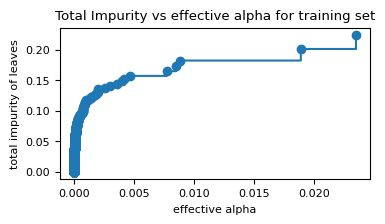

In [23]:
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Based on this graph, where should our optimal alpha be? 
# Note: the largest alphas are removed (hence [:-1] because it results in a trivial tree with one leaf)

In [13]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_val_score(cart, X, y, cv=kf, scoring = 'neg_mean_squared_error') # would give you Rsq by default
    avg_score = cv_result.mean()
    return float(avg_score)

0.00011

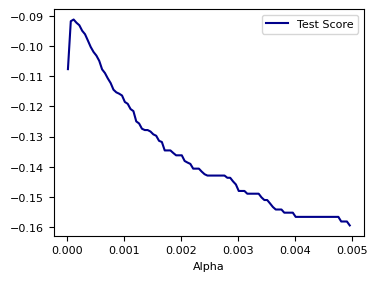

In [15]:
# attention: this CV takes some time, as we are fitting many trees, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.005, 0.00005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmax()

Tree depth: 12
Out-of-sample Rsq: 0.759
Out-of-sample MSE: 0.079


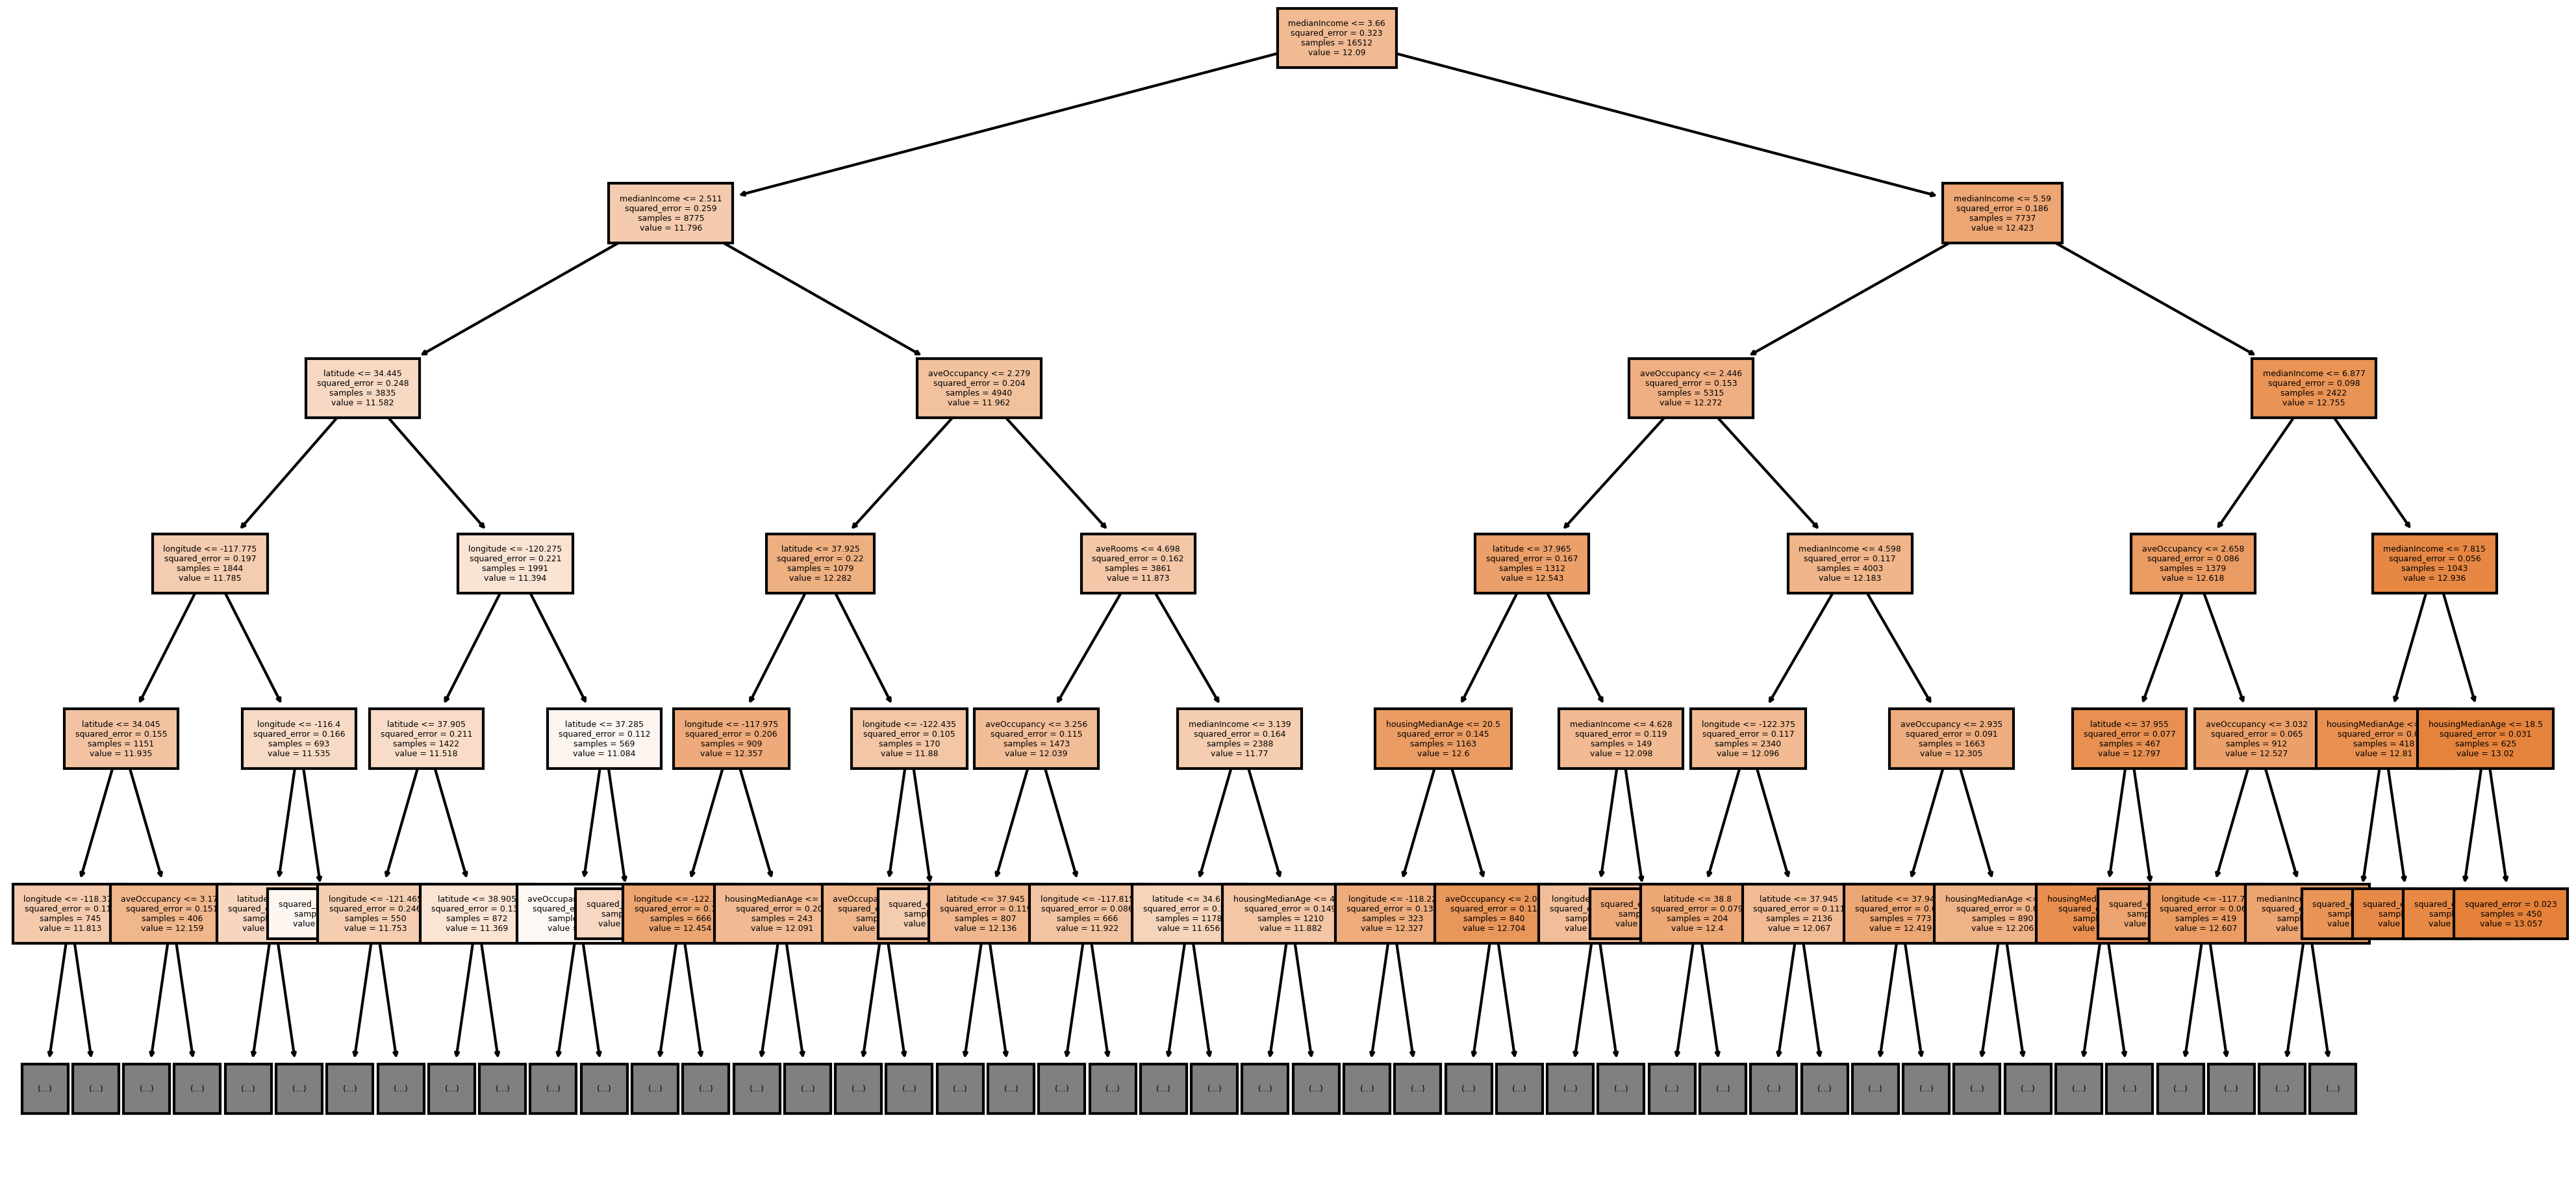

In [17]:
cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmax(), random_state = 1, min_samples_leaf = 10)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

## 5. Random Forest

<div class="alert alert-block alert-info">
<b>Question 5:</b> Fitting a random forest
    
* Which stopping rules did you use? How many trees did you grow? 
* What is the out-of-sample Rsq and MSE?      
* How does the OOS fit changes when you add extra randomization? _Hint:_ use the additional parameter max_features = int(X.shape[1]/3)
* Which covariates are the most important? Use the property feature_importances_
</div>

In [49]:
# now, let's fit a random forest

# Note, there is no strict suggestion whether we should use a stopping rule and/or pruning for individual trees.
# Thereoretically, by aggregating over many trees (even if they individually overfit), we will average-out the noise. 
# Thefore, using fully grown trees rarely causes trouble. I would suggest starting without a stopping rule.

# However, it also depends on the nature of your data (high  noise vs. low noise, the amount of data and dimensions. 
# For instance, it makes sense to apply a stopping rule if you have a small number of observations 
# (you can check this with the last example in the lecture slides, mcycle data, where we only have 133 observations).

# Also when you have a very big dataset, it might make sense to apply a stopping rule, as it will be computationally 
# hard to fit a full tree on your data. 


rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1,  oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

# Estimate of out-of-sample performance with out-of-bag predictions on the training data 
print('OOB Rsq: %.3f'
      % rf.oob_score_)

# Out-of-sample R-sq.
y_pred = rf.predict(X_test)
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

OOB Rsq: 0.829
Out-of-sample Rsq: 0.829
Out-of-sample MSE: 0.056


In [50]:
# let's add an option for extra randomization (for each individual tree, we randomly select a subsample of covariates from X to split on)
# again, here I would recommend checking with and without extra randomization. 

rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

print('OOB Rsq: %.3f'
      % rf.oob_score_)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

OOB Rsq: 0.833
Out-of-sample Rsq: 0.834
Out-of-sample MSE: 0.055


In [44]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_val_score(rf, X, y, cv=kf, scoring = 'neg_mean_squared_error') # would give you Rsq by default
    avg_score = cv_result.mean()
    return float(avg_score)

<AxesSubplot:xlabel='Number of trees'>

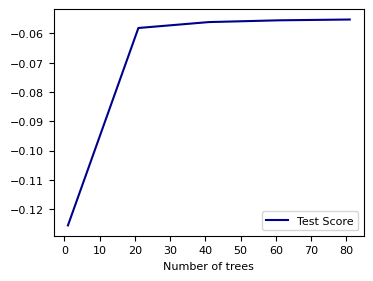

In [45]:
# takes time to run

result = {}
for i in range(1, 100, 20):
    result[i] = cv_iter(i, 5, X_train, y_train)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

## 6. Feature importance 

Use the property feature_importances_ to find out which of the covariates are the most important determinants of House values. 
Create a dataframe that sorts features according to their performance. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_
Sklearn calculates the impurity-based feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 

<div class="alert alert-block alert-info">
<b>Question 6:</b> What are the three most important features? 
    </div>

In [43]:
rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
# some details about the implementation in sklearn https://stats.stackexchange.com/questions/311488/summing-feature-importance-in-scikit-learn-for-a-set-of-features
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

,Feature importance,Feature
0,0.354189,medianIncome
1,0.171249,latitude
2,0.163731,longitude
3,0.110538,aveRooms
4,0.107150,aveOccupancy
5,0.047671,housingMedianAge
6,0.045473,aveBedrooms


## 7. Comparison with OLS and LASSO models

<div class="alert alert-block alert-info">
<b>Question 7:</b> Comparison with OLS and LASSO 
    
* Review lecture 1 and try fitting OLS and LASSO models to the training data 
* Which covariates do you use? Is there a way to capture non-linearities in the data using OLS/LASSO? 
* How does the OOS compare to that of a CART and a RF model? 
* Which covariates are the most important according OLS/LASSO? 
</div>

In [26]:
# reaarange columns for convenience
cols = ['medianHouseValue', 'longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']
df_ols = df_ylog[cols].copy()

# add a constant 
df_ols['c'] = 1

# add interaction  terms
for j in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
    for i in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
        df_ols[f"{j[0:4]}_{i[0:4]}"] = df_ols[j]*df_ols[i]  
        
df_ols.head()

,medianHouseValue,longitude,latitude,medianIncome,aveRooms,aveBedrooms,aveOccupancy,housingMedianAge,c,long_long,...,aveO_aveB,aveO_aveO,aveO_hous,hous_long,hous_lati,hous_medi,hous_aveR,hous_aveB,hous_aveO,hous_hous
0,13.022764,-122.23,37.88,8.3252,6.984127,1.023810,2.555556,41.0,1,14940.1729,...,2.616402,6.530864,104.777778,-5011.43,1553.08,341.3332,286.349206,41.976190,104.777778,1681.0
1,12.789684,-122.22,37.86,8.3014,6.238137,0.971880,2.109842,21.0,1,14937.7284,...,2.050514,4.451433,44.306678,-2566.62,795.06,174.3294,131.000879,20.409490,44.306678,441.0
2,12.771671,-122.24,37.85,7.2574,8.288136,1.073446,2.802260,52.0,1,14942.6176,...,3.008076,7.852660,145.717514,-6356.48,1968.20,377.3848,430.983051,55.819209,145.717514,2704.0
3,12.740517,-122.25,37.85,5.6431,5.817352,1.073059,2.547945,52.0,1,14945.0625,...,2.734096,6.492025,132.493151,-6357.00,1968.20,293.4412,302.502283,55.799087,132.493151,2704.0
4,12.743151,-122.25,37.85,3.8462,6.281853,1.081081,2.181467,52.0,1,14945.0625,...,2.358343,4.758799,113.436293,-6357.00,1968.20,200.0024,326.656371,56.216216,113.436293,2704.0


In [30]:
#OLS with seven features 
data = df_ols.copy()
X = data.iloc[:, 1:9] 
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr = regr.fit(X_train, y_train)

# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

Intercept: -13.108
Coefficients: 
[-0.28953135 -0.28849505  0.18674869 -0.03191019  0.22698303 -0.00143934
  0.00214974  0.        ]
In-sample Rsq: 0.618
Out-of-sample Rsq: 0.597


In [31]:
# OLS with all variables
data = df_ols.copy()
X = data.iloc[:, 1:]
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr = regr.fit(X_train, y_train)

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

In-sample Rsq: 0.703
Out-of-sample Rsq: 0.689


In [35]:
#LASSO 
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.linear_model import Lasso

data = df_ols.copy()
X = data.iloc[:, 1:]
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns) #for memory
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.005, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.6138
Out-of-sample Rsq:  0.5942


Computing regularization path using the lasso...
Ready


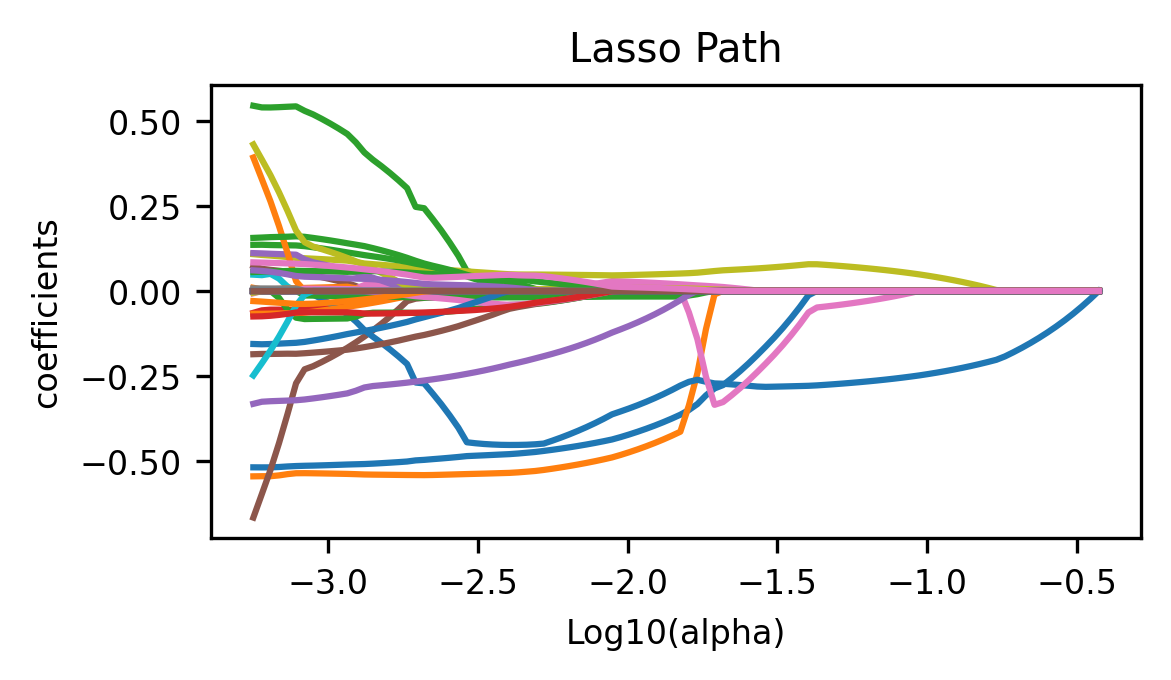

In [30]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [32]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0027 
Training time =  63.6594s 


In [33]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.6532
Out-of-sample Rsq:  0.6429


In [34]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-4.95584666e-01, -5.40751934e-01,  2.75321290e-01, -0.00000000e+00,
        0.00000000e+00, -1.49118228e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.41514814e-01,  0.00000000e+00,
       -6.99584379e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.04121156e-02,  0.00000000e+00,
       -2.49771666e-01,  0.00000000e+00,  2.89666980e-04, -0.00000000e+00,
        6.01908816e-02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        5.18550449e-02, -0.00000000e+00, -0.00000000e+00, -1.11635687e-01,
       -1.59265667e-02,  0.00000000e+00,  4.10923909e-03, -0.00000000e+00,
       -5.15533986e-02, -0.00000000e+00,  4.96488761e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        4.62847903e-02, -

In [37]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.495585,longitude
1,-0.540752,latitude
2,0.275321,medianIncome
3,-0.000000,aveRooms
4,0.000000,aveBedrooms
5,-0.014912,aveOccupancy
6,-0.000000,housingMedianAge
7,0.000000,c
8,0.000000,long_long
9,0.000000,long_lati


In [38]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.495585,longitude
1,-0.540752,latitude
2,0.275321,medianIncome
5,-0.014912,aveOccupancy
10,-0.241515,long_medi
12,-0.069958,long_aveB
22,-0.010412,medi_long
24,-0.249772,medi_medi
26,0.000290,medi_aveB
28,0.060191,medi_hous


# Conclusion

* Trees and forests are good tools when we expect to have non-linearities and interactions in our data + when we are agnostic about the data generation process
* Flexibility of the approach also makes the predictions less stable, highly variable: 
    * Stopping rules 
    * Pruning techniques - use CV to select a tree with a smaller number of terminal nodes
    * Bagging / Random forests - average over simple CART trees 
* There are other tree-based algorithms 
    * Boosted trees
    * Bayes Additive trees
    * Dynamic trees 
* Trees perform well when the number of parameters relative to $N$ is not very high and when observations are independent 
    * Otherwise, alternative techniques or additional data transformations

# Resources 

Matt Taddy (2019) Business Data Science: Combining Machine Learning and Economics to Optimize, Automate, and Accelerate Business Decisions. McGraw-Hill Education

James/Witten/Hastie/Tibrashini (2021) Introduction to Statistical Learning https://web.stanford.edu/~hastie/ISLR2/ISLRv2_website.pdf